In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import ao2mo,gto, scf

from typing import Tuple


# qiskit
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit.algorithms import MinimumEigensolverResult

from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli, SparsePauliOp

# qiskit nature
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

#from qiskit import IBMQ
#from qiskit_nature.runtime import VQEClient
#from qiskit.providers.ibmq import least_busy
#from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# useful??
#from qiskit_nature.algorithms import (GroundStateEigensolver,
#                                      NumPyMinimumEigensolverFactory)
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.opflow import TwoQubitReduction

def get_molecular_integrals(molecule):
    '''
    Calculates the 1-electron and 2-electron integrals.
    
    Args:   
        molecule : Mole 
            Ccorresponds to the molecule.
            
    Returns:
        h1_MO : ndarray
                Tensor corresponding to the 1-electron integral in the molecular basis.
        
        h2_MO : ndarray
                Tensor corresponding to the 2-electron integral in the molecular basis.

        n_particles: Tuple[int, int]
            Number of alpha and beta electrons.
        
        num_orb : int 
            Number of orbitals.

        nuclear_repulsion_energy : float
            Nuclear repulsion energy.
    '''
    
    mf = scf.RHF(molecule).run()

    # computing the 1e and 2e AO (atomic orbitals) integrals 
    h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
    h2 = molecule.intor("int2e")
    # comment : add aosym (axis of symmetry) ???

    # transformations from AO to MO (molecular orbitals)
    h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
    h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

    #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

    nuclear_repulsion_energy=molecule.energy_nuc()
    num_particles = molecule.nelec
    num_orb = h1.shape[0]

    return h1_MO, h2_MO, num_particles, num_orb, nuclear_repulsion_energy


def get_qubit_op(coordinates):
    '''
    Calculates the Hamiltonian as the sum of Pauli operators as a function
    of the coordinates of the atoms.
    
    Args:
        coordinates : ndarray
            Array containing the positions of the atoms constituing the molecule.
        
    
    Returns:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
    '''
    
    mol = gto.M(
                atom = [['H',(coordinates[0], coordinates[1], 0.0)], 
                        ['H',(coordinates[2], coordinates[3], 0.0)],
                        ['H',(coordinates[4], coordinates[5], 0.0)]],
                basis = 'sto3g',
                charge = 1,
                spin = 0,
                symmetry = True,
                verbose = 2 # control the print level of PySCF globally
    )

    h1_MO,h2_MO,nelec,norb,ecore = get_molecular_integrals(mol)

    # Define an ElectronicEnergy instance containing the 1e and 2e integrals
    electronic_energy = ElectronicEnergy.from_raw_integrals(
            h1_MO, ao2mo.restore(1, h2_MO, norb)
        )
    electronic_energy.nuclear_repulsion_energy = ecore

    # Define an ElectronicStructureProblem
    problem = ElectronicStructureProblem(electronic_energy)

    second_q_ops = problem.second_q_ops()     # get second quantized operators
    problem.num_spatial_orbitals = norb  # define number of orbitals
    problem.num_particles = nelec        # define number of particles 
    
    problem.basis = ElectronicBasis.MO 
    
    problem.molecule=MoleculeInfo(symbols=[mol.atom_symbol(i) for i in range(mol.nbas)], 
                                  coords=mol.atom_coords())
    FC_transformer=FreezeCoreTransformer(freeze_core=True)
    problem = FC_transformer.transform(problem)
    
    # TODO we need to give info about the molecule to use FreezeCoreTransformer 
    # question : how to do it in a smart way ? at the initialization ??
    
    hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
    hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=norb)) # add Nuclear Repulsion Energy
    #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
    
    mapper = ParityMapper()  # Set Mapper
    
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    qubit_op = converter.convert(hamiltonian, nelec)
    #print("q_op :\n", qubit_op) # print for checking purposes
    

    return qubit_op, nelec, norb, problem, converter

def calc_ground_state(qubit_op,nelec,norb,problem,converter) :
    '''
    Calculates the ground state and the ground energy of the Hamiltonian.
    
    Args:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
        
    
    Returns:
        ground_state : CircuitStateFn
            Ground state of the Hamiltonian.
            
        min_eng : float
            Ground energy of the Hamiltonian.
    '''

    backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)
    optimizer = SLSQP(maxiter=400)

    init_state = HartreeFock(num_spatial_orbitals=norb, 
                                num_particles=nelec, 
                                qubit_converter=converter
                            )
    
    var_form = UCCSD(qubit_converter=converter,
                        num_particles=nelec,
                        num_spatial_orbitals=norb, 
                        initial_state=init_state
                        )

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    min_eng = vqe_result.eigenvalue.real
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params) 
#     vqe_ground_state = CircuitStateFn(vqe_ground)
    
    return vqe_ground, min_eng

In [ ]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.01 #removed the angst, since coordinates are given in angst


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest
import multiprocessing


def expectation_exact(psi_0,op):
    
    return psi_0.adjoint().compose(op).compose(psi_0).eval().real
    
    
    



#calculate centre of mass (currently for equal particle masses)
def calc_COM(coordinates):
    #print(coordinates)
    r_array = np.array_split(coordinates,3)
    COM = (r_array[0] + r_array[1] + r_array[2])/3
    
    return COM

#task to calculate expectation value
def task1(string, q_instance, psi_0):

    Obs = PauliOp(Pauli(string))
    measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
    expectation = PauliExpectation().convert(measurable_expression)
    sampler = CircuitSampler(q_instance)
    sampler1 = sampler.convert(expectation)
    sampler2 = sampler.convert(expectation)

    sampler3 = sampler.convert(expectation)

    sampler4 = sampler.convert(expectation)

    sampler5 = sampler.convert(expectation)

    sampler6 = sampler.convert(expectation)
    
    E1 = sampler1.eval().real
    E2 = sampler2.eval().real
    E3 = sampler3.eval().real
    E4 = sampler4.eval().real
    E5 = sampler5.eval().real
    E6 = sampler6.eval().real
    
    E = [E1,E2,E3,E4,E5,E6]
    E_ex = expectation_exact(psi_0,Obs)
        
    return (E,E_ex)

#task to calculate operator from coordinates
def task2(coordinates):
    
    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0])
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[1])
        
    qubit_op_plus = qubit_op_plus #TODO:number of I's needs to be changed according to number of qubits
    qubit_op_minus = qubit_op_minus
       
    #op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
    op =  -(qubit_op_plus - qubit_op_minus)

                    
    op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
    #print(op_list)    
    #construct dict from list
    op_dict = {}
    for (PauliString,coeff) in op_list:

        if PauliString in op_dict:
            op_dict[PauliString] += coeff
        else:
            op_dict[PauliString] = coeff
    
    return op, op_dict
 
def parallel_operators(coordinates,basis_set):
    
    
    coordinate_list = []
    
    v0_normed = basis_set[0]
    v0_orth = basis_set[1]
    
    v1_normed = basis_set[2]
    v1_orth = basis_set[3]

    v2_normed = basis_set[4]
    v2_orth = basis_set[5]
    
    displ_coords_0_a = np.array([v0_normed[0]*dR,v0_normed[1]*dR,0,0,0,0])
    displ_coords_0_b = np.array([v0_orth[0]*dR,v0_orth[1]*dR,0,0,0,0])
    displ_coords_1_a = np.array([0,0,v1_normed[0]*dR,v1_normed[1]*dR,0,0])
    displ_coords_1_b = np.array([0,0,v1_orth[0]*dR,v1_orth[1]*dR,0,0])
    displ_coords_2_a = np.array([0,0,0,0,v2_normed[0]*dR,v2_normed[1]*dR])
    displ_coords_2_b = np.array([0,0,0,0,v2_orth[0]*dR,v2_orth[1]*dR])
    #print(displ_coords_0_a)
    #print(displ_coords_0_b)
    #print(displ_coords_1_a)
    #print(displ_coords_1_b)
    #print(displ_coords_2_a)
    #print(displ_coords_2_b)

    coordinate_list.append([coordinates + displ_coords_0_a,coordinates - displ_coords_0_a])
    coordinate_list.append([coordinates + displ_coords_0_b,coordinates - displ_coords_0_b])
    coordinate_list.append([coordinates + displ_coords_1_a,coordinates - displ_coords_1_a])
    coordinate_list.append([coordinates + displ_coords_1_b,coordinates - displ_coords_1_b])
    coordinate_list.append([coordinates + displ_coords_2_a,coordinates - displ_coords_2_a])
    coordinate_list.append([coordinates + displ_coords_2_b,coordinates - displ_coords_2_b])
    
    #dR_list = v0_normed.tolist() + v1_normed.tolist() + v2_normed.tolist()
    
    dR_list = [dR,dR,dR,dR,dR,dR]
    #print(dR_list)
    #for i in range(len(coordinates)):
        
        #coordinate_list.append([coordinates[0:i]+[(coordinates[i]+dR_list[i])]+coordinates[i+1:],coordinates[0:i]+[(coordinates[i]-dR_list[i])]+coordinates[i+1:]])
    
    #print(coordinate_list)
    with multiprocessing.Pool() as pool:
         ops,op_coeffs = zip(*pool.map(task2, coordinate_list))
    
    #print(ops)
    return ops, op_coeffs

def sequential_operators(coordinates):
    ops = []
    op_coeffs = []
    
    for i in range(len(coordinates)):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  -(qubit_op_plus - qubit_op_minus).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        ops.append(op)
        op_coeffs.append(op_dict)
    #print(ops)
    return ops, op_coeffs

def parallel_expectations(exp_dict_exact, exp_dict, op_set, q_instance, psi_0):

    triples = []
    for op in op_set:
        triple = (op,q_instance,psi_0)
        triples.append(triple)

    Es = 0
    with multiprocessing.Pool() as pool:
        Es,E_ex = zip(*pool.starmap(task1, triples))
        #print(Es)
        #print(E_ex)
        #Es,E_ex = pool.starmap(task1, triples)
    for i in range(len(Es)):
        
        exp_dict[triples[i][0]]=Es[i]
        exp_dict_exact[triples[i][0]]=E_ex[i]
                       
    return 0

def sequential_expectations(exp_dict, op_set, q_instance, psi_0):

    for pauli_string in op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        exp_dict[pauli_string] = E

    return 0

def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter)
    
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 128, basis_set_this=None):
  
    
    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator')
            #backend.set_options(max_job_size=1, executor = euler_client)
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    

    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    
    end = time.time()
    
    
    time_psi_0 = end - start
    #print("Took " + str(time_psi_0) + " s to calculate the ground state")
    forces = np.zeros(num_coord)
    forces_exact = np.zeros(num_coord)
    coordinates = coordinates.tolist()
    
    
    coordinates_this = np.array(coordinates)
    COM = calc_COM(coordinates_this)
    coords = np.array_split(coordinates_this,3)
    #print(coords)
    #print(COM)
    v0 = coords[0] - COM
    v1 = coords[1] - COM
    v2 = coords[2] - COM
    
    v0_normed = np.array(v0/np.sqrt(v0[0]**2+v0[1]**2))
    v0_orth = np.array([v0_normed[1],-v0_normed[0]])
    
    v1_normed = np.array(v1/np.sqrt(v1[0]**2+v1[1]**2))
    v1_orth = np.array([v1_normed[1],-v1_normed[0]])

    v2_normed = np.array(v2/np.sqrt(v2[0]**2+v2[1]**2))
    v2_orth = np.array([v2_normed[1],-v2_normed[0]])
    
    #rotated basis
    if basis_set_this == "rotated":
        basis_set = [v0_normed,v0_orth,v1_normed,v1_orth,v2_normed,v2_orth]
    #cartesian basis
    elif basis_set_this == "cartesian":
        basis_set = [[1,0],[0,1],[1,0],[0,1],[1,0],[0,1]]
    
    #basis_set = basis_set_this

    transform_matrix = np.array([[basis_set[0][0],basis_set[1][0],0,0,0,0],
                                 [basis_set[0][1],basis_set[1][1],0,0,0,0],
                                 [0,0,basis_set[2][0],basis_set[3][0],0,0],
                                 [0,0,basis_set[2][1],basis_set[3][1],0,0],
                                 [0,0,0,0,basis_set[4][0],basis_set[5][0]],
                                 [0,0,0,0,basis_set[4][1],basis_set[5][1]]])
    
    transform_matrix_inv = np.linalg.inv(transform_matrix)
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons)
    #replace parallel_ with sequential_ to see effect of parallelization
    force_ops,force_op_coeffs = parallel_operators(coordinates,basis_set)
    
    #for ops in force_ops:
        #print(len(ops))
        
    P1 = force_ops[0]
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = (P1@P1)
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
    exp_dict_exact = {}  # dictionary with exact relevant expectation values
        
    #switch between parallel_ and sequential_ to see the effect
    
    parallel_expectations(exp_dict_exact,exp_dict,pauli_op_set,q_instance,psi_0)
    

    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op][i]
            forces_exact[i] += coeff.real*exp_dict_exact[pauli_op]
    
    #forces[1] = 0
    #forces[3] = 0
    #forces[5] = 0
    
    if basis_set_this == "rotated":
        forces_return = np.matmul(transform_matrix,np.array(forces))
    elif basis_set_this == "cartesian":
        forces_return = forces
        
    #print(forces)
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
                
            Pij_list = Pij.primitive.to_list()

            #add product expectation 
            
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict_exact[pauli_string]
                    #subtract 
            COV[i,j] -= forces_exact[i]*forces_exact[j]
            
            #diagonal mode
            #if i != j:
                #COV[i,j] = 0
            #since COV is symmetric
            
            if i < j:
                COV[j,i] = COV[i,j]
            
            
                
    #print(COV)            
    end = time.time()
    
    if basis_set_this == "rotated":
        #print(COV)
        COV_1 = np.matmul(COV,transform_matrix)
        COV_2 = np.matmul(transform_matrix_inv,COV_1)
        COV_return = COV_2
        #COV_return = COV
        #print(COV_return)
    elif basis_set_this == "cartesian":    
        COV_return = COV
        
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    
    return forces_return*Ha*(1/(2*dR*angst)),COV_return*(Ha*(1/(2*dR*angst)))**2

In [ ]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def calc_COM(coordinates):
    #print(coordinates)
    r_array = np.array_split(coordinates,3)
    COM = (r_array[0] + r_array[1] + r_array[2])/3
    
    return COM

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))

    


def main():
    
    f = open("128k_full_allrandom_temperature.txt","w")
    
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    
    mass = mass_0

    #distances between atoms
    d = 0.8
    #rotation angle of the initial triangle
    b = 0/180*np.pi
    
    #initial positions of atoms, arrangement = equilateral triangle
    x1_init = np.array([-d/2*np.cos(b)+np.sin(b)*np.sqrt(3)/6*d,-d/2*np.sin(b)-np.cos(b)*np.sqrt(3)/6*d])+np.array([0,d*np.sqrt(3)/6])
    x2_init = np.array([d/2*np.cos(b)+np.sin(b)*np.sqrt(3)/6*d,d/2*np.sin(b)-np.cos(b)*np.sqrt(3)/6*d])+np.array([0,d*np.sqrt(3)/6])
    x3_init = np.array([-np.sin(b)*np.sqrt(3)/3*d,np.cos(b)*np.sqrt(3)/3*d])+np.array([0,d*np.sqrt(3)/6])
    
    
    init_pos0 = x1_init
    init_pos1 = x2_init
    init_pos2 = x3_init
    
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)
    
    ##initialize velocities in the direction of the COM for each particle
    
    COM = calc_COM(init_pos)
    
    c0 = COM - init_pos0
    c1 = COM - init_pos1
    c2 = COM - init_pos2
    
    dir0 = c0/np.sqrt(c0[0]**2+c0[1]**2)
    dir1 = c1/np.sqrt(c1[0]**2+c1[1]**2)
    dir2 = c2/np.sqrt(c2[0]**2+c2[1]**2)

    v_init_mag = 5e2

    v_init = np.concatenate((dir0,dir1,dir2),axis=None)*v_init_mag
    
    

    #integrator timesteps
    
    timeB = 0
    timeE = 150
    times = np.arange(timeB*femto, timeE*femto, dt)
    
    
    #print(times)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
        
    delta = 0.2*dt
    
    temperature = []
    #hold v_next
    
    v_next = None
    
    simulator = 'qasm'
    COM = calc_COM(init_pos)
    coords_loc = np.array_split(init_pos,3)
    forces_array = []
    velocities_array = []
    velocities_array.append(v_init.tolist())
    coords_array = []
    coords_array.append(init_pos.tolist())
    
    n_dof = 3
    
    #"cartesian" or "rotated"
    
    basis_set = "rotated"
    
    diag_elems = []
    
    shots = 128000
    
    for time in tqdm(times, desc='Progress: '):
        
        #time = 0
        
        r = coords[-1]
        #print(r)
        
        (forces,COV) = calc_force_and_cov(r, simulator = simulator, shots = shots, basis_set_this=basis_set)
        #diag_elems.append(COV[0][0])
        #print(diag_elems)
        
        forces_array.append(forces.tolist())
        
        f1 = distance(np.array([forces[0],forces[1]]),np.array([0,0]))
        
        f2 = distance(np.array([forces[2],forces[3]]),np.array([0,0]))
        
        f3 = distance(np.array([forces[4],forces[5]]),np.array([0,0]))    
        
        print("f0,f1,f2 = " + str([f1,f2,f3]))
        
        
        if time == 0:
            
            #v_sample = v_init
            
            #velocities = np.array(np.array_split(v_sample,3))
            velocities= np.array(velocities_array)
            #print(velocities)
            kin_eng = np.sum(velocities**2*mass/2, axis=1)
            #print(kin_eng)
            k_T = 2*np.sum(kin_eng)/np.size(kin_eng)/n_dof
            
            temperature.append(k_T/k_b)
            k_T = k_b * T
            #print(temperature)
            
            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:
            
            #v_sample = v_next
            velocities= np.array(velocities_array)
            #velocities = np.array(np.array_split(v_sample,3))
            
            kin_eng = np.sum(velocities**2*mass/2, axis=1)
            #print(kin_eng)
            k_T = 2*np.sum(kin_eng)/np.size(kin_eng)/n_dof
            
            temperature.append(k_T/k_b)
            
            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)
            
            coords.append(r_next)
            
        velocities_array.append(v_next.tolist())  
        coords_array.append(coords[-1].tolist())
        
        r = np.array_split(coords[-1],3)
        d01 = distance(r[0],r[1])
        d02 = distance(r[0],r[2])
        d12 = distance(r[1],r[2])
        print("d01,d02,d12 = " + str([d01,d02,d12]))
        print("Temp:" + str(temperature[-1]) + "K")
        #print(temperature[-1])
        
        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    timess = times.tolist()
    timess.append(timeE*femto)
    
    #f.write('diagonal elements for n = ' + str(shots) + " no of shots" + '\n')
    #f.write(str(diag_elems))
    
    
    f.write('times \n')
    f.write(str(timess) + "\n")
    f.write("coordinates \n")
    f.write(str(coords_array) + "\n")
    f.write("velocities \n")
    f.write(str(velocities_array) + "\n")
    f.write("forces \n")
    f.write(str(forces_array) + "\n")
    f.write("temperatures \n")
    f.write(str(temperature) + "\n")
    
    return (distance01,distance02,distance12,times) 

Progress:   0%|          | 1/750 [00:22<4:36:12, 22.13s/it]

Time to: Calculate Ground State - 2.02s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 12.81s, Calculate Covariance - 1.98s
f0,f1,f2 = [1.2706028233120478e-08, 1.2335387919787544e-08, 1.2864447093063596e-08]
d01,d02,d12 = [0.8035400462727457, 0.803649788668088, 0.803572908564339]
Temp:30.239380002172886K


Progress:   0%|          | 2/750 [00:49<5:14:36, 25.24s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 11.45s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 2.21s
f0,f1,f2 = [1.0580419282535869e-08, 1.1834273743469648e-08, 1.2505796198544006e-08]
d01,d02,d12 = [0.8108866940062002, 0.8112450388209103, 0.8113515686189654]
Temp:80.02947127802688K


Progress:   0%|          | 3/750 [01:19<5:39:33, 27.27s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 12.57s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.33s
f0,f1,f2 = [1.1163875529560401e-08, 1.0596877844196518e-08, 1.1493497620913234e-08]
d01,d02,d12 = [0.8221730589690235, 0.8229646831687284, 0.8231359012274588]
Temp:246.49324475714505K


Progress:   1%|          | 4/750 [01:49<5:52:52, 28.38s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 12.58s, Calculate Pauli Expectation Values - 13.34s, Calculate Covariance - 3.16s
f0,f1,f2 = [9.982340886499674e-09, 1.0720440522263274e-08, 1.0232303969579504e-08]
d01,d02,d12 = [0.83734852391343, 0.8384642499737882, 0.8388537774968562]
Temp:524.2596264238069K


Progress:   1%|          | 5/750 [02:22<6:11:57, 29.96s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 14.7s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 3.47s
f0,f1,f2 = [8.702696526013599e-09, 8.853074512400073e-09, 8.432488093202343e-09]
d01,d02,d12 = [0.8558583475754316, 0.8572004194311447, 0.8578348678005818]
Temp:901.9230425753028K


Progress:   1%|          | 6/750 [02:53<6:19:45, 30.63s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 14.02s, Calculate Pauli Expectation Values - 13.71s, Calculate Covariance - 3.05s
f0,f1,f2 = [7.520942991833769e-09, 6.97410455483522e-09, 8.178610657138685e-09]
d01,d02,d12 = [0.8771247109589627, 0.8789336171092748, 0.8797039709179116]
Temp:1342.0035489072363K


Progress:   1%|          | 7/750 [03:28<6:33:43, 31.79s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 16.29s, Calculate Pauli Expectation Values - 13.39s, Calculate Covariance - 3.19s
f0,f1,f2 = [5.638549935256276e-09, 6.7128550515240526e-09, 4.0620602663230516e-09]
d01,d02,d12 = [0.9007460869733944, 0.9024593525232826, 0.9035901964110662]
Temp:1823.959681398851K


Progress:   1%|          | 8/750 [04:00<6:34:11, 31.87s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 14.27s, Calculate Pauli Expectation Values - 13.63s, Calculate Covariance - 3.13s
f0,f1,f2 = [4.2404207044927955e-09, 4.5010760211706806e-09, 4.296577704754467e-09]
d01,d02,d12 = [0.926000010938846, 0.9275766681022886, 0.9291069048165245]
Temp:2302.4774867897263K


Progress:   1%|          | 9/750 [04:32<6:37:01, 32.15s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 14.89s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.28s
f0,f1,f2 = [2.4848972133903186e-09, 2.1131882826173293e-09, 2.940091584838916e-09]
d01,d02,d12 = [0.952058213067521, 0.9536613168888997, 0.9554872612760371]
Temp:2763.4429884314063K


Progress:   1%|▏         | 10/750 [05:07<6:44:08, 32.77s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 16.39s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 3.3s
f0,f1,f2 = [2.571586568391214e-09, 1.7534707709099264e-09, 2.3036624577206018e-09]
d01,d02,d12 = [0.9788579585598173, 0.9806160527421788, 0.9825654762117544]
Temp:3177.7938539701054K


Progress:   1%|▏         | 11/750 [05:37<6:33:52, 31.98s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 13.5s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 2.72s
f0,f1,f2 = [7.513596485179272e-10, 8.469379055507232e-11, 8.18975527478818e-10]
d01,d02,d12 = [1.0056999495857541, 1.0074110142173938, 1.009365054838791]
Temp:3554.239537500722K


Progress:   2%|▏         | 12/750 [06:06<6:23:58, 31.22s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 12.89s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 2.67s
f0,f1,f2 = [2.025894133268803e-09, 9.974994488920076e-10, 1.5556756605189014e-09]
d01,d02,d12 = [1.031777696697613, 1.0333680765313138, 1.0355016002335362]
Temp:3861.918131333904K


Progress:   2%|▏         | 13/750 [06:37<6:21:21, 31.05s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 13.05s, Calculate Pauli Expectation Values - 13.34s, Calculate Covariance - 3.43s
f0,f1,f2 = [2.114838513126788e-09, 1.746587786718079e-09, 9.995121492732264e-10]
d01,d02,d12 = [1.0569447672566592, 1.058560698671676, 1.0609596067669183]
Temp:4091.337118954044K


Progress:   2%|▏         | 14/750 [07:08<6:22:13, 31.16s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 13.66s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 3.3s
f0,f1,f2 = [2.054277382412315e-09, 3.0180891505847873e-09, 2.848590244271163e-09]
d01,d02,d12 = [1.0809621858026564, 1.0826091470786532, 1.0851110538581885]
Temp:4259.031147679097K


Progress:   2%|▏         | 15/750 [07:38<6:16:50, 30.76s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 12.98s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 2.97s
f0,f1,f2 = [2.345702877808015e-09, 3.049251407573839e-09, 2.408575246307959e-09]
d01,d02,d12 = [1.1037643276232858, 1.1055630169900852, 1.1080409286943107]
Temp:4364.5197643246875K


Progress:   2%|▏         | 16/750 [08:09<6:15:26, 30.69s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 13.23s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.5s
f0,f1,f2 = [3.2425653906815673e-09, 3.5591430841702636e-09, 3.969549631948744e-09]
d01,d02,d12 = [1.125045097914545, 1.1269353029438982, 1.1293287104626377]
Temp:4421.997848865991K


Progress:   2%|▏         | 17/750 [08:39<6:14:25, 30.65s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 13.69s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 2.7s
f0,f1,f2 = [3.6748462493687897e-09, 4.001607220265126e-09, 4.129785514128553e-09]
d01,d02,d12 = [1.144652797167978, 1.1466191872275866, 1.1488242457900981]
Temp:4431.23978263857K


Progress:   2%|▏         | 18/750 [09:12<6:23:11, 31.41s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 15.65s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.15s
f0,f1,f2 = [4.956269353856131e-09, 5.0222830164375415e-09, 4.818307837953003e-09]
d01,d02,d12 = [1.1621127622636074, 1.1641939850741967, 1.166198132411531]
Temp:4400.103725837551K


Progress:   3%|▎         | 19/750 [09:44<6:24:47, 31.58s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 14.36s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 3.16s
f0,f1,f2 = [5.4695863206151e-09, 5.091309244031422e-09, 4.581010227103681e-09]
d01,d02,d12 = [1.177299219255185, 1.1795987163851063, 1.1815187218763374]
Temp:4330.439508546986K


Progress:   3%|▎         | 20/750 [10:17<6:28:24, 31.92s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 15.65s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 2.9s
f0,f1,f2 = [5.374533584815722e-09, 5.258195048156687e-09, 4.4375399371467485e-09]
d01,d02,d12 = [1.1902024395431892, 1.192925454043419, 1.1947539992345688]
Temp:4231.979836911267K


Progress:   3%|▎         | 21/750 [10:50<6:31:35, 32.23s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 16.1s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 2.43s
f0,f1,f2 = [4.5890945956002596e-09, 5.392062787309723e-09, 4.975033862350447e-09]
d01,d02,d12 = [1.2009627092166115, 1.2042482958648035, 1.205760444880883]
Temp:4113.5884770487755K


Progress:   3%|▎         | 22/750 [11:25<6:40:10, 32.98s/it]

Time to: Calculate Ground State - 1.42s, Get Pauli Ops - 15.69s, Calculate Pauli Expectation Values - 14.78s, Calculate Covariance - 2.83s
f0,f1,f2 = [4.9529316061900625e-09, 5.295925790310561e-09, 5.678231301251047e-09]
d01,d02,d12 = [1.209565629189148, 1.2133098343958926, 1.2144279389453714]
Temp:3982.4311029744536K


Progress:   3%|▎         | 23/750 [11:58<6:38:35, 32.90s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 14.77s, Calculate Pauli Expectation Values - 13.47s, Calculate Covariance - 3.27s
f0,f1,f2 = [5.664414733523318e-09, 5.525528532841566e-09, 4.577959976188725e-09]
d01,d02,d12 = [1.2157562600039094, 1.22022104367485, 1.220997308288127]
Temp:3843.107166258586K


Progress:   3%|▎         | 24/750 [12:30<6:34:45, 32.62s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 15.05s, Calculate Pauli Expectation Values - 12.84s, Calculate Covariance - 2.84s
f0,f1,f2 = [5.454944578513908e-09, 5.563612681805842e-09, 6.477594584234729e-09]
d01,d02,d12 = [1.219631544757929, 1.2246166236566007, 1.2250426059275743]
Temp:3701.147049603136K


Progress:   3%|▎         | 25/750 [13:02<6:32:23, 32.47s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 14.44s, Calculate Pauli Expectation Values - 13.51s, Calculate Covariance - 3.13s
f0,f1,f2 = [5.702337120866027e-09, 5.724872768597996e-09, 5.836657191796025e-09]
d01,d02,d12 = [1.2211798375800502, 1.2265990000954117, 1.2266115862115998]
Temp:3559.951698306454K


Progress:   3%|▎         | 26/750 [13:33<6:28:07, 32.17s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 14.33s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 2.75s
f0,f1,f2 = [5.714111530066112e-09, 5.682373000017299e-09, 6.38310163418084e-09]
d01,d02,d12 = [1.2203105816397397, 1.2260907998741728, 1.2256882546685104]
Temp:3424.2044275059475K


Progress:   4%|▎         | 27/750 [14:05<6:27:11, 32.13s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 14.66s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.1s
f0,f1,f2 = [5.685881583552073e-09, 5.69358163172445e-09, 6.3942494634959e-09]
d01,d02,d12 = [1.2170613004665494, 1.223129935576631, 1.2222427107566909]
Temp:3297.6363221220604K


Progress:   4%|▎         | 28/750 [14:40<6:36:54, 32.98s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 15.62s, Calculate Pauli Expectation Values - 14.75s, Calculate Covariance - 3.51s
f0,f1,f2 = [5.436975290756863e-09, 5.649058243372137e-09, 5.827488866331938e-09]
d01,d02,d12 = [1.211517981446971, 1.2178561821118006, 1.2164431634833157]
Temp:3183.6372752499233K


Progress:   4%|▍         | 29/750 [15:12<6:31:07, 32.55s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 14.65s, Calculate Pauli Expectation Values - 12.93s, Calculate Covariance - 3.09s
f0,f1,f2 = [5.620762042475416e-09, 5.5386322276242e-09, 5.7590134183576415e-09]
d01,d02,d12 = [1.2037347909358946, 1.2102096557459088, 1.2083396563735003]
Temp:3084.5692752785485K


Progress:   4%|▍         | 30/750 [15:44<6:29:47, 32.48s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 14.29s, Calculate Pauli Expectation Values - 13.4s, Calculate Covariance - 3.6s
f0,f1,f2 = [5.53633837258918e-09, 5.4663572314643e-09, 5.601516930516957e-09]
d01,d02,d12 = [1.1936872224649684, 1.2003373087145073, 1.1979826616504605]
Temp:3002.4625692894638K


Progress:   4%|▍         | 31/750 [16:17<6:32:10, 32.73s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 15.21s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.44s
f0,f1,f2 = [5.393252944282304e-09, 5.30325761519726e-09, 4.905377484859494e-09]
d01,d02,d12 = [1.1814616687250825, 1.1884475157191077, 1.185539293276089]
Temp:2938.771174738342K


Progress:   4%|▍         | 32/750 [16:49<6:28:40, 32.48s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 14.06s, Calculate Pauli Expectation Values - 13.53s, Calculate Covariance - 3.21s
f0,f1,f2 = [5.074962557813306e-09, 5.244256877192641e-09, 4.805271290719847e-09]
d01,d02,d12 = [1.1671973240958617, 1.1746050277625044, 1.1710441132596963]
Temp:2893.758083506605K


Progress:   4%|▍         | 33/750 [17:19<6:19:57, 31.80s/it]

Time to: Calculate Ground State - 1.42s, Get Pauli Ops - 12.65s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 2.99s
f0,f1,f2 = [5.09996430753056e-09, 4.949272388414539e-09, 5.033938223088105e-09]
d01,d02,d12 = [1.1509573578782542, 1.1587370878141472, 1.1545601022133474]
Temp:2867.7179874185113K


Progress:   5%|▍         | 34/750 [17:50<6:15:43, 31.49s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 13.4s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 3.15s
f0,f1,f2 = [4.692401293088155e-09, 4.679248785331285e-09, 4.769932907670626e-09]
d01,d02,d12 = [1.1328430805804053, 1.140972072061951, 1.136294621717556]
Temp:2861.2000958860767K


Progress:   5%|▍         | 35/750 [18:22<6:16:01, 31.55s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 13.36s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 3.84s
f0,f1,f2 = [3.853996023864779e-09, 4.270462659952842e-09, 4.523640122060968e-09]
d01,d02,d12 = [1.1131648977124409, 1.1215852929131436, 1.116304527411775]
Temp:2873.2977987042636K


Progress:   5%|▍         | 36/750 [18:54<6:17:51, 31.75s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 14.87s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.14s
f0,f1,f2 = [3.919424193793188e-09, 3.799845227898897e-09, 4.005376348427991e-09]
d01,d02,d12 = [1.0920460020855398, 1.1006284534243813, 1.0948283994827221]
Temp:2902.02976971839K


Progress:   5%|▍         | 37/750 [19:26<6:16:55, 31.72s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 13.79s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 3.39s
f0,f1,f2 = [3.76806333464333e-09, 3.4162467781921312e-09, 3.2159922187385137e-09]
d01,d02,d12 = [1.0695894118133218, 1.0783528452400557, 1.0720789637411727]
Temp:2945.890757795153K


Progress:   5%|▌         | 38/750 [19:56<6:11:08, 31.28s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 12.6s, Calculate Pauli Expectation Values - 13.39s, Calculate Covariance - 3.09s
f0,f1,f2 = [2.0063223191836192e-09, 2.8991707914119068e-09, 3.66476554442288e-09]
d01,d02,d12 = [1.0462587730441628, 1.0550387163828714, 1.0480851871812495]
Temp:3002.6102914353214K


Progress:   5%|▌         | 39/750 [20:27<6:09:33, 31.19s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 13.31s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 3.11s
f0,f1,f2 = [2.989211266763763e-09, 2.2747698367071715e-09, 2.8415067202954816e-09]
d01,d02,d12 = [1.0219083097058648, 1.0306906968494645, 1.0232133939319086]
Temp:3068.9882706770654K


Progress:   5%|▌         | 40/750 [21:00<6:14:50, 31.68s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 15.0s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 3.42s
f0,f1,f2 = [6.960020454982011e-10, 1.4297115809798999e-09, 1.4767519987980868e-09]
d01,d02,d12 = [0.9973363545075516, 1.0059721270665833, 0.9979295841866465]
Temp:3143.87322290893K


Progress:   5%|▌         | 41/750 [21:33<6:20:36, 32.21s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 15.57s, Calculate Pauli Expectation Values - 13.58s, Calculate Covariance - 3.2s
f0,f1,f2 = [1.3772505887512556e-09, 5.386838890773578e-10, 6.712400711542979e-10]
d01,d02,d12 = [0.9724780269749319, 0.9809614550978042, 0.9726150812637157]
Temp:3219.1984226923964K


Progress:   6%|▌         | 42/750 [22:06<6:20:47, 32.27s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 14.62s, Calculate Pauli Expectation Values - 13.49s, Calculate Covariance - 3.15s
f0,f1,f2 = [1.434057751153044e-09, 5.249556964734983e-10, 1.104202270360926e-09]
d01,d02,d12 = [0.9482071562917461, 0.9564648959854267, 0.9478010543791006]
Temp:3293.332074977885K


Progress:   6%|▌         | 43/750 [22:37<6:18:45, 32.14s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 14.58s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 3.09s
f0,f1,f2 = [1.992433911185266e-09, 1.6448478843389863e-09, 1.809010854597276e-09]
d01,d02,d12 = [0.9248758374270425, 0.9326671970090512, 0.9238877357492032]
Temp:3357.826711871478K


Progress:   6%|▌         | 44/750 [23:10<6:18:37, 32.18s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 13.64s, Calculate Pauli Expectation Values - 14.31s, Calculate Covariance - 3.16s
f0,f1,f2 = [2.78421402703778e-09, 2.826179400931229e-09, 2.7494652166178366e-09]
d01,d02,d12 = [0.90286924822513, 0.9100841543187819, 0.9012635377662095]
Temp:3410.076081918647K


Progress:   6%|▌         | 45/750 [23:43<6:20:55, 32.42s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 15.09s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.51s
f0,f1,f2 = [4.0283574812347605e-09, 4.173849682923761e-09, 4.094684167816902e-09]
d01,d02,d12 = [0.8826754471135313, 0.8892817912198048, 0.8804941266137577]
Temp:3446.842562934959K


Progress:   6%|▌         | 46/750 [24:14<6:16:16, 32.07s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 14.34s, Calculate Pauli Expectation Values - 12.98s, Calculate Covariance - 2.64s
f0,f1,f2 = [5.347669691352582e-09, 5.3839772609125924e-09, 5.677084428111724e-09]
d01,d02,d12 = [0.8648070845725423, 0.8708679790588985, 0.8621360548424201]
Temp:3464.901927358445K


Progress:   6%|▋         | 47/750 [24:45<6:13:40, 31.89s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 13.9s, Calculate Pauli Expectation Values - 13.26s, Calculate Covariance - 3.24s
f0,f1,f2 = [6.925856267561471e-09, 6.677917650438731e-09, 6.589610748258881e-09]
d01,d02,d12 = [0.849907482205017, 0.8552688862275419, 0.8466451597900674]
Temp:3462.4226967505388K


Progress:   6%|▋         | 48/750 [25:15<6:05:27, 31.24s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 11.45s, Calculate Pauli Expectation Values - 13.49s, Calculate Covariance - 3.55s
f0,f1,f2 = [7.244904046218732e-09, 8.255255400830222e-09, 7.874352439188358e-09]
d01,d02,d12 = [0.8382398266635196, 0.8429283757521606, 0.8345991198923908]
Temp:3439.765954863803K


Progress:   7%|▋         | 49/750 [25:46<6:02:58, 31.07s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 13.29s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.03s
f0,f1,f2 = [8.317472509574828e-09, 9.123219903051596e-09, 8.49536495167471e-09]
d01,d02,d12 = [0.8302967201915613, 0.8340706373004144, 0.8262942401221735]
Temp:3399.363294564349K


Progress:   7%|▋         | 50/750 [26:18<6:05:49, 31.36s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.43s, Calculate Pauli Expectation Values - 12.96s, Calculate Covariance - 3.27s
f0,f1,f2 = [9.391209217073393e-09, 9.564336945177704e-09, 9.727253701823921e-09]
d01,d02,d12 = [0.8263668936780059, 0.8291536103215452, 0.8220677021064962]
Temp:3345.5940833442028K


Progress:   7%|▋         | 51/750 [26:51<6:10:44, 31.82s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 14.35s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.93s
f0,f1,f2 = [9.635644930767627e-09, 1.0006948442100831e-08, 1.0260673883334923e-08]
d01,d02,d12 = [0.826519134625318, 0.8283190222209148, 0.8221477134441882]
Temp:3283.863496380926K


Progress:   7%|▋         | 52/750 [27:22<6:07:18, 31.57s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 13.52s, Calculate Pauli Expectation Values - 13.77s, Calculate Covariance - 2.73s
f0,f1,f2 = [9.881561355616304e-09, 1.0051899198296976e-08, 9.961211213672338e-09]
d01,d02,d12 = [0.8308201675828384, 0.8316166302089161, 0.8263511651193844]
Temp:3220.8567422756782K


Progress:   7%|▋         | 53/750 [27:51<6:00:11, 31.01s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 12.75s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 3.07s
f0,f1,f2 = [9.208801799235268e-09, 9.75852545589822e-09, 9.534167829893786e-09]
d01,d02,d12 = [0.8389995079889856, 0.838781510532495, 0.8345627225314632]
Temp:3163.1556255540563K


Progress:   7%|▋         | 54/750 [28:19<5:49:07, 30.10s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 10.4s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.32s
f0,f1,f2 = [9.726462807636385e-09, 8.880704736799259e-09, 8.961227768141335e-09]
d01,d02,d12 = [0.8509507748460697, 0.8497987550499388, 0.8464454301088994]
Temp:3116.2149080554177K


Progress:   7%|▋         | 55/750 [28:51<5:54:53, 30.64s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 14.24s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 3.49s
f0,f1,f2 = [7.698090203068826e-09, 7.916313275714909e-09, 7.937297955324067e-09]
d01,d02,d12 = [0.866022113935053, 0.864003728046548, 0.8615815395266615]
Temp:3084.414879614219K


Progress:   7%|▋         | 56/750 [29:23<5:57:47, 30.93s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 13.22s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.83s
f0,f1,f2 = [7.638215975328163e-09, 6.80100904927646e-09, 7.724349570145808e-09]
d01,d02,d12 = [0.8839580510130003, 0.8813283301548394, 0.8796626613594368]
Temp:3068.9068329134443K


Progress:   8%|▊         | 57/750 [29:54<5:58:08, 31.01s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 13.63s, Calculate Pauli Expectation Values - 13.19s, Calculate Covariance - 3.27s
f0,f1,f2 = [5.6155461688111514e-09, 5.312553037852116e-09, 6.2559129806611305e-09]
d01,d02,d12 = [0.904010917584776, 0.9010393487565577, 0.900050828044669]
Temp:3071.0850206190303K


Progress:   8%|▊         | 58/750 [30:26<6:01:32, 31.35s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 13.66s, Calculate Pauli Expectation Values - 13.7s, Calculate Covariance - 3.62s
f0,f1,f2 = [3.4338751559729465e-09, 4.273147241077718e-09, 4.441334757887724e-09]
d01,d02,d12 = [0.9255427985246726, 0.9222608015372928, 0.9221384094645888]
Temp:3088.1066619612334K


Progress:   8%|▊         | 59/750 [31:00<6:09:10, 32.06s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 15.98s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.18s
f0,f1,f2 = [3.1225509279833493e-09, 3.423844412852564e-09, 2.7563411656368415e-09]
d01,d02,d12 = [0.9482817672551088, 0.9445799471470582, 0.9454063541252629]
Temp:3115.676963535783K


Progress:   8%|▊         | 60/750 [31:35<6:18:28, 32.91s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 17.49s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.01s
f0,f1,f2 = [1.7533015362872161e-09, 1.5432555910248165e-09, 6.795515910350754e-10]
d01,d02,d12 = [0.971540540995703, 0.9672698444750247, 0.9690382586605021]
Temp:3150.9929872350986K


Progress:   8%|▊         | 61/750 [32:08<6:19:00, 33.01s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 16.16s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.02s
f0,f1,f2 = [7.947401746133071e-10, 9.128627253430257e-10, 6.138737265917392e-10]
d01,d02,d12 = [0.9950076322519247, 0.9901219353302168, 0.9928731332954085]
Temp:3188.341721798879K


Progress:   8%|▊         | 62/750 [32:40<6:12:52, 32.52s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 14.66s, Calculate Pauli Expectation Values - 12.87s, Calculate Covariance - 2.69s
f0,f1,f2 = [4.0389510462083016e-10, 3.0403724555950093e-10, 6.215041538739862e-10]
d01,d02,d12 = [1.0181868489760215, 1.0126285381349074, 1.0164324699218148]
Temp:3225.9396023931963K


Progress:   8%|▊         | 63/750 [33:10<6:06:26, 32.00s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 13.78s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 3.0s
f0,f1,f2 = [1.1348596651001798e-09, 8.126347544278617e-10, 1.626483317679879e-09]
d01,d02,d12 = [1.040838897875565, 1.0344393200436903, 1.039358111729328]
Temp:3260.104567098409K


Progress:   9%|▊         | 64/750 [33:40<5:59:32, 31.45s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 12.75s, Calculate Pauli Expectation Values - 12.96s, Calculate Covariance - 3.3s
f0,f1,f2 = [1.7579808688735917e-09, 2.5294936194928197e-09, 1.8557212358763523e-09]
d01,d02,d12 = [1.062529570412058, 1.0553571450233863, 1.0612380651454334]
Temp:3288.77364456028K


Progress:   9%|▊         | 65/750 [34:15<6:10:40, 32.47s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 17.65s, Calculate Pauli Expectation Values - 12.69s, Calculate Covariance - 3.4s
f0,f1,f2 = [2.325501408825163e-09, 1.4288062695543177e-09, 2.7205286709663608e-09]
d01,d02,d12 = [1.0833143721413754, 1.0751221091612488, 1.082151712077379]
Temp:3309.966402442502K


Progress:   9%|▉         | 66/750 [34:48<6:12:17, 32.66s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 15.31s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 3.32s
f0,f1,f2 = [3.156743104480109e-09, 3.093435389012823e-09, 3.3698754096837424e-09]
d01,d02,d12 = [1.1026792371463656, 1.09349675574269, 1.1015687249444246]
Temp:3324.073419096083K


Progress:   9%|▉         | 67/750 [35:21<6:12:21, 32.71s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 15.0s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.44s
f0,f1,f2 = [3.1893877186814316e-09, 3.4954715090840303e-09, 3.5201721462417468e-09]
d01,d02,d12 = [1.1205303807090603, 1.110328398790031, 1.1195546298597079]
Temp:3329.2052452379917K


Progress:   9%|▉         | 68/750 [35:53<6:07:06, 32.30s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 12.98s, Calculate Pauli Expectation Values - 13.84s, Calculate Covariance - 3.3s
f0,f1,f2 = [4.373680151205729e-09, 3.853418260768368e-09, 4.167352631629984e-09]
d01,d02,d12 = [1.136556304820228, 1.1253017047146487, 1.1358028041646766]
Temp:3326.100230140641K


Progress:   9%|▉         | 69/750 [36:28<6:18:20, 33.33s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 19.16s, Calculate Pauli Expectation Values - 12.81s, Calculate Covariance - 2.32s
f0,f1,f2 = [3.822480885131067e-09, 3.734875375662384e-09, 4.163917720606773e-09]
d01,d02,d12 = [1.1508641439596743, 1.138568559414926, 1.1503873663651107]
Temp:3314.300880064699K


Progress:   9%|▉         | 70/750 [36:59<6:08:14, 32.49s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 13.88s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 2.36s
f0,f1,f2 = [5.308509746338281e-09, 4.766761944500464e-09, 4.230349705588595e-09]
d01,d02,d12 = [1.162980706378448, 1.1498201632708034, 1.1630178177930965]
Temp:3295.590901837365K


Progress:   9%|▉         | 71/750 [37:30<6:03:58, 32.16s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 13.83s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.39s
f0,f1,f2 = [4.683021981910748e-09, 4.7879080165351056e-09, 4.872308111748703e-09]
d01,d02,d12 = [1.17307885809397, 1.1590550704132256, 1.173541231560626]
Temp:3269.7855056216777K


Progress:  10%|▉         | 72/750 [38:03<6:04:07, 32.22s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 15.39s, Calculate Pauli Expectation Values - 13.12s, Calculate Covariance - 2.74s
f0,f1,f2 = [4.913796177124537e-09, 4.988356679469568e-09, 4.826161791775765e-09]
d01,d02,d12 = [1.1810581213260392, 1.166279718332291, 1.181924603357716]
Temp:3238.3918411887144K


Progress:  10%|▉         | 73/750 [38:34<5:59:27, 31.86s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 13.49s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 3.12s
f0,f1,f2 = [5.036851511320494e-09, 5.046014127598132e-09, 4.847207672443061e-09]
d01,d02,d12 = [1.1868966765153095, 1.171429172889493, 1.188199059845841]
Temp:3202.696155614413K


Progress:  10%|▉         | 74/750 [39:07<6:03:37, 32.27s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 15.27s, Calculate Pauli Expectation Values - 13.39s, Calculate Covariance - 3.3s
f0,f1,f2 = [5.0529923326451004e-09, 5.182205755163819e-09, 5.333137936157813e-09]
d01,d02,d12 = [1.190596536931678, 1.1743674201878256, 1.1922698327713521]
Temp:3164.047256102929K


Progress:  10%|█         | 75/750 [39:40<6:05:10, 32.46s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 15.35s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 3.13s
f0,f1,f2 = [5.2438746194603465e-09, 5.07455314427266e-09, 5.090660356394896e-09]
d01,d02,d12 = [1.1922042207799457, 1.1750814887960255, 1.1942246246659134]
Temp:3123.7002271335614K


Progress:  10%|█         | 76/750 [40:12<6:05:11, 32.51s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 15.51s, Calculate Pauli Expectation Values - 12.76s, Calculate Covariance - 3.05s
f0,f1,f2 = [5.1667843929059005e-09, 5.286293751854015e-09, 5.662650189009151e-09]
d01,d02,d12 = [1.191619411416822, 1.1735788596315893, 1.193881382821654]
Temp:3083.0038851297127K


Progress:  10%|█         | 77/750 [40:42<5:56:15, 31.76s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 12.72s, Calculate Pauli Expectation Values - 12.84s, Calculate Covariance - 3.07s
f0,f1,f2 = [5.169622158774576e-09, 5.335206009771823e-09, 5.177133771667448e-09]
d01,d02,d12 = [1.1888466568825986, 1.1699417791785922, 1.1913715727957126]
Temp:3043.1893933799734K


Progress:  10%|█         | 78/750 [41:11<5:46:13, 30.91s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 12.41s, Calculate Pauli Expectation Values - 12.64s, Calculate Covariance - 3.04s
f0,f1,f2 = [5.1024564895735934e-09, 5.098340224248426e-09, 5.123307556628006e-09]
d01,d02,d12 = [1.1839944690559079, 1.1642032438064494, 1.18674088333199]
Temp:3005.4549262819946K


Progress:  11%|█         | 79/750 [41:44<5:52:07, 31.49s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 15.3s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.24s
f0,f1,f2 = [4.985987108195043e-09, 5.028925084847031e-09, 5.226987592963855e-09]
d01,d02,d12 = [1.1771248529815357, 1.1563638137256311, 1.1800010065029602]
Temp:2970.8299048587214K


Progress:  11%|█         | 80/750 [42:15<5:49:26, 31.29s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 13.74s, Calculate Pauli Expectation Values - 13.34s, Calculate Covariance - 2.83s
f0,f1,f2 = [4.894620019286367e-09, 5.046260905217825e-09, 4.8443696563861724e-09]
d01,d02,d12 = [1.1682003605051876, 1.1466067899710282, 1.1712354079548577]
Temp:2940.2753026571427K


Progress:  11%|█         | 81/750 [42:46<5:47:50, 31.20s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 13.68s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 3.02s
f0,f1,f2 = [4.655555664318304e-09, 4.946816458803075e-09, 5.222161902469447e-09]
d01,d02,d12 = [1.157314782776168, 1.1348989935617142, 1.1604025850399236]
Temp:2914.5206385660454K


Progress:  11%|█         | 82/750 [43:17<5:48:19, 31.29s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 14.6s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 2.61s
f0,f1,f2 = [4.362353713903805e-09, 4.756049038087102e-09, 4.372358168259267e-09]
d01,d02,d12 = [1.144592175621778, 1.1214874846995317, 1.1477225986545845]
Temp:2894.374245011116K


Progress:  11%|█         | 83/750 [43:50<5:52:31, 31.71s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 13.98s, Calculate Pauli Expectation Values - 13.53s, Calculate Covariance - 3.79s
f0,f1,f2 = [4.231957799233005e-09, 4.4010338226841685e-09, 4.4915364124019165e-09]
d01,d02,d12 = [1.1302248592077258, 1.1063250047651165, 1.1332434789765378]
Temp:2879.95324015822K


Progress:  11%|█         | 84/750 [44:22<5:51:04, 31.63s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 13.14s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.79s
f0,f1,f2 = [4.086717683060966e-09, 4.2900615760745e-09, 3.760275649592341e-09]
d01,d02,d12 = [1.1142538225424838, 1.0896279247307712, 1.1171449917882397]
Temp:2871.6144092815143K


Progress:  11%|█▏        | 85/750 [44:55<5:55:05, 32.04s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 14.77s, Calculate Pauli Expectation Values - 12.73s, Calculate Covariance - 3.89s
f0,f1,f2 = [3.5368860074831772e-09, 3.814627080204503e-09, 3.4776011662679523e-09]
d01,d02,d12 = [1.096894328197483, 1.0715622214759088, 1.0996163057692647]
Temp:2869.269904800755K


Progress:  11%|█▏        | 86/750 [45:28<5:58:27, 32.39s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 16.38s, Calculate Pauli Expectation Values - 12.84s, Calculate Covariance - 2.69s
f0,f1,f2 = [3.112644883230092e-09, 3.384508493281863e-09, 3.161581216703644e-09]
d01,d02,d12 = [1.078245321827537, 1.0523929564529417, 1.0808136865496032]
Temp:2872.5228683076853K


Progress:  12%|█▏        | 87/750 [46:00<5:55:50, 32.20s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 15.02s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 2.62s
f0,f1,f2 = [2.679727692535823e-09, 2.9965315272037873e-09, 2.805802988159816e-09]
d01,d02,d12 = [1.0585222087352053, 1.0322905891252656, 1.0608656268409218]
Temp:2880.8641800900273K


Progress:  12%|█▏        | 88/750 [46:32<5:54:55, 32.17s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 14.4s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.21s
f0,f1,f2 = [2.184735708557789e-09, 2.5208390080746657e-09, 2.045153076606657e-09]
d01,d02,d12 = [1.0378946046124782, 1.0115110610130633, 1.0400823012654519]
Temp:2893.6743831894623K


Progress:  12%|█▏        | 89/750 [47:01<5:46:19, 31.44s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 12.49s, Calculate Pauli Expectation Values - 12.99s, Calculate Covariance - 3.21s
f0,f1,f2 = [1.5190403038407175e-09, 1.8160170842221796e-09, 1.670183568133455e-09]
d01,d02,d12 = [1.0166695538012942, 0.990255440329606, 1.0186837913924096]
Temp:2909.900196481951K


Progress:  12%|█▏        | 90/750 [47:33<5:47:45, 31.61s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 14.06s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 3.37s
f0,f1,f2 = [7.008693321101158e-10, 1.0918652620248884e-09, 1.22735389495953e-09]
d01,d02,d12 = [0.99519072589769, 0.9687620335108847, 0.9969317138695888]
Temp:2928.4164491393653K


Progress:  12%|█▏        | 91/750 [48:04<5:45:08, 31.42s/it]

Time to: Calculate Ground State - 1.47s, Get Pauli Ops - 12.67s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.52s
f0,f1,f2 = [2.63081858989401e-10, 3.678409910911212e-10, 3.1785184399626455e-10]
d01,d02,d12 = [0.9737429944166134, 0.9475169452648764, 0.9752399612698179]
Temp:2947.8760458538663K


Progress:  12%|█▏        | 92/750 [48:37<5:47:18, 31.67s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 14.68s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 2.77s
f0,f1,f2 = [1.1435223038869785e-09, 5.583807059712818e-10, 1.207854388684565e-09]
d01,d02,d12 = [0.9526987013295025, 0.9269515789254458, 0.9539986769346652]
Temp:2966.375572935802K


Progress:  12%|█▏        | 93/750 [49:11<5:54:06, 32.34s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 15.55s, Calculate Pauli Expectation Values - 13.2s, Calculate Covariance - 3.78s
f0,f1,f2 = [2.0699326249777816e-09, 1.5573089921949537e-09, 2.1257701673843514e-09]
d01,d02,d12 = [0.9324931612710398, 0.9074462615968074, 0.9335956440052317]
Temp:2982.129056434739K


Progress:  13%|█▎        | 94/750 [49:40<5:44:42, 31.53s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 12.57s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 2.74s
f0,f1,f2 = [3.136288044285034e-09, 2.515307898932468e-09, 2.9611148805943803e-09]
d01,d02,d12 = [0.9135361049760017, 0.8893800632077521, 0.9144213304216396]
Temp:2993.5435072755354K


Progress:  13%|█▎        | 95/750 [50:10<5:39:10, 31.07s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 12.65s, Calculate Pauli Expectation Values - 13.0s, Calculate Covariance - 2.63s
f0,f1,f2 = [4.183837367433852e-09, 3.592509374345375e-09, 4.32740031726222e-09]
d01,d02,d12 = [0.8962581122666756, 0.8732761976509602, 0.896941545168975]
Temp:2999.366706104678K


Progress:  13%|█▎        | 96/750 [50:44<5:46:26, 31.78s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 15.13s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 3.78s
f0,f1,f2 = [5.366874990685598e-09, 4.669017961177757e-09, 5.31168776934192e-09]
d01,d02,d12 = [0.8811051381484181, 0.8595685026543682, 0.881597311304515]
Temp:2998.42377694118K


Progress:  13%|█▎        | 97/750 [51:17<5:49:49, 32.14s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 15.16s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.38s
f0,f1,f2 = [6.2058038219310195e-09, 5.657083297248709e-09, 6.195890442808081e-09]
d01,d02,d12 = [0.8684683027605892, 0.8485972997951596, 0.8687477836088858]
Temp:2990.229152356003K


Progress:  13%|█▎        | 98/750 [51:51<5:56:13, 32.78s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 16.3s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.2s
f0,f1,f2 = [7.214518759833568e-09, 6.578591921894878e-09, 7.056969151748802e-09]
d01,d02,d12 = [0.8587416338755621, 0.8407309816208205, 0.8587469003457504]
Temp:2975.0948608995473K


Progress:  13%|█▎        | 99/750 [52:21<5:48:19, 32.10s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 13.49s, Calculate Pauli Expectation Values - 13.2s, Calculate Covariance - 2.33s
f0,f1,f2 = [8.045348279140825e-09, 7.293119456288062e-09, 7.959255553781428e-09]
d01,d02,d12 = [0.8522366003909404, 0.8362571346178829, 0.8519666498102084]
Temp:2953.8878632518135K


Progress:  13%|█▎        | 100/750 [52:57<5:57:57, 33.04s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 17.24s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 3.61s
f0,f1,f2 = [8.215198811837553e-09, 7.782824251362861e-09, 8.374645001717857e-09]
d01,d02,d12 = [0.8490422485322228, 0.8353564722329835, 0.8485151257491337]
Temp:2928.1520877974485K


Progress:  13%|█▎        | 101/750 [53:29<5:53:44, 32.70s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 13.88s, Calculate Pauli Expectation Values - 14.15s, Calculate Covariance - 2.64s
f0,f1,f2 = [8.186375490921584e-09, 8.003636885985335e-09, 8.590242230225754e-09]
d01,d02,d12 = [0.8491957983102206, 0.8380399969755189, 0.8484519118633138]
Temp:2900.1126084497632K


Progress:  14%|█▎        | 102/750 [53:59<5:47:26, 32.17s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 13.22s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 2.62s
f0,f1,f2 = [8.21619879934799e-09, 7.937169452766612e-09, 8.445407204046079e-09]
d01,d02,d12 = [0.8525937378583271, 0.8442808084765303, 0.8517607110611141]
Temp:2872.1259298572454K


Progress:  14%|█▎        | 103/750 [54:33<5:51:37, 32.61s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 15.35s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.48s
f0,f1,f2 = [8.142329182751501e-09, 7.337523515786659e-09, 8.306025781720152e-09]
d01,d02,d12 = [0.8591275230851805, 0.8539895777571465, 0.8582485926507445]
Temp:2846.4832245599832K


Progress:  14%|█▍        | 104/750 [55:05<5:47:50, 32.31s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 14.2s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.04s
f0,f1,f2 = [7.263477984383325e-09, 7.076392616501377e-09, 7.554380308325296e-09]
d01,d02,d12 = [0.8685631651755029, 0.8668115832552207, 0.867654850314431]
Temp:2825.1748191390384K


Progress:  14%|█▍        | 105/750 [55:37<5:47:23, 32.32s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 15.04s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 3.03s
f0,f1,f2 = [6.824624578523862e-09, 6.777373198138254e-09, 6.048195406104288e-09]
d01,d02,d12 = [0.8807523309959746, 0.8822396164911465, 0.8796576248289475]
Temp:2809.5053439772732K


Progress:  14%|█▍        | 106/750 [56:11<5:52:00, 32.80s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 15.59s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 3.7s
f0,f1,f2 = [5.085066235817529e-09, 5.559102804960734e-09, 5.9001038787578066e-09]
d01,d02,d12 = [0.8950787554768892, 0.8998490430020453, 0.8939574480723907]
Temp:2800.113190851378K


Progress:  14%|█▍        | 107/750 [56:42<5:45:06, 32.20s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 13.66s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 3.29s
f0,f1,f2 = [4.438207046960438e-09, 4.1756276870227e-09, 4.595162334679538e-09]
d01,d02,d12 = [0.9111044342455775, 0.9192622857467524, 0.9099403370203146]
Temp:2796.810379266341K


Progress:  14%|█▍        | 108/750 [57:14<5:45:26, 32.28s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 14.31s, Calculate Pauli Expectation Values - 13.55s, Calculate Covariance - 3.72s
f0,f1,f2 = [3.2783680028423778e-09, 3.4841913385213687e-09, 3.770097393422701e-09]
d01,d02,d12 = [0.9284948608379462, 0.9399117673692147, 0.9273470265111943]
Temp:2798.840646660913K


Progress:  15%|█▍        | 109/750 [57:47<5:46:42, 32.45s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 15.74s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.24s
f0,f1,f2 = [2.2309756849917437e-09, 2.777670080783094e-09, 1.6067857905916317e-09]
d01,d02,d12 = [0.9468213121772291, 0.9612742520691495, 0.945490890005142]
Temp:2805.1935311838856K


Progress:  15%|█▍        | 110/750 [58:17<5:38:54, 31.77s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 13.97s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 2.41s
f0,f1,f2 = [1.5116833502649604e-09, 1.629116785126889e-09, 1.3460895058104966e-09]
d01,d02,d12 = [0.9657076218209555, 0.9830880255241295, 0.9641267727201424]
Temp:2814.1506853514484K


Progress:  15%|█▍        | 111/750 [58:50<5:41:11, 32.04s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 15.53s, Calculate Pauli Expectation Values - 13.08s, Calculate Covariance - 3.06s
f0,f1,f2 = [5.960309907018439e-10, 8.176770119639658e-10, 1.078630503624886e-09]
d01,d02,d12 = [0.9847777065923599, 1.0050645155113984, 0.9830565543366978]
Temp:2824.698829326378K


Progress:  15%|█▍        | 112/750 [59:23<5:43:33, 32.31s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 16.27s, Calculate Pauli Expectation Values - 12.98s, Calculate Covariance - 2.75s
f0,f1,f2 = [4.401310452384022e-10, 1.9006372427962124e-10, 5.395793604160909e-10]
d01,d02,d12 = [1.0036585339076016, 1.0267550882745815, 1.0017743109902928]
Temp:2835.792411209053K


Progress:  15%|█▌        | 113/750 [59:55<5:43:36, 32.37s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 15.37s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 2.43s
f0,f1,f2 = [1.09841688274723e-09, 7.121108282327395e-10, 1.0157849952803758e-09]
d01,d02,d12 = [1.0221037756674718, 1.0478340862228082, 1.0200370279349023]
Temp:2845.8545754111246K


Progress:  15%|█▌        | 114/750 [1:00:26<5:36:09, 31.71s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 13.0s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 2.94s
f0,f1,f2 = [1.728193327770633e-09, 1.3842586573655155e-09, 1.9730111085349607e-09]
d01,d02,d12 = [1.0397823263847679, 1.0680071264105946, 1.03751105633999]
Temp:2853.9738533137033K


Progress:  15%|█▌        | 115/750 [1:00:57<5:35:12, 31.67s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 14.17s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 2.94s
f0,f1,f2 = [2.2772880949788093e-09, 1.9585415148550965e-09, 2.276203959437269e-09]
d01,d02,d12 = [1.0565008212432276, 1.0870604730492899, 1.0540444374513582]
Temp:2859.2192136728836K


Progress:  15%|█▌        | 116/750 [1:01:30<5:38:43, 32.06s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 15.44s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 2.85s
f0,f1,f2 = [2.862433648436731e-09, 2.4458391176887144e-09, 3.1157953378004067e-09]
d01,d02,d12 = [1.0719929764283886, 1.1047435220223294, 1.0693628718082064]
Temp:2861.2075631574794K


Progress:  16%|█▌        | 117/750 [1:02:00<5:32:36, 31.53s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 14.0s, Calculate Pauli Expectation Values - 12.88s, Calculate Covariance - 2.49s
f0,f1,f2 = [3.277907081714755e-09, 2.8510299986214934e-09, 3.01236459243148e-09]
d01,d02,d12 = [1.0861593455565117, 1.120964874063245, 1.0833857897040589]
Temp:2859.4690143985226K


Progress:  16%|█▌        | 118/750 [1:02:30<5:27:08, 31.06s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 13.63s, Calculate Pauli Expectation Values - 12.47s, Calculate Covariance - 2.61s
f0,f1,f2 = [3.6664745617263976e-09, 3.2319408536512747e-09, 3.428485923215356e-09]
d01,d02,d12 = [1.09884933468531, 1.1355507246508612, 1.0959730675585844]
Temp:2854.1328064111044K


Progress:  16%|█▌        | 119/750 [1:03:00<5:23:03, 30.72s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 12.85s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 2.48s
f0,f1,f2 = [3.892043137565335e-09, 3.5537271514312146e-09, 4.1317304173709495e-09]
d01,d02,d12 = [1.1099427629137675, 1.1483560456604496, 1.1068892441131009]
Temp:2845.2509605953896K


Progress:  16%|█▌        | 120/750 [1:03:32<5:24:08, 30.87s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 13.38s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 3.41s
f0,f1,f2 = [4.318818875727297e-09, 3.87116521979618e-09, 4.279371198907956e-09]
d01,d02,d12 = [1.1192986057864436, 1.1592529123674744, 1.116064339635219]
Temp:2832.983526159377K


Progress:  16%|█▌        | 121/750 [1:04:02<5:22:03, 30.72s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 13.22s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 2.66s
f0,f1,f2 = [4.343271134815403e-09, 4.031148924951591e-09, 4.391928136581967e-09]
d01,d02,d12 = [1.12684711842339, 1.1682816996498633, 1.1234338660061425]
Temp:2817.6986766917626K


Progress:  16%|█▋        | 122/750 [1:04:34<5:25:56, 31.14s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 13.58s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.72s
f0,f1,f2 = [4.443701512071423e-09, 4.17846456972404e-09, 4.437395169507525e-09]
d01,d02,d12 = [1.1325475088661163, 1.1754033286015653, 1.1289917366403774]
Temp:2799.977623943484K


Progress:  16%|█▋        | 123/750 [1:05:04<5:20:43, 30.69s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 13.04s, Calculate Pauli Expectation Values - 12.73s, Calculate Covariance - 2.73s
f0,f1,f2 = [4.686848793270496e-09, 4.300267243369255e-09, 4.801486809652222e-09]
d01,d02,d12 = [1.1363842309859555, 1.1804782208274076, 1.1326239784277303]
Temp:2780.3980919488336K


Progress:  17%|█▋        | 124/750 [1:05:38<5:32:46, 31.89s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 16.63s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.96s
f0,f1,f2 = [4.607530463828206e-09, 4.356533427622414e-09, 4.755371337132625e-09]
d01,d02,d12 = [1.1384110206575222, 1.1835254897207121, 1.1343298371966035]
Temp:2759.4931206750243K


Progress:  17%|█▋        | 125/750 [1:06:11<5:34:15, 32.09s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 13.85s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 4.07s
f0,f1,f2 = [4.75514367202736e-09, 4.412451871313868e-09, 4.756857684119109e-09]
d01,d02,d12 = [1.138516069532875, 1.1845395121732223, 1.134174672489752]
Temp:2737.9133193155317K


Progress:  17%|█▋        | 126/750 [1:06:41<5:26:32, 31.40s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 13.01s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 2.42s
f0,f1,f2 = [4.657233491514079e-09, 4.368689521508258e-09, 4.92778332001543e-09]
d01,d02,d12 = [1.1368004808536494, 1.1835180640739857, 1.1320839385872354]
Temp:2716.268081936152K


Progress:  17%|█▋        | 127/750 [1:07:13<5:29:46, 31.76s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 14.99s, Calculate Pauli Expectation Values - 13.4s, Calculate Covariance - 3.29s
f0,f1,f2 = [4.496263948636746e-09, 4.363898168670616e-09, 4.378492243998097e-09]
d01,d02,d12 = [1.1332841157496916, 1.1806130467255485, 1.1282240815018352]
Temp:2695.1556816509665K


Progress:  17%|█▋        | 128/750 [1:07:45<5:28:24, 31.68s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 13.98s, Calculate Pauli Expectation Values - 12.87s, Calculate Covariance - 3.43s
f0,f1,f2 = [4.731940178852661e-09, 4.315171458926391e-09, 4.656160523161416e-09]
d01,d02,d12 = [1.1279021599952594, 1.1757495532742808, 1.1225780695266088]
Temp:2675.0856925094117K


Progress:  17%|█▋        | 129/750 [1:08:20<5:37:44, 32.63s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 16.93s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.58s
f0,f1,f2 = [4.6412586054705595e-09, 4.199798411602884e-09, 4.838102942260887e-09]
d01,d02,d12 = [1.1207287649099176, 1.1689119783263662, 1.1151297182347124]
Temp:2656.596542247871K


Progress:  17%|█▋        | 130/750 [1:08:51<5:32:53, 32.21s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.87s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 3.27s
f0,f1,f2 = [4.670025545984538e-09, 4.0863380918110364e-09, 4.718051714329797e-09]
d01,d02,d12 = [1.1118102207976708, 1.1601333140858832, 1.1059255099892116]
Temp:2640.1823916804738K


Progress:  17%|█▋        | 131/750 [1:09:25<5:37:13, 32.69s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 15.77s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 3.37s
f0,f1,f2 = [4.287996075223594e-09, 3.900730187115367e-09, 4.0869482000952545e-09]
d01,d02,d12 = [1.1012672953929612, 1.149629499888233, 1.0951639579192196]
Temp:2626.2649392698186K


Progress:  18%|█▊        | 132/750 [1:09:55<5:28:46, 31.92s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 12.69s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.27s
f0,f1,f2 = [4.112826742589369e-09, 3.6825850507017803e-09, 3.729989522732614e-09]
d01,d02,d12 = [1.089211319836631, 1.1375293420430608, 1.0829479820902235]
Temp:2614.9987231688456K


Progress:  18%|█▊        | 133/750 [1:10:28<5:31:02, 32.19s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 14.63s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 3.52s
f0,f1,f2 = [3.377974544942283e-09, 3.36403808526397e-09, 3.6104146361071744e-09]
d01,d02,d12 = [1.075860363852948, 1.123999967160234, 1.0694159777385617]
Temp:2606.5148982668384K


Progress:  18%|█▊        | 134/750 [1:10:59<5:28:08, 31.96s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.04s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 3.15s
f0,f1,f2 = [3.327885497358781e-09, 3.0742531447296154e-09, 3.787679785704697e-09]
d01,d02,d12 = [1.0613102961036174, 1.1090075393290542, 1.0546024468374637]
Temp:2600.752495894854K


Progress:  18%|█▊        | 135/750 [1:11:31<5:29:06, 32.11s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 15.66s, Calculate Pauli Expectation Values - 12.8s, Calculate Covariance - 2.99s
f0,f1,f2 = [3.431936893419194e-09, 2.5626762787904933e-09, 3.3084133246818717e-09]
d01,d02,d12 = [1.0456708138421802, 1.0926293730613728, 1.038716889535346]
Temp:2597.8536291120613K


Progress:  18%|█▊        | 136/750 [1:12:05<5:33:46, 32.62s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 15.73s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.39s
f0,f1,f2 = [2.6584816832613996e-09, 2.11405119487391e-09, 2.4975291569306236e-09]
d01,d02,d12 = [1.0292421090756472, 1.0752125415451914, 1.0219887910543137]
Temp:2597.6938607073416K


Progress:  18%|█▊        | 137/750 [1:12:38<5:34:03, 32.70s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 14.85s, Calculate Pauli Expectation Values - 12.99s, Calculate Covariance - 3.42s
f0,f1,f2 = [2.1417719709015214e-09, 1.5799904325013213e-09, 2.0563615281326477e-09]
d01,d02,d12 = [1.0121834617532808, 1.0569817530980894, 1.004660169362036]
Temp:2599.6858731425223K


Progress:  18%|█▊        | 138/750 [1:13:11<5:32:54, 32.64s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.44s, Calculate Pauli Expectation Values - 12.82s, Calculate Covariance - 3.9s
f0,f1,f2 = [1.49871221018823e-09, 9.377961412969733e-10, 1.949124067226171e-09]
d01,d02,d12 = [0.9948033846236822, 1.0380818346890763, 0.9868850955260575]
Temp:2603.36628961623K


Progress:  19%|█▊        | 139/750 [1:13:43<5:32:01, 32.61s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 14.77s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.27s
f0,f1,f2 = [9.422860540513514e-10, 3.818638691745639e-10, 1.2110121740225546e-09]
d01,d02,d12 = [0.9772827291968226, 1.0187944841961718, 0.969039960531833]
Temp:2608.2500740569853K


Progress:  19%|█▊        | 140/750 [1:14:15<5:28:31, 32.31s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 13.5s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 3.68s
f0,f1,f2 = [7.660623796577042e-10, 3.957807597060466e-10, 5.390449228466032e-10]
d01,d02,d12 = [0.9598477431475384, 0.9993261999766132, 0.9513998741148224]
Temp:2613.607423978521K


Progress:  19%|█▉        | 141/750 [1:14:48<5:30:45, 32.59s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 15.2s, Calculate Pauli Expectation Values - 13.19s, Calculate Covariance - 3.1s
f0,f1,f2 = [6.611581799853273e-10, 1.0895749520211324e-09, 5.063235290115076e-10]
d01,d02,d12 = [0.9429170113648625, 0.9800083868628674, 0.9341959065287327]
Temp:2618.819740429406K


Progress:  19%|█▉        | 142/750 [1:15:19<5:25:16, 32.10s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 12.57s, Calculate Pauli Expectation Values - 13.96s, Calculate Covariance - 3.1s
f0,f1,f2 = [1.2114305465883246e-09, 2.0260541135123354e-09, 1.1753178641298876e-09]
d01,d02,d12 = [0.9267756038834716, 0.9611973238372173, 0.9178282374166589]
Temp:2623.069209763499K


Progress:  19%|█▉        | 143/750 [1:15:52<5:27:53, 32.41s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 15.6s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.17s
f0,f1,f2 = [2.151265975898662e-09, 2.902990516135149e-09, 2.5294006566736814e-09]
d01,d02,d12 = [0.9118210815216855, 0.9433481111820786, 0.902760638822878]
Temp:2625.556729952647K


Progress:  19%|█▉        | 144/750 [1:16:26<5:30:28, 32.72s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 15.57s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.27s
f0,f1,f2 = [2.8038487494180652e-09, 3.718613552415824e-09, 2.752964229549971e-09]
d01,d02,d12 = [0.89836570373884, 0.9265850284073817, 0.8892096876153683]
Temp:2625.3920850905474K


Progress:  19%|█▉        | 145/750 [1:16:57<5:25:21, 32.27s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 13.28s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 3.33s
f0,f1,f2 = [3.915455706609578e-09, 4.657776213028121e-09, 3.3016319724582904e-09]
d01,d02,d12 = [0.8868014945658863, 0.9113339873653166, 0.8774593248800453]
Temp:2622.4084490137943K


Progress:  19%|█▉        | 146/750 [1:17:29<5:25:18, 32.32s/it]

Time to: Calculate Ground State - 1.4s, Get Pauli Ops - 14.1s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 3.61s
f0,f1,f2 = [4.17429444400235e-09, 5.415830752734655e-09, 5.58501804241957e-09]
d01,d02,d12 = [0.8773248412711669, 0.898038042980893, 0.8681874390280301]
Temp:2616.268498802659K


Progress:  20%|█▉        | 147/750 [1:18:02<5:25:13, 32.36s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 15.32s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 2.56s
f0,f1,f2 = [5.046617956160301e-09, 6.090727348082055e-09, 5.731203035209712e-09]
d01,d02,d12 = [0.8702218427345153, 0.8870319453869306, 0.8614440598111596]
Temp:2606.773305434264K


Progress:  20%|█▉        | 148/750 [1:18:33<5:20:04, 31.90s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 11.97s, Calculate Pauli Expectation Values - 13.75s, Calculate Covariance - 3.79s
f0,f1,f2 = [5.605423977608026e-09, 6.515633181483843e-09, 5.7229001168255565e-09]
d01,d02,d12 = [0.865727065006519, 0.8783691798321966, 0.8573201687596439]
Temp:2594.3560886638265K


Progress:  20%|█▉        | 149/750 [1:19:02<5:10:57, 31.04s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 11.94s, Calculate Pauli Expectation Values - 12.99s, Calculate Covariance - 2.78s
f0,f1,f2 = [6.373716625621196e-09, 7.37074996763222e-09, 6.851296177958786e-09]
d01,d02,d12 = [0.8640910440610396, 0.872429853648934, 0.856273249880074]
Temp:2579.788661489973K


Progress:  20%|██        | 150/750 [1:19:34<5:14:37, 31.46s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 14.81s, Calculate Pauli Expectation Values - 12.65s, Calculate Covariance - 3.57s
f0,f1,f2 = [6.848061348347838e-09, 6.8621579538207e-09, 5.641745142394454e-09]
d01,d02,d12 = [0.8653324381016956, 0.8690276268629447, 0.8579026975504467]
Temp:2563.8209403746864K


Progress:  20%|██        | 151/750 [1:20:07<5:17:20, 31.79s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 14.58s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.27s
f0,f1,f2 = [7.175993796918893e-09, 6.895700462104642e-09, 6.752759766064104e-09]
d01,d02,d12 = [0.8694946688814539, 0.8685248195059173, 0.8623642858373274]
Temp:2547.600557091246K


Progress:  20%|██        | 152/750 [1:20:38<5:16:19, 31.74s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 14.62s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 2.61s
f0,f1,f2 = [6.1513498640197186e-09, 6.35159406231985e-09, 6.451500335924843e-09]
d01,d02,d12 = [0.876219362679614, 0.8706197163739571, 0.8694881051287604]
Temp:2532.0753383779193K


Progress:  20%|██        | 153/750 [1:21:09<5:14:03, 31.56s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 13.47s, Calculate Pauli Expectation Values - 13.69s, Calculate Covariance - 3.14s
f0,f1,f2 = [6.230533352476238e-09, 6.101888329416764e-09, 6.421964581250591e-09]
d01,d02,d12 = [0.885421887666732, 0.8753237887996721, 0.8792035852936955]
Temp:2518.131432450079K


Progress:  21%|██        | 154/750 [1:21:42<5:16:30, 31.86s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 14.86s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.13s
f0,f1,f2 = [5.97882423928893e-09, 5.697751384047554e-09, 5.693411141621017e-09]
d01,d02,d12 = [0.8969154491471328, 0.8824851720420805, 0.8912085966194476]
Temp:2506.5532552978093K


Progress:  21%|██        | 155/750 [1:22:12<5:11:57, 31.46s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 13.17s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.21s
f0,f1,f2 = [4.973396345939405e-09, 4.373381268791116e-09, 4.702833463238822e-09]
d01,d02,d12 = [0.9103256779679472, 0.891589190857646, 0.9049573321084372]
Temp:2497.8414476532694K


Progress:  21%|██        | 156/750 [1:22:43<5:10:02, 31.32s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 13.18s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 3.31s
f0,f1,f2 = [4.4501112864064795e-09, 3.9895763678668955e-09, 4.700781162130159e-09]
d01,d02,d12 = [0.9253581390488306, 0.9025578859930592, 0.9204169732685915]
Temp:2491.883422384556K


Progress:  21%|██        | 157/750 [1:23:14<5:08:44, 31.24s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 13.37s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 2.9s
f0,f1,f2 = [4.052901411639096e-09, 2.959986381086028e-09, 3.3346192134805517e-09]
d01,d02,d12 = [0.9416241408249051, 0.9150599263996597, 0.9370763123176085]
Temp:2488.822256992333K


Progress:  21%|██        | 158/750 [1:23:47<5:10:44, 31.49s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.79s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 2.94s
f0,f1,f2 = [2.8697960453356424e-09, 2.2619656034052454e-09, 2.61312651555068e-09]
d01,d02,d12 = [0.9588456518202984, 0.9286510866621901, 0.9545694597906591]
Temp:2488.1807231187945K


Progress:  21%|██        | 159/750 [1:24:20<5:17:09, 32.20s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 15.64s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.32s
f0,f1,f2 = [1.5663343244451008e-09, 1.3850196346214294e-09, 2.0797394233818493e-09]
d01,d02,d12 = [0.976430809364807, 0.9429410863243487, 0.9726877572020121]
Temp:2489.3962463007756K


Progress:  21%|██▏       | 160/750 [1:24:55<5:23:16, 32.88s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 16.1s, Calculate Pauli Expectation Values - 13.71s, Calculate Covariance - 3.36s
f0,f1,f2 = [1.1191887486557154e-09, 5.526536886920449e-10, 1.3000542697651122e-09]
d01,d02,d12 = [0.9941588076432661, 0.9576745688695384, 0.9910234406769075]
Temp:2491.7185973724045K


Progress:  21%|██▏       | 161/750 [1:25:30<5:30:39, 33.68s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 17.63s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.3s
f0,f1,f2 = [5.556543769131892e-10, 2.116411737222233e-10, 6.724359268574607e-10]
d01,d02,d12 = [1.0118327562116018, 0.9725773254565511, 1.009278952455837]
Temp:2494.525129959915K


Progress:  22%|██▏       | 162/750 [1:26:01<5:21:43, 32.83s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 12.66s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.53s
f0,f1,f2 = [5.013185866824435e-10, 8.430444524953505e-10, 5.275258694350712e-10]
d01,d02,d12 = [1.0290845786819907, 0.9873208254861063, 1.027142335867175]
Temp:2497.273791809722K


Progress:  22%|██▏       | 163/750 [1:26:36<5:27:11, 33.44s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 17.47s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 3.54s
f0,f1,f2 = [8.618357822418002e-10, 1.4427146180761886e-09, 9.5592175041656e-10]
d01,d02,d12 = [1.0457283576333931, 1.0016818547909372, 1.0443501004147955]
Temp:2499.2775051117883K


Progress:  22%|██▏       | 164/750 [1:27:08<5:23:01, 33.07s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 14.39s, Calculate Pauli Expectation Values - 13.12s, Calculate Covariance - 3.53s
f0,f1,f2 = [1.5398375391738686e-09, 1.9846485907533836e-09, 1.4645808544711728e-09]
d01,d02,d12 = [1.0614877827956333, 1.0153989878880074, 1.0607056708153981]
Temp:2500.1191160409535K


Progress:  22%|██▏       | 165/750 [1:27:41<5:20:20, 32.86s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 14.19s, Calculate Pauli Expectation Values - 12.91s, Calculate Covariance - 3.75s
f0,f1,f2 = [1.8585952872797858e-09, 2.4608725650332983e-09, 1.9180115546576474e-09]
d01,d02,d12 = [1.0762109572847995, 1.0283094592413946, 1.076012303908644]
Temp:2499.4066246087204K


Progress:  22%|██▏       | 166/750 [1:28:16<5:26:18, 33.52s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 17.3s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.52s
f0,f1,f2 = [2.376248558671985e-09, 2.9015461344477697e-09, 2.3577064987663758e-09]
d01,d02,d12 = [1.0897068764138562, 1.0402184091961324, 1.0900907991965534]
Temp:2496.9477870005994K


Progress:  22%|██▏       | 167/750 [1:28:47<5:18:27, 32.77s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.41s, Calculate Pauli Expectation Values - 13.03s, Calculate Covariance - 3.25s
f0,f1,f2 = [2.6917797018139813e-09, 3.207660669989536e-09, 2.7597916080502674e-09]
d01,d02,d12 = [1.101863137227462, 1.0509674151134316, 1.1028044373742534]
Temp:2492.587802869028K


Progress:  22%|██▏       | 168/750 [1:29:19<5:15:36, 32.54s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 14.36s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 3.51s
f0,f1,f2 = [2.985882307431484e-09, 3.518188907417913e-09, 3.042891318317563e-09]
d01,d02,d12 = [1.112558093761462, 1.060447154866554, 1.11404108553964]
Temp:2486.3300032372013K


Progress:  23%|██▎       | 169/750 [1:29:49<5:09:30, 31.96s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 13.62s, Calculate Pauli Expectation Values - 12.71s, Calculate Covariance - 3.09s
f0,f1,f2 = [3.2649529705341194e-09, 3.763581011998248e-09, 3.337503057672343e-09]
d01,d02,d12 = [1.1216995354963568, 1.0685535368280172, 1.1236870960929366]
Temp:2478.2644815965673K


Progress:  23%|██▎       | 170/750 [1:30:21<5:06:28, 31.70s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 13.51s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 3.3s
f0,f1,f2 = [3.481759679542941e-09, 3.956608120724058e-09, 3.475547418609539e-09]
d01,d02,d12 = [1.129199884901129, 1.0752082334005149, 1.1317084752883013]
Temp:2468.5473685863262K


Progress:  23%|██▎       | 171/750 [1:30:54<5:10:36, 32.19s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 14.84s, Calculate Pauli Expectation Values - 13.74s, Calculate Covariance - 3.04s
f0,f1,f2 = [3.620334499425675e-09, 4.0981645915613806e-09, 3.5194342119128168e-09]
d01,d02,d12 = [1.1350036301643354, 1.080405100994747, 1.1380681752141149]
Temp:2457.420337887857K


Progress:  23%|██▎       | 172/750 [1:31:25<5:07:48, 31.95s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 13.73s, Calculate Pauli Expectation Values - 12.87s, Calculate Covariance - 3.5s
f0,f1,f2 = [3.757864428755777e-09, 4.2405460061002334e-09, 3.8821219251183795e-09]
d01,d02,d12 = [1.1390851412245597, 1.0840444593661205, 1.1426581319909177]
Temp:2445.1751576644765K


Progress:  23%|██▎       | 173/750 [1:31:57<5:06:59, 31.92s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 13.72s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 3.4s
f0,f1,f2 = [3.915724404311988e-09, 4.300209425402463e-09, 3.960131375982066e-09]
d01,d02,d12 = [1.1413912567425533, 1.0860955925101237, 1.1454775401599175]
Temp:2432.0963466720837K


Progress:  23%|██▎       | 174/750 [1:32:28<5:04:58, 31.77s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 14.35s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 2.8s
f0,f1,f2 = [3.799557553661562e-09, 4.349136671261867e-09, 3.81627557857552e-09]
d01,d02,d12 = [1.141965722844551, 1.086619005194858, 1.146543320854208]
Temp:2418.5235431396504K


Progress:  23%|██▎       | 175/750 [1:32:59<5:01:30, 31.46s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 14.01s, Calculate Pauli Expectation Values - 12.75s, Calculate Covariance - 3.04s
f0,f1,f2 = [3.950034986652009e-09, 4.391786764633504e-09, 3.7451361100375424e-09]
d01,d02,d12 = [1.1407947460570358, 1.0856002783059064, 1.1458686620899916]
Temp:2404.8013573959415K


Progress:  23%|██▎       | 176/750 [1:33:29<4:56:15, 30.97s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 12.55s, Calculate Pauli Expectation Values - 12.61s, Calculate Covariance - 3.36s
f0,f1,f2 = [3.8076506173646465e-09, 4.41038964005304e-09, 3.792722937763065e-09]
d01,d02,d12 = [1.1379426304892668, 1.0830636229973427, 1.1434351137321304]
Temp:2391.2507454233273K


Progress:  24%|██▎       | 177/750 [1:34:00<4:55:08, 30.90s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 13.23s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 3.14s
f0,f1,f2 = [4.094689982516298e-09, 4.294564272673954e-09, 3.6836517447014143e-09]
d01,d02,d12 = [1.1333459459571527, 1.079044438379563, 1.1392935054717093]
Temp:2378.180600742448K


Progress:  24%|██▎       | 178/750 [1:34:31<4:54:11, 30.86s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 13.01s, Calculate Pauli Expectation Values - 13.6s, Calculate Covariance - 2.83s
f0,f1,f2 = [3.9694241395998526e-09, 4.1869769026571405e-09, 3.608075474882113e-09]
d01,d02,d12 = [1.1271114354959773, 1.0735266034772337, 1.1335075155780665]
Temp:2365.893943639397K


Progress:  24%|██▍       | 179/750 [1:35:03<4:58:36, 31.38s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 14.98s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 2.85s
f0,f1,f2 = [3.76867939382523e-09, 4.109940036210657e-09, 3.800794684061557e-09]
d01,d02,d12 = [1.119217780870832, 1.0665796399459577, 1.126109374327151]
Temp:2354.6447960715877K


Progress:  24%|██▍       | 180/750 [1:35:38<5:08:15, 32.45s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 17.78s, Calculate Pauli Expectation Values - 13.03s, Calculate Covariance - 2.64s
f0,f1,f2 = [3.359914531681868e-09, 3.997052620370683e-09, 3.4517505979404617e-09]
d01,d02,d12 = [1.1097433302430195, 1.0583725310206764, 1.117268069285824]
Temp:2344.694784053396K


Progress:  24%|██▍       | 181/750 [1:36:08<5:01:48, 31.83s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 12.72s, Calculate Pauli Expectation Values - 13.47s, Calculate Covariance - 3.21s
f0,f1,f2 = [3.378555107861197e-09, 3.7210922866922566e-09, 3.2530337010138627e-09]
d01,d02,d12 = [1.0988349038454068, 1.0489808389140227, 1.1069721122352254]
Temp:2336.1646259089207K


Progress:  24%|██▍       | 182/750 [1:36:43<5:08:02, 32.54s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 16.81s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 3.0s
f0,f1,f2 = [2.8947603810100017e-09, 3.4864887623585135e-09, 2.891497531028182e-09]
d01,d02,d12 = [1.0866903357923818, 1.0385146859465058, 1.095375422166238]
Temp:2329.1665149616942K


Progress:  24%|██▍       | 183/750 [1:37:16<5:08:33, 32.65s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 13.67s, Calculate Pauli Expectation Values - 14.27s, Calculate Covariance - 3.35s
f0,f1,f2 = [2.9044917732039207e-09, 3.125258813743439e-09, 2.8016514234159063e-09]
d01,d02,d12 = [1.0733282109289175, 1.0270721852270834, 1.0825902858538459]
Temp:2323.678751649559K


Progress:  25%|██▍       | 184/750 [1:37:49<5:09:34, 32.82s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 16.65s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 2.41s
f0,f1,f2 = [2.2300575057992277e-09, 2.9023762828343998e-09, 2.6141495118450386e-09]
d01,d02,d12 = [1.0589453942806724, 1.014812710494426, 1.0687310418426146]
Temp:2319.7445602106122K


Progress:  25%|██▍       | 185/750 [1:38:21<5:07:26, 32.65s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 14.25s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 3.33s
f0,f1,f2 = [1.677732102197761e-09, 2.5319080773731394e-09, 2.3877038909740127e-09]
d01,d02,d12 = [1.0437033154208337, 1.0020066791176603, 1.0539376828701656]
Temp:2317.250397860969K


Progress:  25%|██▍       | 186/750 [1:38:55<5:10:17, 33.01s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 16.24s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 3.08s
f0,f1,f2 = [1.226289140203053e-09, 2.0759330359297674e-09, 1.5097393608266901e-09]
d01,d02,d12 = [1.0278265556663901, 0.9888459387689826, 1.0384979877374492]
Temp:2316.0023108456626K


Progress:  25%|██▍       | 187/750 [1:39:29<5:13:43, 33.43s/it]

Time to: Calculate Ground State - 1.4s, Get Pauli Ops - 16.68s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 3.23s
f0,f1,f2 = [1.135831022917262e-09, 1.6449628974534153e-09, 1.2203680857171179e-09]
d01,d02,d12 = [1.011437992220342, 0.9753801734534702, 1.022592872315028]
Temp:2315.6555089607227K


Progress:  25%|██▌       | 188/750 [1:40:02<5:11:48, 33.29s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 15.12s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.19s
f0,f1,f2 = [3.200046143280487e-10, 1.235828951214631e-09, 1.047881587374245e-09]
d01,d02,d12 = [0.9948741853234734, 0.9618751268394282, 1.0062674191866665]
Temp:2316.0247728562226K


Progress:  25%|██▌       | 189/750 [1:40:36<5:12:08, 33.38s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 15.05s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.82s
f0,f1,f2 = [4.0939675004147887e-10, 5.397642890446017e-10, 3.2018660798475823e-10]
d01,d02,d12 = [0.978328774714368, 0.9486330608886169, 0.9899813198291709]
Temp:2316.768177660177K


Progress:  25%|██▌       | 190/750 [1:41:09<5:10:38, 33.28s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 15.58s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 3.28s
f0,f1,f2 = [1.05726355005267e-09, 2.204832321827747e-10, 1.0322847603095444e-09]
d01,d02,d12 = [0.9620888010049561, 0.9359990581435514, 0.9740261512007036]
Temp:2317.3685979936804K


Progress:  25%|██▌       | 191/750 [1:41:39<5:00:50, 32.29s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 12.66s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 2.97s
f0,f1,f2 = [1.555996724960304e-09, 9.461552176163384e-10, 1.347588333389992e-09]
d01,d02,d12 = [0.9462900998332162, 0.9241632190772359, 0.9586021494691065]
Temp:2317.345033359424K


Progress:  26%|██▌       | 192/750 [1:42:12<5:03:49, 32.67s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 16.05s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 2.93s
f0,f1,f2 = [1.959957647396645e-09, 1.5855601559145352e-09, 1.9610159204575607e-09]
d01,d02,d12 = [0.9312759735122874, 0.913277088278819, 0.9440167311988265]
Temp:2316.481043360526K


Progress:  26%|██▌       | 193/750 [1:42:42<4:55:38, 31.85s/it]

Time to: Calculate Ground State - 1.4s, Get Pauli Ops - 12.66s, Calculate Pauli Expectation Values - 13.45s, Calculate Covariance - 2.4s
f0,f1,f2 = [3.3220957862391605e-09, 2.1917934544472218e-09, 1.718222303702671e-09]
d01,d02,d12 = [0.9174831745853012, 0.9035527411591006, 0.9303293795141793]
Temp:2314.411436777148K


Progress:  26%|██▌       | 194/750 [1:43:15<4:56:04, 31.95s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 14.63s, Calculate Pauli Expectation Values - 12.76s, Calculate Covariance - 3.14s
f0,f1,f2 = [3.856598170841329e-09, 3.235357554013771e-09, 3.973843056604587e-09]
d01,d02,d12 = [0.9052288582684327, 0.8955972635450177, 0.9182092175914945]
Temp:2310.9411754633525K


Progress:  26%|██▌       | 195/750 [1:43:48<4:58:43, 32.29s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 14.65s, Calculate Pauli Expectation Values - 13.0s, Calculate Covariance - 3.91s
f0,f1,f2 = [4.86425369098852e-09, 2.8235771391915976e-09, 2.7145322247870395e-09]
d01,d02,d12 = [0.8944348576875771, 0.8894323163459149, 0.9073332165358523]
Temp:2305.6040195542937K


Progress:  26%|██▌       | 196/750 [1:44:19<4:56:49, 32.15s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 14.5s, Calculate Pauli Expectation Values - 12.96s, Calculate Covariance - 3.17s
f0,f1,f2 = [4.5944536822939735e-09, 4.579612960356305e-09, 5.309416942654308e-09]
d01,d02,d12 = [0.8856952346596565, 0.8853333909577455, 0.8985598408461041]
Temp:2298.932740456515K


Progress:  26%|██▋       | 197/750 [1:44:49<4:49:00, 31.36s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 12.54s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 2.7s
f0,f1,f2 = [5.166770082977485e-09, 4.942200366153075e-09, 4.526530047889719e-09]
d01,d02,d12 = [0.8791245442078282, 0.8833489630208781, 0.8917418942042785]
Temp:2290.5539418491844K


Progress:  26%|██▋       | 198/750 [1:45:20<4:46:35, 31.15s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 13.45s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 2.88s
f0,f1,f2 = [5.659965049347937e-09, 5.990216140868547e-09, 5.1128253015522364e-09]
d01,d02,d12 = [0.8750331469260849, 0.8836410759302112, 0.8872544782156412]
Temp:2280.982799108745K


Progress:  27%|██▋       | 199/750 [1:45:52<4:50:41, 31.65s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 14.16s, Calculate Pauli Expectation Values - 13.87s, Calculate Covariance - 3.23s
f0,f1,f2 = [5.703830792295442e-09, 5.289234799251596e-09, 6.50293470966555e-09]
d01,d02,d12 = [0.8733515766396901, 0.8864128473183989, 0.8851961758594856]
Temp:2270.5569989394253K


Progress:  27%|██▋       | 200/750 [1:46:27<4:57:46, 32.48s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 17.01s, Calculate Pauli Expectation Values - 12.87s, Calculate Covariance - 2.92s
f0,f1,f2 = [5.35862605838706e-09, 5.79277686376891e-09, 5.592673662016066e-09]
d01,d02,d12 = [0.8740141439271859, 0.8914637619785705, 0.8854834383596653]
Temp:2259.8316411898763K


Progress:  27%|██▋       | 201/750 [1:46:58<4:53:02, 32.03s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 12.95s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.42s
f0,f1,f2 = [5.6258137627026805e-09, 5.7429287600863204e-09, 5.40781765418909e-09]
d01,d02,d12 = [0.8771642064333004, 0.8987626400600164, 0.8879195226345795]
Temp:2249.388064023939K


Progress:  27%|██▋       | 202/750 [1:47:29<4:50:28, 31.80s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 12.52s, Calculate Pauli Expectation Values - 13.43s, Calculate Covariance - 3.77s
f0,f1,f2 = [4.619482746872998e-09, 4.6699821780098475e-09, 4.9616227067446335e-09]
d01,d02,d12 = [0.8822965565563042, 0.9078961307046949, 0.892338938653972]
Temp:2239.737281770627K


Progress:  27%|██▋       | 203/750 [1:48:01<4:49:09, 31.72s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 13.73s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 2.85s
f0,f1,f2 = [4.541992682857777e-09, 5.430782295868294e-09, 4.678267639310835e-09]
d01,d02,d12 = [0.889639426611715, 0.9187761352716795, 0.8985566125104855]
Temp:2231.143950069978K


Progress:  27%|██▋       | 204/750 [1:48:30<4:42:56, 31.09s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 12.64s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 2.48s
f0,f1,f2 = [4.40930213981022e-09, 4.330377160017669e-09, 4.035311277358222e-09]
d01,d02,d12 = [0.8988412794756991, 0.9312224798933174, 0.9064375669092252]
Temp:2223.934582672627K


Progress:  27%|██▋       | 205/750 [1:49:01<4:40:39, 30.90s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 13.78s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 2.48s
f0,f1,f2 = [3.468280540601246e-09, 3.94701321307008e-09, 3.5068702065761814e-09]
d01,d02,d12 = [0.9094661833176013, 0.9450406225859229, 0.9157993456274309]
Temp:2218.2600924657336K


Progress:  27%|██▋       | 206/750 [1:49:33<4:43:38, 31.28s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 13.84s, Calculate Pauli Expectation Values - 13.53s, Calculate Covariance - 3.39s
f0,f1,f2 = [2.833185320271365e-09, 3.2616751364981703e-09, 2.607976774284063e-09]
d01,d02,d12 = [0.9213435264887464, 0.9596802974447043, 0.9263479524298538]
Temp:2214.090403247593K


Progress:  28%|██▊       | 207/750 [1:50:06<4:48:58, 31.93s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 14.83s, Calculate Pauli Expectation Values - 13.52s, Calculate Covariance - 3.41s
f0,f1,f2 = [2.2695303385215362e-09, 2.7187472419165333e-09, 2.2708909795644526e-09]
d01,d02,d12 = [0.9342261837836067, 0.9750643432623474, 0.9378380866894804]
Temp:2211.1467959734873K


Progress:  28%|██▊       | 208/750 [1:50:38<4:46:43, 31.74s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 12.72s, Calculate Pauli Expectation Values - 13.86s, Calculate Covariance - 3.05s
f0,f1,f2 = [1.8605708142021284e-09, 2.1377184181509994e-09, 1.4230099522956717e-09]
d01,d02,d12 = [0.9478808574499636, 0.9908691369595163, 0.9500007932608716]
Temp:2209.306539349693K


Progress:  28%|██▊       | 209/750 [1:51:08<4:43:44, 31.47s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 12.82s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.34s
f0,f1,f2 = [7.592481275031454e-10, 1.4577047184809574e-09, 8.412329568328608e-10]
d01,d02,d12 = [0.9619122516334573, 1.006755880800951, 0.9625506249174932]
Temp:2208.2646992155933K


Progress:  28%|██▊       | 210/750 [1:51:40<4:42:53, 31.43s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 13.95s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 2.82s
f0,f1,f2 = [4.2280373914663125e-10, 8.229126164014044e-10, 4.124977312622866e-10]
d01,d02,d12 = [0.9760868919845378, 1.0225171803086535, 0.9752352350443848]
Temp:2207.575069888168K


Progress:  28%|██▊       | 211/750 [1:52:14<4:50:10, 32.30s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 15.92s, Calculate Pauli Expectation Values - 13.93s, Calculate Covariance - 2.74s
f0,f1,f2 = [5.040726135483505e-10, 2.4891682267269873e-10, 5.710610142818509e-10]
d01,d02,d12 = [0.9901466728478439, 1.0379132463612892, 0.9878127089538808]
Temp:2206.9343207206334K


Progress:  28%|██▊       | 212/750 [1:52:49<4:55:05, 32.91s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 15.09s, Calculate Pauli Expectation Values - 13.5s, Calculate Covariance - 4.08s
f0,f1,f2 = [9.115082817496988e-10, 2.710123229820954e-10, 8.58132224954672e-10]
d01,d02,d12 = [1.0038979985331768, 1.0527779240487742, 1.0001247965340094]
Temp:2206.016035262557K


Progress:  28%|██▊       | 213/750 [1:53:22<4:54:54, 32.95s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 15.65s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 3.15s
f0,f1,f2 = [1.475386687906878e-09, 7.656044165454279e-10, 1.271926905262654e-09]
d01,d02,d12 = [1.0171025192057197, 1.0669129695719122, 1.011954321735378]
Temp:2204.60459541863K


Progress:  29%|██▊       | 214/750 [1:53:54<4:52:08, 32.70s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 13.63s, Calculate Pauli Expectation Values - 13.55s, Calculate Covariance - 3.23s
f0,f1,f2 = [2.01847810811979e-09, 1.278937169123343e-09, 2.0801321031264993e-09]
d01,d02,d12 = [1.029523927500136, 1.0800480789327733, 1.0230320240746456]
Temp:2202.452078522951K


Progress:  29%|██▊       | 215/750 [1:54:28<4:54:41, 33.05s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 15.14s, Calculate Pauli Expectation Values - 13.83s, Calculate Covariance - 3.87s
f0,f1,f2 = [2.315914162284545e-09, 1.6613127556386363e-09, 2.0590758591931677e-09]
d01,d02,d12 = [1.0410306454555676, 1.092127740557856, 1.0332962963644403]
Temp:2199.3101888106657K


Progress:  29%|██▉       | 216/750 [1:54:59<4:49:11, 32.49s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.7s, Calculate Pauli Expectation Values - 12.81s, Calculate Covariance - 3.35s
f0,f1,f2 = [2.434176181975526e-09, 1.97441665293447e-09, 2.527272815622041e-09]
d01,d02,d12 = [1.0515249973666765, 1.1030484316003235, 1.0425916265102433]
Temp:2195.1685752146855K


Progress:  29%|██▉       | 217/750 [1:55:33<4:53:06, 32.99s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 15.57s, Calculate Pauli Expectation Values - 13.89s, Calculate Covariance - 3.03s
f0,f1,f2 = [3.341081467247654e-09, 2.379544985253727e-09, 2.8094404859833103e-09]
d01,d02,d12 = [1.0608090792137244, 1.1125449628463735, 1.050743545846987]
Temp:2190.017472972039K


Progress:  29%|██▉       | 218/750 [1:56:06<4:52:28, 32.99s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.71s, Calculate Pauli Expectation Values - 14.09s, Calculate Covariance - 2.83s
f0,f1,f2 = [3.5798755782734524e-09, 2.5993408394742215e-09, 3.0389558201499207e-09]
d01,d02,d12 = [1.0687446960777043, 1.1205103870734485, 1.0577584242143774]
Temp:2183.7779383911748K


Progress:  29%|██▉       | 219/750 [1:56:39<4:53:33, 33.17s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 15.84s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.02s
f0,f1,f2 = [3.256936715004734e-09, 2.8148629759656685e-09, 3.428362798647939e-09]
d01,d02,d12 = [1.0753920213769046, 1.1269522737047275, 1.063476887059439]
Temp:2176.5580918423934K


Progress:  29%|██▉       | 220/750 [1:57:15<4:58:58, 33.85s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 17.75s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.18s
f0,f1,f2 = [3.380335546349877e-09, 2.945725992030871e-09, 3.3823702648140184e-09]
d01,d02,d12 = [1.0807019981480874, 1.1319102352232726, 1.067848266447229]
Temp:2168.5318922867564K


Progress:  29%|██▉       | 221/750 [1:57:47<4:55:01, 33.46s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 14.74s, Calculate Pauli Expectation Values - 13.58s, Calculate Covariance - 2.86s
f0,f1,f2 = [3.869806918554217e-09, 3.02800238354362e-09, 3.3263744622589496e-09]
d01,d02,d12 = [1.0846313784224966, 1.1352623135290025, 1.0708595962767877]
Temp:2159.8711026729984K


Progress:  30%|██▉       | 222/750 [1:58:19<4:48:58, 32.84s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.47s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 3.16s
f0,f1,f2 = [3.895945852988367e-09, 3.2176733748257796e-09, 3.710797666888179e-09]
d01,d02,d12 = [1.0870814756230367, 1.136962916058093, 1.0724260417611793]
Temp:2150.7317329572115K


Progress:  30%|██▉       | 223/750 [1:58:49<4:40:38, 31.95s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 12.48s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 3.49s
f0,f1,f2 = [3.6496550541110373e-09, 3.302900397252903e-09, 3.595714120085958e-09]
d01,d02,d12 = [1.0880360419972186, 1.1370999161856385, 1.072640974236215]
Temp:2141.3061997486034K


Progress:  30%|██▉       | 224/750 [1:59:19<4:35:49, 31.46s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 13.23s, Calculate Pauli Expectation Values - 13.34s, Calculate Covariance - 2.74s
f0,f1,f2 = [3.731704712731714e-09, 3.211246782248122e-09, 3.960994587977856e-09]
d01,d02,d12 = [1.0875828513919512, 1.1355610563551226, 1.0714155771113267]
Temp:2131.8135295406887K


Progress:  30%|███       | 225/750 [1:59:50<4:34:29, 31.37s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 13.65s, Calculate Pauli Expectation Values - 13.6s, Calculate Covariance - 2.93s
f0,f1,f2 = [3.180226470344524e-09, 3.300058933128477e-09, 3.6838086918231045e-09]
d01,d02,d12 = [1.0858395923586466, 1.1325280626776508, 1.0687990435593415]
Temp:2122.4574060506284K


Progress:  30%|███       | 226/750 [2:00:22<4:34:57, 31.48s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 14.53s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 2.55s
f0,f1,f2 = [3.895170364742579e-09, 3.073722796564684e-09, 3.601140851425553e-09]
d01,d02,d12 = [1.0826506661268473, 1.1279054263133483, 1.0649018254713183]
Temp:2113.414136534031K


Progress:  30%|███       | 227/750 [2:00:56<4:41:52, 32.34s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 16.13s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 3.27s
f0,f1,f2 = [3.702204653427622e-09, 3.1441675737264293e-09, 3.4638959628318907e-09]
d01,d02,d12 = [1.0780337423657345, 1.1217836827796606, 1.0597647077284649]
Temp:2104.8633559587333K


Progress:  30%|███       | 228/750 [2:01:31<4:46:23, 32.92s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 16.68s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.09s
f0,f1,f2 = [3.5449071688509567e-09, 2.920327329860042e-09, 3.3663481695065197e-09]
d01,d02,d12 = [1.0721579380450448, 1.114197474174832, 1.0534140803180998]
Temp:2096.9593975438625K


Progress:  31%|███       | 229/750 [2:02:01<4:40:09, 32.26s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 12.65s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.44s
f0,f1,f2 = [3.870677301700089e-09, 2.709768100881551e-09, 2.940545277400095e-09]
d01,d02,d12 = [1.064953959163708, 1.1051800333158037, 1.046070075189257]
Temp:2089.8192514175266K


Progress:  31%|███       | 230/750 [2:02:33<4:37:55, 32.07s/it]

Time to: Calculate Ground State - 1.76s, Get Pauli Ops - 13.48s, Calculate Pauli Expectation Values - 13.62s, Calculate Covariance - 2.73s
f0,f1,f2 = [3.021822625860984e-09, 2.4552439074019962e-09, 2.307060773780985e-09]
d01,d02,d12 = [1.0566378224341637, 1.0950959277458305, 1.0378872985899399]
Temp:2083.5428448258194K


Progress:  31%|███       | 231/750 [2:03:04<4:35:52, 31.89s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 13.76s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 2.94s
f0,f1,f2 = [3.0915451188306118e-09, 2.2796479879398178e-09, 2.7386366467464606e-09]
d01,d02,d12 = [1.0473070430250302, 1.0838096012359584, 1.0287895620899592]
Temp:2078.056454337957K


Progress:  31%|███       | 232/750 [2:03:40<4:44:58, 33.01s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 15.73s, Calculate Pauli Expectation Values - 14.81s, Calculate Covariance - 3.61s
f0,f1,f2 = [2.636663072018379e-09, 2.028911666119167e-09, 2.455395026618679e-09]
d01,d02,d12 = [1.0371513284200826, 1.0714727337355254, 1.0188891420843382]
Temp:2073.4818532360528K


Progress:  31%|███       | 233/750 [2:04:11<4:39:24, 32.43s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 13.16s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.4s
f0,f1,f2 = [2.4459884269908923e-09, 1.9131310259575582e-09, 2.5214687764586362e-09]
d01,d02,d12 = [1.026228338580544, 1.0581405169375002, 1.0081844538713312]
Temp:2069.762309842589K


Progress:  31%|███       | 234/750 [2:04:44<4:39:48, 32.54s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 15.35s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 3.12s
f0,f1,f2 = [2.0398905932827296e-09, 1.0261333555819398e-09, 2.4466473703492043e-09]
d01,d02,d12 = [1.0148331854017343, 1.0438975333815654, 0.9968991323718203]
Temp:2066.918121721258K


Progress:  31%|███▏      | 235/750 [2:05:17<4:40:03, 32.63s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 14.64s, Calculate Pauli Expectation Values - 13.58s, Calculate Covariance - 3.27s
f0,f1,f2 = [1.7142707706984167e-09, 7.710987060298286e-10, 1.0636735363721953e-09]
d01,d02,d12 = [1.0030696321666952, 1.029130114235331, 0.9853712629127553]
Temp:2064.81215401849K


Progress:  31%|███▏      | 236/750 [2:05:50<4:40:10, 32.70s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 14.06s, Calculate Pauli Expectation Values - 13.73s, Calculate Covariance - 3.35s
f0,f1,f2 = [9.44993686032278e-10, 8.500100534722288e-10, 8.990294120890879e-10]
d01,d02,d12 = [0.9910818666661334, 1.0140360149246295, 0.9738157870025989]
Temp:2063.145312489718K


Progress:  32%|███▏      | 237/750 [2:06:23<4:41:42, 32.95s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 15.31s, Calculate Pauli Expectation Values - 13.45s, Calculate Covariance - 3.23s
f0,f1,f2 = [8.158902108838276e-10, 2.2330338187465067e-10, 4.960846767353711e-10]
d01,d02,d12 = [0.9791648358291116, 0.9988900692790829, 0.9625159049565469]
Temp:2061.736758332524K


Progress:  32%|███▏      | 238/750 [2:06:53<4:34:29, 32.17s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 13.25s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 2.89s
f0,f1,f2 = [6.490972550224831e-10, 5.356198230381432e-10, 3.56400454090235e-10]
d01,d02,d12 = [0.9675530758101167, 0.9837513567400742, 0.9514801196370065]
Temp:2060.263395031252K


Progress:  32%|███▏      | 239/750 [2:07:27<4:36:59, 32.52s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 14.79s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.7s
f0,f1,f2 = [7.316821457723954e-10, 1.4235007813768097e-09, 7.878408065558255e-10]
d01,d02,d12 = [0.9565037520183546, 0.9689746371876492, 0.9410373567695034]
Temp:2058.632720203445K


Progress:  32%|███▏      | 240/750 [2:07:59<4:34:59, 32.35s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 13.86s, Calculate Pauli Expectation Values - 13.7s, Calculate Covariance - 3.26s
f0,f1,f2 = [1.6761873192633053e-09, 1.3986495895622185e-09, 2.2108587209542364e-09]
d01,d02,d12 = [0.9462163211552392, 0.9550372658177586, 0.9314838933569001]
Temp:2056.5279435927596K


Progress:  32%|███▏      | 241/750 [2:08:32<4:36:29, 32.59s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 15.61s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 2.98s
f0,f1,f2 = [1.976100333830439e-09, 1.6660893801957518e-09, 1.332136839907257e-09]
d01,d02,d12 = [0.9367385623320778, 0.9418453017841343, 0.9227090947945858]
Temp:2053.628388045588K


Progress:  32%|███▏      | 242/750 [2:09:03<4:32:17, 32.16s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 13.3s, Calculate Pauli Expectation Values - 13.56s, Calculate Covariance - 2.99s
f0,f1,f2 = [1.977872000496173e-09, 2.5226133076653132e-09, 2.7311625021091702e-09]
d01,d02,d12 = [0.9283053418703668, 0.9296988283446985, 0.9151237297271813]
Temp:2050.070170833104K


Progress:  32%|███▏      | 243/750 [2:09:36<4:33:16, 32.34s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 14.93s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 2.95s
f0,f1,f2 = [2.6793747701378153e-09, 3.0888490822298537e-09, 3.338887670163529e-09]
d01,d02,d12 = [0.9211589794767139, 0.9188658696465621, 0.9089692692705575]
Temp:2045.6496248231126K


Progress:  33%|███▎      | 244/750 [2:10:08<4:31:18, 32.17s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 13.62s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 3.44s
f0,f1,f2 = [3.635074837609784e-09, 3.73449277489951e-09, 3.6837365782831924e-09]
d01,d02,d12 = [0.9155996327599469, 0.909682400779113, 0.9043674225290806]
Temp:2040.3062016347992K


Progress:  33%|███▎      | 245/750 [2:10:39<4:28:02, 31.85s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 14.3s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 3.01s
f0,f1,f2 = [3.82992361856704e-09, 4.519075747296105e-09, 3.859200309662522e-09]
d01,d02,d12 = [0.9118059215011202, 0.9021251757172265, 0.9016144281588745]
Temp:2034.0476824491543K


Progress:  33%|███▎      | 246/750 [2:11:10<4:26:08, 31.68s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 14.05s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 3.22s
f0,f1,f2 = [3.3567970962309157e-09, 3.821494813203542e-09, 4.0818289165437006e-09]
d01,d02,d12 = [0.9094836480768816, 0.8961719376911279, 0.9005872174223785]
Temp:2027.079003382305K


Progress:  33%|███▎      | 247/750 [2:11:43<4:28:35, 32.04s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 13.9s, Calculate Pauli Expectation Values - 14.81s, Calculate Covariance - 2.71s
f0,f1,f2 = [3.4916243433299197e-09, 4.081820003640007e-09, 3.906349604254525e-09]
d01,d02,d12 = [0.9087965780164771, 0.8918029173967968, 0.9011917525487603]
Temp:2019.6636594368574K


Progress:  33%|███▎      | 248/750 [2:12:17<4:32:52, 32.61s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 15.36s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 3.74s
f0,f1,f2 = [4.72009618132578e-09, 3.790394594844752e-09, 4.256533569090453e-09]
d01,d02,d12 = [0.9098006347698057, 0.889377057211198, 0.9034969803119947]
Temp:2012.005324931708K


Progress:  33%|███▎      | 249/750 [2:12:50<4:33:00, 32.70s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 14.97s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.36s
f0,f1,f2 = [3.5283764388467167e-09, 4.133209045638996e-09, 4.176466559026882e-09]
d01,d02,d12 = [0.9123241263188604, 0.888505487086, 0.9076238617171766]
Temp:2004.2920181252177K


Progress:  33%|███▎      | 250/750 [2:13:21<4:30:06, 32.41s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 14.18s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 3.43s
f0,f1,f2 = [3.842360650145981e-09, 3.635005076043603e-09, 4.39285414581437e-09]
d01,d02,d12 = [0.9162690602962869, 0.8893868805401902, 0.9134359064233987]
Temp:1996.8130660909892K


Progress:  33%|███▎      | 251/750 [2:13:54<4:29:27, 32.40s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 13.48s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 3.83s
f0,f1,f2 = [4.107412487769951e-09, 3.500156281377238e-09, 4.3075915932620565e-09]
d01,d02,d12 = [0.921695287875194, 0.8920633480580512, 0.9208168672173132]
Temp:1989.728336117335K


Progress:  34%|███▎      | 252/750 [2:14:27<4:31:32, 32.72s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 15.94s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 2.94s
f0,f1,f2 = [4.112968070455381e-09, 3.2386572663418232e-09, 3.915025399961928e-09]
d01,d02,d12 = [0.9285470081484883, 0.8964649920249481, 0.9295669233826273]
Temp:1983.2261298383687K


Progress:  34%|███▎      | 253/750 [2:14:59<4:28:58, 32.47s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 14.61s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 3.4s
f0,f1,f2 = [3.544590322428365e-09, 2.838574020278493e-09, 3.5221974763812275e-09]
d01,d02,d12 = [0.9366235895608177, 0.9023607735249581, 0.9395158549424792]
Temp:1977.4409498387545K


Progress:  34%|███▍      | 254/750 [2:15:29<4:22:44, 31.78s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 12.88s, Calculate Pauli Expectation Values - 12.93s, Calculate Covariance - 2.98s
f0,f1,f2 = [3.2398758141469947e-09, 2.3002451194049444e-09, 3.1110875262958168e-09]
d01,d02,d12 = [0.9457181451081702, 0.9095982576605006, 0.9504566018952253]
Temp:1972.4243393689437K


Progress:  34%|███▍      | 255/750 [2:16:02<4:23:31, 31.94s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 14.19s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.12s
f0,f1,f2 = [2.8372057477072363e-09, 1.8538430028458773e-09, 2.7021899448049585e-09]
d01,d02,d12 = [0.9556185232552845, 0.9180316247278487, 0.9621480587691782]
Temp:1968.164508580408K


Progress:  34%|███▍      | 256/750 [2:16:34<4:24:47, 32.16s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 16.04s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 2.68s
f0,f1,f2 = [2.013029822028612e-09, 1.3206601318807194e-09, 1.7324197896610325e-09]
d01,d02,d12 = [0.9660603857508056, 0.9272397634870498, 0.9743048895174444]
Temp:1964.5891474898556K


Progress:  34%|███▍      | 257/750 [2:17:07<4:26:08, 32.39s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 14.76s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 3.45s
f0,f1,f2 = [2.1045216724706424e-09, 8.758735443220403e-10, 1.722230870499773e-09]
d01,d02,d12 = [0.9770206766351702, 0.9372163066278177, 0.9867710656929052]
Temp:1961.4993901913767K


Progress:  34%|███▍      | 258/750 [2:17:42<4:32:04, 33.18s/it]

Time to: Calculate Ground State - 1.43s, Get Pauli Ops - 17.14s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 3.2s
f0,f1,f2 = [1.539084089819296e-09, 3.2632152551214075e-10, 9.257553476455644e-10]
d01,d02,d12 = [0.9881986008678878, 0.9476737751107746, 0.9992969913858971]
Temp:1958.853413207307K


Progress:  35%|███▍      | 259/750 [2:18:15<4:30:42, 33.08s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 16.38s, Calculate Pauli Expectation Values - 12.83s, Calculate Covariance - 2.42s
f0,f1,f2 = [9.270622596604285e-10, 1.2761138047714733e-10, 5.484336462500512e-10]
d01,d02,d12 = [0.9993567562688586, 0.9583194295881483, 1.0116490006980512]
Temp:1956.43321241405K


Progress:  35%|███▍      | 260/750 [2:18:48<4:30:28, 33.12s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 15.16s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.32s
f0,f1,f2 = [9.663171551630308e-10, 5.12989651351332e-10, 5.759026406233042e-10]
d01,d02,d12 = [1.010221835483656, 0.9690695862266833, 1.023718890012771]
Temp:1954.0254283741672K


Progress:  35%|███▍      | 261/750 [2:19:23<4:33:43, 33.59s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 16.61s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 3.37s
f0,f1,f2 = [5.32396316462306e-10, 1.1265290156112014e-09, 8.525279048107899e-10]
d01,d02,d12 = [1.0206173735844035, 0.9795927436863545, 1.0352608368500158]
Temp:1951.4927550165232K


Progress:  35%|███▍      | 262/750 [2:19:57<4:33:22, 33.61s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 15.13s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.92s
f0,f1,f2 = [5.463682844040398e-10, 1.4910174881368456e-09, 4.5487141022263e-10]
d01,d02,d12 = [1.0305073540448342, 0.9899408519013484, 1.046296394391083]
Temp:1948.634066970279K


Progress:  35%|███▌      | 263/750 [2:20:29<4:30:38, 33.34s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 14.21s, Calculate Pauli Expectation Values - 13.4s, Calculate Covariance - 3.41s
f0,f1,f2 = [1.0479174942186073e-09, 1.7523799992089685e-09, 1.1159359888688732e-09]
d01,d02,d12 = [1.0397007340615523, 0.9998397403841159, 1.0566083905422978]
Temp:1945.4626157259013K


Progress:  35%|███▌      | 264/750 [2:21:02<4:28:49, 33.19s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 14.87s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.12s
f0,f1,f2 = [1.1548344417059206e-09, 2.0278785174210732e-09, 1.3986861524594661e-09]
d01,d02,d12 = [1.0481116033032951, 1.0092395538496366, 1.0660813976140044]
Temp:1941.8337584178712K


Progress:  35%|███▌      | 265/750 [2:21:35<4:26:29, 32.97s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 14.48s, Calculate Pauli Expectation Values - 13.6s, Calculate Covariance - 3.01s
f0,f1,f2 = [1.9800415044854934e-09, 2.3190302030493956e-09, 2.2202786661103343e-09]
d01,d02,d12 = [1.0555417101585698, 1.0178058780999282, 1.0744612042333115]
Temp:1937.7289517992278K


Progress:  35%|███▌      | 266/750 [2:22:08<4:27:07, 33.12s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 15.24s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 3.3s
f0,f1,f2 = [2.390345517955017e-09, 2.684819620851124e-09, 1.999474210305965e-09]
d01,d02,d12 = [1.0617646730806776, 1.0255355246547964, 1.081777883813848]
Temp:1933.0241114263947K


Progress:  36%|███▌      | 267/750 [2:22:43<4:31:40, 33.75s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 17.52s, Calculate Pauli Expectation Values - 13.12s, Calculate Covariance - 2.9s
f0,f1,f2 = [2.5335947743917902e-09, 2.72978246568672e-09, 2.771959129788306e-09]
d01,d02,d12 = [1.0668175218339309, 1.0321986255680864, 1.0878271487704463]
Temp:1927.7730733435621K


Progress:  36%|███▌      | 268/750 [2:23:15<4:25:44, 33.08s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.68s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 3.39s
f0,f1,f2 = [2.390005455944608e-09, 3.0338764198250137e-09, 2.8968643146948148e-09]
d01,d02,d12 = [1.070667408742286, 1.0377509295935852, 1.0925828426215272]
Temp:1921.9938787506835K


Progress:  36%|███▌      | 269/750 [2:23:48<4:25:33, 33.13s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 14.57s, Calculate Pauli Expectation Values - 13.64s, Calculate Covariance - 3.97s
f0,f1,f2 = [2.4905773164633293e-09, 2.9418150890407463e-09, 2.3388222071057688e-09]
d01,d02,d12 = [1.0733053448404482, 1.0423870778785433, 1.0961485130570565]
Temp:1915.7873810659482K


Progress:  36%|███▌      | 270/750 [2:24:20<4:21:21, 32.67s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 14.13s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.16s
f0,f1,f2 = [2.6443841089081057e-09, 3.1799836146699356e-09, 2.7508302962197732e-09]
d01,d02,d12 = [1.0747400568939107, 1.0459172078030459, 1.0983788229135794]
Temp:1909.2943982896586K


Progress:  36%|███▌      | 271/750 [2:24:52<4:18:52, 32.43s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.06s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 3.07s
f0,f1,f2 = [2.427980998647709e-09, 3.3808783537020724e-09, 2.6401481600366e-09]
d01,d02,d12 = [1.0749402747064165, 1.048422347786006, 1.0992998861067975]
Temp:1902.5766423407927K


Progress:  36%|███▋      | 272/750 [2:25:22<4:12:34, 31.70s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 13.55s, Calculate Pauli Expectation Values - 12.81s, Calculate Covariance - 2.74s
f0,f1,f2 = [2.4889277967003142e-09, 3.5473324659526433e-09, 3.3763537882967602e-09]
d01,d02,d12 = [1.0738906986950858, 1.0497916625225765, 1.0986942118506404]
Temp:1895.7594438940107K


Progress:  36%|███▋      | 273/750 [2:25:52<4:08:18, 31.23s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.21s, Calculate Pauli Expectation Values - 12.93s, Calculate Covariance - 3.07s
f0,f1,f2 = [2.7227692393107948e-09, 3.4390469878562763e-09, 2.3056368276497144e-09]
d01,d02,d12 = [1.0715282719310923, 1.0501674179677198, 1.09689199894685]
Temp:1888.9532214063058K


Progress:  37%|███▋      | 274/750 [2:26:24<4:10:51, 31.62s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 15.08s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.02s
f0,f1,f2 = [2.3762674157798496e-09, 2.948069659119611e-09, 2.934453486232973e-09]
d01,d02,d12 = [1.0680334079297027, 1.049531004713875, 1.0938573403922491]
Temp:1882.2698125572406K


Progress:  37%|███▋      | 275/750 [2:26:56<4:10:49, 31.68s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 14.25s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.14s
f0,f1,f2 = [2.782030757064935e-09, 3.0479612631901413e-09, 2.9606823637714662e-09]
d01,d02,d12 = [1.063314984764356, 1.04780949131758, 1.0895708119213832]
Temp:1875.8044471670617K


Progress:  37%|███▋      | 276/750 [2:27:29<4:12:11, 31.92s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.68s, Calculate Pauli Expectation Values - 13.54s, Calculate Covariance - 3.92s
f0,f1,f2 = [2.368255277332503e-09, 2.518058414921443e-09, 2.707213886039177e-09]
d01,d02,d12 = [1.0576653429180494, 1.0450937607351238, 1.0841766366684085]
Temp:1869.659885468919K


Progress:  37%|███▋      | 277/750 [2:27:59<4:09:16, 31.62s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 13.85s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 2.73s
f0,f1,f2 = [2.309279935357551e-09, 2.489951619265618e-09, 2.643139142113009e-09]
d01,d02,d12 = [1.0510466583604008, 1.041403679793997, 1.0777779010380093]
Temp:1863.859428944561K


Progress:  37%|███▋      | 278/750 [2:28:30<4:06:05, 31.28s/it]

Time to: Calculate Ground State - 1.47s, Get Pauli Ops - 13.31s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 2.4s
f0,f1,f2 = [2.321619247277828e-09, 2.3839598168313657e-09, 1.8296525230998522e-09]
d01,d02,d12 = [1.0435310860550044, 1.0370049372018317, 1.0704838385176447]
Temp:1858.4699651110338K


Progress:  37%|███▋      | 279/750 [2:29:00<4:03:03, 30.96s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 12.64s, Calculate Pauli Expectation Values - 13.5s, Calculate Covariance - 3.14s
f0,f1,f2 = [2.095340290662275e-09, 2.8631491067652254e-09, 2.8281001040242674e-09]
d01,d02,d12 = [1.0350896407389705, 1.0317095347610732, 1.0619889095772568]
Temp:1853.4871347441006K


Progress:  37%|███▋      | 280/750 [2:29:32<4:04:32, 31.22s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 13.38s, Calculate Pauli Expectation Values - 14.08s, Calculate Covariance - 3.38s
f0,f1,f2 = [1.7346446414812823e-09, 2.3180926693995052e-09, 2.065341328856429e-09]
d01,d02,d12 = [1.0258838171881484, 1.0257002284145187, 1.0526500639838106]
Temp:1849.0571845832712K


Progress:  37%|███▋      | 281/750 [2:30:02<4:00:17, 30.74s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 12.58s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 2.69s
f0,f1,f2 = [1.5455261437415547e-09, 1.8123670772026493e-09, 1.7743486952787314e-09]
d01,d02,d12 = [1.0160928500033917, 1.0191144398832415, 1.0425967358493518]
Temp:1845.1025011102045K


Progress:  38%|███▊      | 282/750 [2:30:32<3:59:48, 30.74s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 12.77s, Calculate Pauli Expectation Values - 14.07s, Calculate Covariance - 2.62s
f0,f1,f2 = [1.1736329467644122e-09, 1.5336113890760101e-09, 1.5925323313375905e-09]
d01,d02,d12 = [1.005853904869233, 1.012106435301245, 1.0319247379357162]
Temp:1841.563112634849K


Progress:  38%|███▊      | 283/750 [2:31:03<3:59:40, 30.79s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 12.72s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.88s
f0,f1,f2 = [8.904130628842146e-10, 1.3828742549631202e-09, 1.526240976113342e-09]
d01,d02,d12 = [0.9952262448205997, 1.0048465116220133, 1.0206949512883092]
Temp:1838.383871102262K


Progress:  38%|███▊      | 284/750 [2:31:35<4:00:59, 31.03s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 14.36s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 3.28s
f0,f1,f2 = [6.413646558146542e-10, 5.996154124175781e-10, 1.5647597364375984e-09]
d01,d02,d12 = [0.9844682040872295, 0.9974770362848769, 1.0090630142405672]
Temp:1835.5347704299102K


Progress:  38%|███▊      | 285/750 [2:32:09<4:07:30, 31.94s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 15.75s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 3.43s
f0,f1,f2 = [5.350782059386455e-10, 7.607405050851535e-10, 5.071153740252741e-10]
d01,d02,d12 = [0.9736549818370763, 0.9899866154266133, 0.9972387451820007]
Temp:1832.9016090890245K


Progress:  38%|███▊      | 286/750 [2:32:41<4:07:18, 31.98s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 15.08s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 2.42s
f0,f1,f2 = [8.427695342399427e-10, 2.522424279907041e-10, 5.359310293708158e-10]
d01,d02,d12 = [0.9630588605459941, 0.9827084225925077, 0.9855079735703965]
Temp:1830.3714384919942K


Progress:  38%|███▊      | 287/750 [2:33:13<4:06:30, 31.95s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 13.69s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 3.7s
f0,f1,f2 = [7.162457680223449e-10, 5.226458006473191e-10, 1.025671899203984e-10]
d01,d02,d12 = [0.952754213046022, 0.9757118389364375, 0.973951163456619]
Temp:1827.7576998765983K


Progress:  38%|███▊      | 288/750 [2:33:44<4:03:56, 31.68s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 13.45s, Calculate Pauli Expectation Values - 12.79s, Calculate Covariance - 3.37s
f0,f1,f2 = [9.961620086087183e-10, 9.0670642670447e-10, 5.540820389081715e-10]
d01,d02,d12 = [0.9429642390125137, 0.9690917645058669, 0.9628014522448392]
Temp:1825.012280138759K


Progress:  39%|███▊      | 289/750 [2:34:16<4:04:06, 31.77s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 13.97s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 3.33s
f0,f1,f2 = [1.4316368168769454e-09, 1.3526628511731597e-09, 1.180866978028431e-09]
d01,d02,d12 = [0.9339174650132858, 0.9630783049261131, 0.9521749326188285]
Temp:1822.0019429200843K


Progress:  39%|███▊      | 290/750 [2:34:49<4:05:29, 32.02s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 14.15s, Calculate Pauli Expectation Values - 13.94s, Calculate Covariance - 2.82s
f0,f1,f2 = [2.054543613668032e-09, 1.469454982806762e-09, 1.6831776223552265e-09]
d01,d02,d12 = [0.9257520878207312, 0.9578379449313141, 0.942279967129588]
Temp:1818.6261063923357K


Progress:  39%|███▉      | 291/750 [2:35:24<4:11:48, 32.92s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 17.01s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 3.37s
f0,f1,f2 = [2.0944806616106493e-09, 2.303211323789262e-09, 2.091047708201716e-09]
d01,d02,d12 = [0.9186813856679334, 0.9534040728125973, 0.9333388870508669]
Temp:1814.8240512346974K


Progress:  39%|███▉      | 292/750 [2:35:55<4:07:48, 32.46s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 13.47s, Calculate Pauli Expectation Values - 13.61s, Calculate Covariance - 3.16s
f0,f1,f2 = [2.348107707936582e-09, 2.829411893893597e-09, 2.405008061655984e-09]
d01,d02,d12 = [0.9128678687065055, 0.9499365330408128, 0.9254749199127157]
Temp:1810.5422822120897K


Progress:  39%|███▉      | 293/750 [2:36:29<4:11:37, 33.04s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 15.46s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 4.16s
f0,f1,f2 = [2.1710183518783093e-09, 3.0243026422584564e-09, 2.5103709684011875e-09]
d01,d02,d12 = [0.9082669660548355, 0.9473942450082593, 0.9188199285437417]
Temp:1805.7921161339077K


Progress:  39%|███▉      | 294/750 [2:37:00<4:06:43, 32.46s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 14.03s, Calculate Pauli Expectation Values - 12.74s, Calculate Covariance - 3.26s
f0,f1,f2 = [3.269850357311402e-09, 3.404782934723169e-09, 2.6601415047633985e-09]
d01,d02,d12 = [0.9051815237690521, 0.9458915258859004, 0.9135326832867513]
Temp:1800.6436558879127K


Progress:  39%|███▉      | 295/750 [2:37:33<4:05:29, 32.37s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 14.63s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 2.75s
f0,f1,f2 = [3.0733860527605232e-09, 3.667099103240691e-09, 2.62646859234121e-09]
d01,d02,d12 = [0.9036113585534694, 0.9454843001210886, 0.9095901814179577]
Temp:1795.1509553226558K


Progress:  39%|███▉      | 296/750 [2:38:03<4:01:32, 31.92s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 13.79s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 3.27s
f0,f1,f2 = [3.00524155274027e-09, 3.847581231931373e-09, 2.6445145562943744e-09]
d01,d02,d12 = [0.9035731499382889, 0.9461028527243849, 0.9070349463023301]
Temp:1789.4416728253916K


Progress:  40%|███▉      | 297/750 [2:38:34<3:57:46, 31.49s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 13.06s, Calculate Pauli Expectation Values - 12.8s, Calculate Covariance - 3.3s
f0,f1,f2 = [3.0944838171515116e-09, 3.810581719505844e-09, 2.9755361079724638e-09]
d01,d02,d12 = [0.9050073705908551, 0.9478540839056324, 0.905958315803578]
Temp:1783.6308893883368K


Progress:  40%|███▉      | 298/750 [2:39:05<3:57:02, 31.47s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 13.86s, Calculate Pauli Expectation Values - 12.81s, Calculate Covariance - 3.71s
f0,f1,f2 = [3.0404431733898723e-09, 3.800682573484804e-09, 2.954803536998113e-09]
d01,d02,d12 = [0.9079062319607466, 0.9507018292075483, 0.9063233189032768]
Temp:1777.844387028742K


Progress:  40%|███▉      | 299/750 [2:39:37<3:55:47, 31.37s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 12.76s, Calculate Pauli Expectation Values - 13.91s, Calculate Covariance - 3.0s
f0,f1,f2 = [2.8374328323319985e-09, 3.7137707740974826e-09, 2.9980922832693943e-09]
d01,d02,d12 = [0.9121832590426742, 0.9546015559836802, 0.90811644965824]
Temp:1772.2054790623556K


Progress:  40%|████      | 300/750 [2:40:08<3:54:29, 31.26s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 13.7s, Calculate Pauli Expectation Values - 12.88s, Calculate Covariance - 3.12s
f0,f1,f2 = [2.7546273354810463e-09, 3.48783303933184e-09, 2.9165096719223854e-09]
d01,d02,d12 = [0.9177536403191623, 0.9595034240054762, 0.9112677946942934]
Temp:1766.8203723838747K


Progress:  40%|████      | 301/750 [2:40:38<3:52:05, 31.01s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 12.89s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 3.46s
f0,f1,f2 = [2.6076663232371495e-09, 3.3158950762957108e-09, 2.645500961393148e-09]
d01,d02,d12 = [0.924538387556887, 0.9652780375856891, 0.9156809420336136]
Temp:1761.7803727538662K


Progress:  40%|████      | 302/750 [2:41:08<3:50:19, 30.85s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 12.2s, Calculate Pauli Expectation Values - 13.61s, Calculate Covariance - 3.54s
f0,f1,f2 = [2.2972385648360263e-09, 2.9091539149340127e-09, 1.8854953122195445e-09]
d01,d02,d12 = [0.9323742415526486, 0.9717260540841408, 0.9210833792167792]
Temp:1757.1475086962482K


Progress:  40%|████      | 303/750 [2:41:41<3:54:19, 31.45s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 15.47s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 2.83s
f0,f1,f2 = [1.6422202633413548e-09, 2.6618486385052685e-09, 1.5212545830880352e-09]
d01,d02,d12 = [0.9410139452331242, 0.9786444086057093, 0.927361878714746]
Temp:1752.9221802880868K


Progress:  41%|████      | 304/750 [2:42:15<3:58:10, 32.04s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 15.72s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 3.43s
f0,f1,f2 = [1.3115753617550628e-09, 2.1981657452325325e-09, 1.3556542808987584e-09]
d01,d02,d12 = [0.9503440095737002, 0.9859116200960439, 0.9343284027990095]
Temp:1749.064816275505K


Progress:  41%|████      | 305/750 [2:42:48<3:59:49, 32.34s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 13.92s, Calculate Pauli Expectation Values - 13.64s, Calculate Covariance - 3.73s
f0,f1,f2 = [1.296323863874773e-09, 1.870872711183904e-09, 1.1465520504292327e-09]
d01,d02,d12 = [0.960183710093803, 0.9934720713687449, 0.9419251406888531]
Temp:1745.5288061765375K


Progress:  41%|████      | 306/750 [2:43:20<3:59:35, 32.38s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 14.2s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.35s
f0,f1,f2 = [9.083936366958362e-10, 1.3881501804099164e-09, 1.2929773171734615e-09]
d01,d02,d12 = [0.9704267465120973, 1.0013049870023922, 0.9500289759434405]
Temp:1742.2878793573136K


Progress:  41%|████      | 307/750 [2:43:54<4:01:34, 32.72s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 15.82s, Calculate Pauli Expectation Values - 13.32s, Calculate Covariance - 2.65s
f0,f1,f2 = [5.195035908210298e-10, 1.054038653159754e-09, 7.079412967858296e-10]
d01,d02,d12 = [0.9808720334893121, 1.009042858354646, 0.958415695960701]
Temp:1739.290616499155K


Progress:  41%|████      | 308/750 [2:44:28<4:04:08, 33.14s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 15.43s, Calculate Pauli Expectation Values - 14.04s, Calculate Covariance - 3.15s
f0,f1,f2 = [4.13775554886487e-10, 4.292314100850787e-10, 6.491986132861606e-10]
d01,d02,d12 = [0.9912931172296738, 1.0166483238887922, 0.9669604062399854]
Temp:1736.3952896521603K


Progress:  41%|████      | 309/750 [2:45:00<4:02:17, 32.97s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.53s, Calculate Pauli Expectation Values - 13.75s, Calculate Covariance - 2.93s
f0,f1,f2 = [6.610988724684077e-10, 5.584002902923468e-10, 5.270633255242177e-10]
d01,d02,d12 = [1.0015188521221379, 1.0239017933594365, 0.9754872054892842]
Temp:1733.5158706420457K


Progress:  41%|████▏     | 310/750 [2:45:32<3:58:53, 32.58s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 13.36s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 3.76s
f0,f1,f2 = [1.1430966554612959e-09, 3.1145312957738363e-10, 7.345899242516767e-10]
d01,d02,d12 = [1.0113752841274253, 1.0306669928597145, 0.9838886486541775]
Temp:1730.559391787578K


Progress:  41%|████▏     | 311/750 [2:46:04<3:56:31, 32.33s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 13.74s, Calculate Pauli Expectation Values - 13.43s, Calculate Covariance - 2.86s
f0,f1,f2 = [1.2240720747590567e-09, 1.1947430110436843e-09, 5.542775129908716e-10]
d01,d02,d12 = [1.0205894237061999, 1.0369823028348866, 0.9920309685109667]
Temp:1727.452375528737K


Progress:  42%|████▏     | 312/750 [2:46:35<3:53:53, 32.04s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 13.25s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.14s
f0,f1,f2 = [1.3897251109275475e-09, 9.63735244648164e-10, 6.977008273169035e-10]
d01,d02,d12 = [1.0291924765479687, 1.0427738433425335, 0.9998924376513563]
Temp:1724.1191028685091K


Progress:  42%|████▏     | 313/750 [2:47:08<3:55:38, 32.35s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 15.58s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.07s
f0,f1,f2 = [1.6765063241533938e-09, 1.334450065453046e-09, 1.0591620329146359e-09]
d01,d02,d12 = [1.0370648359769383, 1.0478929528193843, 1.007326843302024]
Temp:1720.5720834912624K


Progress:  42%|████▏     | 314/750 [2:47:41<3:56:16, 32.51s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 14.7s, Calculate Pauli Expectation Values - 14.02s, Calculate Covariance - 2.93s
f0,f1,f2 = [1.8127620670504716e-09, 1.8434442459869294e-09, 1.2853974870066483e-09]
d01,d02,d12 = [1.044049269643656, 1.0522836751704028, 1.0141833342209885]
Temp:1716.7723903350623K


Progress:  42%|████▏     | 315/750 [2:48:14<3:56:41, 32.65s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 15.37s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 3.26s
f0,f1,f2 = [2.0024748165178554e-09, 1.6509274660043548e-09, 1.751467570908639e-09]
d01,d02,d12 = [1.0502675440987033, 1.0557991500206072, 1.0202737034932774]
Temp:1712.6959198429588K


Progress:  42%|████▏     | 316/750 [2:48:46<3:54:05, 32.36s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 14.69s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 2.82s
f0,f1,f2 = [2.3630292326178553e-09, 2.033540966933764e-09, 1.5659250253565467e-09]
d01,d02,d12 = [1.055483084303829, 1.0584039154301659, 1.0256839591359408]
Temp:1708.3552716213442K


Progress:  42%|████▏     | 317/750 [2:49:17<3:51:02, 32.01s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 13.27s, Calculate Pauli Expectation Values - 13.3s, Calculate Covariance - 3.36s
f0,f1,f2 = [2.3684611731544884e-09, 2.0208439931675864e-09, 2.0847978950663476e-09]
d01,d02,d12 = [1.0597565058740523, 1.0600097897036842, 1.030218198654974]
Temp:1703.7774984881946K


Progress:  42%|████▏     | 318/750 [2:49:49<3:49:55, 31.93s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 14.35s, Calculate Pauli Expectation Values - 12.76s, Calculate Covariance - 3.09s
f0,f1,f2 = [2.4720658482331174e-09, 2.124888928581391e-09, 2.100480998363055e-09]
d01,d02,d12 = [1.0630271682707788, 1.0606035553523263, 1.0338908950442764]
Temp:1698.9971983824953K


Progress:  43%|████▎     | 319/750 [2:50:23<3:53:42, 32.53s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 16.82s, Calculate Pauli Expectation Values - 12.78s, Calculate Covariance - 3.18s
f0,f1,f2 = [2.4374283471081706e-09, 2.3679599901578454e-09, 2.1942238791404657e-09]
d01,d02,d12 = [1.065237257283971, 1.0601761241244374, 1.0366902879699291]
Temp:1694.0710512338644K


Progress:  43%|████▎     | 320/750 [2:50:54<3:50:02, 32.10s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 13.86s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 2.65s
f0,f1,f2 = [2.6997305719476948e-09, 2.35264346158009e-09, 2.1841680003581267e-09]
d01,d02,d12 = [1.0665139721077666, 1.0586497304622988, 1.0385161910586609]
Temp:1689.059983415054K


Progress:  43%|████▎     | 321/750 [2:51:29<3:56:54, 33.13s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 17.46s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.45s
f0,f1,f2 = [2.5560272706793617e-09, 2.3253963740544506e-09, 2.679465425159431e-09]
d01,d02,d12 = [1.0667771698660085, 1.0559962067108901, 1.039348563666226]
Temp:1684.0136622888322K


Progress:  43%|████▎     | 322/750 [2:52:03<3:57:13, 33.26s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 15.64s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 3.31s
f0,f1,f2 = [2.9041650238287395e-09, 3.2637499067347006e-09, 2.61088774937469e-09]
d01,d02,d12 = [1.0657599468205798, 1.052194344824817, 1.0389910310973864]
Temp:1679.0129399488867K


Progress:  43%|████▎     | 323/750 [2:52:34<3:51:17, 32.50s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.96s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 2.44s
f0,f1,f2 = [2.9879457364832762e-09, 2.5359792288872918e-09, 2.8223013386116843e-09]
d01,d02,d12 = [1.063569819521551, 1.0472116603092734, 1.0375983633208952]
Temp:1674.1192898778868K


Progress:  43%|████▎     | 324/750 [2:53:05<3:48:07, 32.13s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 13.81s, Calculate Pauli Expectation Values - 13.39s, Calculate Covariance - 2.82s
f0,f1,f2 = [3.16993531144254e-09, 3.0411304225853353e-09, 1.957387978859209e-09]
d01,d02,d12 = [1.0601902110008603, 1.0411613096581203, 1.0352010496379507]
Temp:1669.4295904267099K


Progress:  43%|████▎     | 325/750 [2:53:37<3:48:35, 32.27s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 15.09s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.06s
f0,f1,f2 = [2.6075328145433213e-09, 2.0529809796734426e-09, 1.8281927406055505e-09]
d01,d02,d12 = [1.0558609065771118, 1.0342296432020528, 1.0320793016116656]
Temp:1664.9826118397043K


Progress:  43%|████▎     | 326/750 [2:54:10<3:48:45, 32.37s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 14.71s, Calculate Pauli Expectation Values - 13.26s, Calculate Covariance - 3.34s
f0,f1,f2 = [2.103465001219616e-09, 1.963499549053819e-09, 1.832284134711554e-09]
d01,d02,d12 = [1.0507820838877535, 1.0265075977894993, 1.0282295912320167]
Temp:1660.7967041916447K


Progress:  44%|████▎     | 327/750 [2:54:43<3:48:55, 32.47s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 14.58s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 4.01s
f0,f1,f2 = [1.7726574962592084e-09, 1.907637076619206e-09, 1.631263912970954e-09]
d01,d02,d12 = [1.0449471132963437, 1.0181522782247483, 1.0237667447285486]
Temp:1656.8798172096817K


Progress:  44%|████▎     | 328/750 [2:55:14<3:46:34, 32.22s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 13.96s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 3.32s
f0,f1,f2 = [1.4699756870637253e-09, 2.0880102348040463e-09, 1.3784595359529877e-09]
d01,d02,d12 = [1.0385475266721518, 1.0092550006385193, 1.0186268736745865]
Temp:1653.2322508205236K


Progress:  44%|████▍     | 329/750 [2:55:47<3:47:12, 32.38s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 15.03s, Calculate Pauli Expectation Values - 12.66s, Calculate Covariance - 3.5s
f0,f1,f2 = [2.5779959105865766e-10, 2.2780678735008314e-09, 9.494024575507834e-10]
d01,d02,d12 = [1.03180729298464, 1.0002315556559007, 1.0129119711365184]
Temp:1649.8303481406183K


Progress:  44%|████▍     | 330/750 [2:56:19<3:45:18, 32.19s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 14.31s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 3.28s
f0,f1,f2 = [1.4657510375772789e-09, 1.2338655702292092e-09, 1.145239431028648e-09]
d01,d02,d12 = [1.0245372505926493, 0.9907487175549842, 1.0068577189203243]
Temp:1646.5802764388654K


Progress:  44%|████▍     | 331/750 [2:56:51<3:44:19, 32.12s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 15.0s, Calculate Pauli Expectation Values - 13.12s, Calculate Covariance - 2.77s
f0,f1,f2 = [1.300920952009543e-09, 1.3440134832238702e-09, 1.0735594421666037e-09]
d01,d02,d12 = [1.016738589553185, 0.9808839220859318, 1.000456855568204]
Temp:1643.5585389913524K


Progress:  44%|████▍     | 332/750 [2:57:21<3:40:34, 31.66s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 13.31s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 2.74s
f0,f1,f2 = [7.160829871150224e-10, 2.1956807683894294e-10, 2.3993308457528097e-10]
d01,d02,d12 = [1.00883522633355, 0.970957651690874, 0.9940675085412151]
Temp:1640.7599508107987K


Progress:  44%|████▍     | 333/750 [2:57:57<3:47:21, 32.71s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 17.72s, Calculate Pauli Expectation Values - 12.88s, Calculate Covariance - 3.09s
f0,f1,f2 = [5.159238991666946e-10, 4.4993646640826173e-10, 8.30119006881814e-11]
d01,d02,d12 = [1.0007907683073045, 0.9610858385275989, 0.9876703196658163]
Temp:1638.0050803478928K


Progress:  45%|████▍     | 334/750 [2:58:31<3:50:53, 33.30s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 16.73s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.56s
f0,f1,f2 = [3.178611392995956e-10, 9.304979816652122e-11, 3.717074237388796e-10]
d01,d02,d12 = [0.9928211142821002, 0.9513154770478681, 0.9813817907628587]
Temp:1635.2780111760292K


Progress:  45%|████▍     | 335/750 [2:59:03<3:46:47, 32.79s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 14.14s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 2.99s
f0,f1,f2 = [1.2085991171690318e-09, 6.955738887537467e-10, 1.2736774575508654e-09]
d01,d02,d12 = [0.9850590101092793, 0.9422353030829731, 0.9754038835359714]
Temp:1632.5305269367573K


Progress:  45%|████▍     | 336/750 [2:59:36<3:47:49, 33.02s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 15.79s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 3.41s
f0,f1,f2 = [1.3861187815075759e-09, 4.362439352336695e-10, 1.1400646162037526e-09]
d01,d02,d12 = [0.9777105224783302, 0.9338428182699549, 0.9696649341821284]
Temp:1629.5887191937047K


Progress:  45%|████▍     | 337/750 [3:00:10<3:47:27, 33.05s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 14.11s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 3.86s
f0,f1,f2 = [1.4264490702896815e-09, 9.209710782705292e-10, 1.2984164262537856e-09]
d01,d02,d12 = [0.9707183502443893, 0.9261614149365295, 0.9644304576616812]
Temp:1626.4403550780974K


Progress:  45%|████▌     | 338/750 [3:00:46<3:53:29, 34.00s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 17.94s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.52s
f0,f1,f2 = [1.6160669754836286e-09, 9.593762789384332e-10, 1.8033161729395787e-09]
d01,d02,d12 = [0.9642410579625298, 0.9193078514662286, 0.9598516621240568]
Temp:1623.0964936720495K


Progress:  45%|████▌     | 339/750 [3:01:17<3:46:15, 33.03s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 13.41s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.12s
f0,f1,f2 = [2.150696416872229e-09, 1.2643322913159217e-09, 1.7960597176828645e-09]
d01,d02,d12 = [0.9584958086781118, 0.9134301999798726, 0.9558725071110152]
Temp:1619.522780913443K


Progress:  45%|████▌     | 340/750 [3:01:49<3:44:47, 32.90s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 14.58s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.38s
f0,f1,f2 = [2.1371098307130555e-09, 1.4443030080636962e-09, 2.451852786614283e-09]
d01,d02,d12 = [0.9534858400807258, 0.9086749131291642, 0.9526424173282128]
Temp:1615.7016748829274K


Progress:  45%|████▌     | 341/750 [3:02:24<3:47:45, 33.41s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 17.12s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 2.85s
f0,f1,f2 = [2.572363984785036e-09, 1.6112768426608213e-09, 2.599042623938244e-09]
d01,d02,d12 = [0.9493061362482433, 0.9051531907257593, 0.9502483764720452]
Temp:1611.6428490349108K


Progress:  46%|████▌     | 342/750 [3:02:58<3:49:13, 33.71s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 16.49s, Calculate Pauli Expectation Values - 13.65s, Calculate Covariance - 2.92s
f0,f1,f2 = [2.760384199955637e-09, 1.8072947992432955e-09, 2.7628768181190444e-09]
d01,d02,d12 = [0.9460322170994585, 0.9029262424000987, 0.9487529901044276]
Temp:1607.382894905862K


Progress:  46%|████▌     | 343/750 [3:03:31<3:47:54, 33.60s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 15.69s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 3.03s
f0,f1,f2 = [2.8300569676526306e-09, 1.883422764010827e-09, 2.593381020781053e-09]
d01,d02,d12 = [0.943661059396309, 0.9019618828951402, 0.948143340107248]
Temp:1602.9730592231385K


Progress:  46%|████▌     | 344/750 [3:04:03<3:43:49, 33.08s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 14.23s, Calculate Pauli Expectation Values - 13.61s, Calculate Covariance - 2.73s
f0,f1,f2 = [3.1733339939666123e-09, 1.940828689293724e-09, 3.0352032847596235e-09]
d01,d02,d12 = [0.942293422085796, 0.9024067568519091, 0.9484972932477425]
Temp:1598.4857341595211K


Progress:  46%|████▌     | 345/750 [3:04:35<3:41:04, 32.75s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 13.69s, Calculate Pauli Expectation Values - 13.52s, Calculate Covariance - 3.45s
f0,f1,f2 = [3.1394809687803135e-09, 1.974313862517297e-09, 2.773553847576432e-09]
d01,d02,d12 = [0.9418788591979059, 0.9042061275377191, 0.9497495048926182]
Temp:1593.9835538997254K


Progress:  46%|████▌     | 346/750 [3:05:09<3:42:23, 33.03s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 15.85s, Calculate Pauli Expectation Values - 13.3s, Calculate Covariance - 3.18s
f0,f1,f2 = [2.7350740919297644e-09, 2.097988380739214e-09, 2.7785749888361717e-09]
d01,d02,d12 = [0.9423592391292774, 0.9072515924267851, 0.9519171944355649]
Temp:1589.5442931245436K


Progress:  46%|████▋     | 347/750 [3:05:41<3:40:34, 32.84s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 13.71s, Calculate Pauli Expectation Values - 14.36s, Calculate Covariance - 3.06s
f0,f1,f2 = [3.2853969318996067e-09, 1.836517910035544e-09, 2.4232867222591073e-09]
d01,d02,d12 = [0.9437785558380647, 0.9115500301109313, 0.954897864041883]
Temp:1585.2259836746666K


Progress:  46%|████▋     | 348/750 [3:06:15<3:41:38, 33.08s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 15.82s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.2s
f0,f1,f2 = [3.231957441932564e-09, 1.957658294042718e-09, 2.480609080810625e-09]
d01,d02,d12 = [0.9461602501062022, 0.91711662547477, 0.958609910334609]
Temp:1581.100972360893K


Progress:  47%|████▋     | 349/750 [3:06:47<3:39:19, 32.82s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 13.92s, Calculate Pauli Expectation Values - 13.8s, Calculate Covariance - 3.19s
f0,f1,f2 = [3.042697596576523e-09, 1.826960444615033e-09, 2.240421781932476e-09]
d01,d02,d12 = [0.9494328147502471, 0.9238346372956039, 0.9630431351765334]
Temp:1577.2165247705705K


Progress:  47%|████▋     | 350/750 [3:07:19<3:37:21, 32.60s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 14.34s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.07s
f0,f1,f2 = [2.327449641360668e-09, 1.4534489657822052e-09, 1.6934960342847996e-09]
d01,d02,d12 = [0.9533851287541787, 0.9314162070680062, 0.9679481293026664]
Temp:1573.6151230677808K


Progress:  47%|████▋     | 351/750 [3:07:51<3:34:06, 32.20s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 13.72s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 2.82s
f0,f1,f2 = [2.048418104058487e-09, 1.4108821126207351e-09, 2.173626317825987e-09]
d01,d02,d12 = [0.9579035280720147, 0.9398998122856935, 0.9734735700257717]
Temp:1570.2548900974964K


Progress:  47%|████▋     | 352/750 [3:08:22<3:31:17, 31.85s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 13.0s, Calculate Pauli Expectation Values - 13.67s, Calculate Covariance - 3.09s
f0,f1,f2 = [1.3888911430330106e-09, 1.2027756137450771e-09, 5.900462521673034e-10]
d01,d02,d12 = [0.9628942327158349, 0.9487581551916225, 0.9791363643102654]
Temp:1567.171715316238K


Progress:  47%|████▋     | 353/750 [3:08:53<3:30:24, 31.80s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 13.67s, Calculate Pauli Expectation Values - 13.51s, Calculate Covariance - 3.13s
f0,f1,f2 = [1.6541720759350207e-09, 9.243353940148405e-10, 1.1507015266858812e-09]
d01,d02,d12 = [0.9680782265819352, 0.9581721084913604, 0.9851010286022002]
Temp:1564.228394282555K


Progress:  47%|████▋     | 354/750 [3:09:27<3:32:51, 32.25s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 15.3s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 3.33s
f0,f1,f2 = [1.2366833437521118e-09, 7.373364498820626e-10, 5.42918254577667e-10]
d01,d02,d12 = [0.9736394533993564, 0.9675421389000155, 0.9909062367339847]
Temp:1561.4731700222608K


Progress:  47%|████▋     | 355/750 [3:09:58<3:30:30, 31.98s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 13.92s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.02s
f0,f1,f2 = [8.751327213727166e-10, 2.5933259583296457e-10, 9.1399598647565e-10]
d01,d02,d12 = [0.9792581475069373, 0.9772358782595164, 0.9968147384326255]
Temp:1558.7280055218214K


Progress:  47%|████▋     | 356/750 [3:10:31<3:32:33, 32.37s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 15.39s, Calculate Pauli Expectation Values - 13.51s, Calculate Covariance - 2.74s
f0,f1,f2 = [4.1907216633998607e-10, 2.744438151999101e-10, 2.318602166095985e-10]
d01,d02,d12 = [0.9848322571336513, 0.9869334122946717, 1.0026230858567113]
Temp:1556.0856783130967K


Progress:  48%|████▊     | 357/750 [3:11:02<3:29:16, 31.95s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 13.78s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 2.65s
f0,f1,f2 = [4.064252406435597e-10, 1.7994957247582685e-10, 4.027551663834862e-10]
d01,d02,d12 = [0.9904587900635221, 0.9965096449056879, 1.0082746384342507]
Temp:1553.4543296952436K


Progress:  48%|████▊     | 358/750 [3:11:35<3:29:26, 32.06s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 14.36s, Calculate Pauli Expectation Values - 13.78s, Calculate Covariance - 3.3s
f0,f1,f2 = [3.031715170753882e-10, 1.1980744443775313e-09, 7.149003146220131e-10]
d01,d02,d12 = [0.995755094041588, 1.0057958303758265, 1.0134220877627682]
Temp:1550.798165009428K


Progress:  48%|████▊     | 359/750 [3:12:06<3:26:58, 31.76s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 13.85s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 2.69s
f0,f1,f2 = [1.0098369212284604e-09, 1.8409909576606745e-09, 1.0563646373655725e-09]
d01,d02,d12 = [1.0003707302361866, 1.014743147845747, 1.0178866820086014]
Temp:1548.0281604568718K


Progress:  48%|████▊     | 360/750 [3:12:38<3:27:35, 31.94s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 14.91s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 2.75s
f0,f1,f2 = [1.2011311936432048e-09, 8.052896401869646e-10, 1.247050803807727e-09]
d01,d02,d12 = [1.0046614814421946, 1.0231087125768605, 1.0218385762404807]
Temp:1545.1217957334027K


Progress:  48%|████▊     | 361/750 [3:13:09<3:26:11, 31.80s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 13.73s, Calculate Pauli Expectation Values - 12.87s, Calculate Covariance - 3.33s
f0,f1,f2 = [1.172561226771716e-09, 1.1525509355719222e-09, 1.2862775682695096e-09]
d01,d02,d12 = [1.0085129594098896, 1.0308928492592093, 1.0251769858207744]
Temp:1542.053656413947K


Progress:  48%|████▊     | 362/750 [3:13:41<3:24:59, 31.70s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 13.09s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.62s
f0,f1,f2 = [6.175431736568138e-10, 1.329663408355035e-09, 1.4193966511828561e-09]
d01,d02,d12 = [1.0118938555628367, 1.038202808839223, 1.0279202561766214]
Temp:1538.831737298796K


Progress:  48%|████▊     | 363/750 [3:14:12<3:22:19, 31.37s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 13.09s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 3.22s
f0,f1,f2 = [9.937085469912995e-10, 2.0705925071084365e-09, 2.016222582051193e-09]
d01,d02,d12 = [1.0146941377942371, 1.0447710424003784, 1.0297786817478285]
Temp:1535.5130742837403K


Progress:  49%|████▊     | 364/750 [3:14:42<3:21:01, 31.25s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 13.43s, Calculate Pauli Expectation Values - 12.84s, Calculate Covariance - 3.13s
f0,f1,f2 = [6.860406536197721e-10, 1.2432108071904876e-09, 1.902111541317099e-09]
d01,d02,d12 = [1.0171109633300757, 1.0508584467872286, 1.030879956098976]
Temp:1532.063841607256K


Progress:  49%|████▊     | 365/750 [3:15:15<3:22:22, 31.54s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 13.85s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.45s
f0,f1,f2 = [1.7668887713690106e-09, 1.4199857025245203e-09, 2.3060937480688503e-09]
d01,d02,d12 = [1.0189083194322197, 1.0559994699332873, 1.0311905835892525]
Temp:1528.5482466496717K


Progress:  49%|████▉     | 366/750 [3:15:44<3:18:11, 30.97s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 12.66s, Calculate Pauli Expectation Values - 12.71s, Calculate Covariance - 3.03s
f0,f1,f2 = [1.6717304291660872e-09, 1.7228161201132618e-09, 1.9182524094626426e-09]
d01,d02,d12 = [1.0200948247373176, 1.0602892007654492, 1.0307324303080012]
Temp:1524.915090499645K


Progress:  49%|████▉     | 367/750 [3:16:15<3:16:17, 30.75s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.1s, Calculate Pauli Expectation Values - 12.96s, Calculate Covariance - 3.26s
f0,f1,f2 = [2.0102590806481875e-09, 1.4762732225411466e-09, 2.5133086551960507e-09]
d01,d02,d12 = [1.0206317237424218, 1.0635323241606203, 1.029465251935391]
Temp:1521.2077792163525K


Progress:  49%|████▉     | 368/750 [3:16:46<3:16:47, 30.91s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.87s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.06s
f0,f1,f2 = [2.345288472259559e-09, 1.5708426543693168e-09, 2.525571405638834e-09]
d01,d02,d12 = [1.020423807993816, 1.0656548827223058, 1.027405482271435]
Temp:1517.44462675188K


Progress:  49%|████▉     | 369/750 [3:17:18<3:19:26, 31.41s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 15.03s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 3.11s
f0,f1,f2 = [1.5581155747020967e-09, 1.6022014240421825e-09, 2.0131650400117276e-09]
d01,d02,d12 = [1.0196333587887356, 1.0669361456665407, 1.0247027197963288]
Temp:1513.658193126401K


Progress:  49%|████▉     | 370/750 [3:17:51<3:20:49, 31.71s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 15.62s, Calculate Pauli Expectation Values - 12.96s, Calculate Covariance - 2.46s
f0,f1,f2 = [2.0038597272251478e-09, 1.5256404297628105e-09, 1.919176736083819e-09]
d01,d02,d12 = [1.0181371894734876, 1.0673265649738983, 1.0214247913707486]
Temp:1509.9048442663545K


Progress:  49%|████▉     | 371/750 [3:18:21<3:17:20, 31.24s/it]

Time to: Calculate Ground State - 1.42s, Get Pauli Ops - 13.15s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 2.55s
f0,f1,f2 = [1.8812373427691796e-09, 1.3953217217551791e-09, 1.9527912037398074e-09]
d01,d02,d12 = [1.0160482394886299, 1.0668477282835678, 1.017536910538924]
Temp:1506.201046665664K


Progress:  50%|████▉     | 372/750 [3:18:54<3:20:07, 31.77s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.35s, Calculate Pauli Expectation Values - 14.49s, Calculate Covariance - 2.78s
f0,f1,f2 = [1.7871133225546935e-09, 1.3250009570971186e-09, 1.9268020628632903e-09]
d01,d02,d12 = [1.01338049573392, 1.0655440097148308, 1.0130733374308496]
Temp:1502.5716670448232K


Progress:  50%|████▉     | 373/750 [3:19:27<3:22:04, 32.16s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 14.98s, Calculate Pauli Expectation Values - 13.43s, Calculate Covariance - 3.37s
f0,f1,f2 = [1.833955669971217e-09, 1.1853612277623603e-09, 1.76363482416582e-09]
d01,d02,d12 = [1.0101849788267363, 1.0634465994971876, 1.0080803927011377]
Temp:1499.0418649764042K


Progress:  50%|████▉     | 374/750 [3:20:01<3:25:15, 32.75s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 15.95s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.32s
f0,f1,f2 = [1.7253562947656966e-09, 1.053677398682078e-09, 1.8237356962500474e-09]
d01,d02,d12 = [1.0065239127074646, 1.0605763011069458, 1.0025686464536032]
Temp:1495.6200128156347K


Progress:  50%|█████     | 375/750 [3:20:32<3:21:47, 32.29s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 13.97s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 3.06s
f0,f1,f2 = [1.5592660446797241e-09, 9.154141043911732e-10, 1.4555469234600418e-09]
d01,d02,d12 = [1.00247688540446, 1.057050454590399, 0.9966525987848085]
Temp:1492.3224233322746K


Progress:  50%|█████     | 376/750 [3:21:04<3:19:23, 31.99s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.35s, Calculate Pauli Expectation Values - 13.58s, Calculate Covariance - 3.01s
f0,f1,f2 = [1.380847688010694e-09, 7.345529229059752e-10, 1.709091107205339e-09]
d01,d02,d12 = [0.9980808511006839, 1.052855635729493, 0.9903830044265367]
Temp:1489.1397848113197K


Progress:  50%|█████     | 377/750 [3:21:35<3:18:24, 31.91s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 14.28s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 2.94s
f0,f1,f2 = [1.48502759816894e-09, 5.425427926257304e-10, 1.4489414451391474e-09]
d01,d02,d12 = [0.9933639482013182, 1.0480389219736983, 0.9838556056288041]
Temp:1486.0880380564724K


Progress:  50%|█████     | 378/750 [3:22:11<3:25:11, 33.10s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 17.38s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 4.09s
f0,f1,f2 = [1.0310352122841812e-09, 2.802587487516456e-10, 8.75187613241217e-10]
d01,d02,d12 = [0.9884632395716383, 1.0428350274019202, 0.9772254555676957]
Temp:1483.1531420226697K


Progress:  51%|█████     | 379/750 [3:22:43<3:22:25, 32.74s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.61s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 2.95s
f0,f1,f2 = [1.153180262417294e-09, 4.296383126407078e-11, 7.727186863273395e-10]
d01,d02,d12 = [0.9834200289845417, 1.0372466516907641, 0.9706039859288978]
Temp:1480.2909141773225K


Progress:  51%|█████     | 380/750 [3:23:16<3:21:09, 32.62s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 13.68s, Calculate Pauli Expectation Values - 14.05s, Calculate Covariance - 3.05s
f0,f1,f2 = [8.830386327873791e-10, 3.004999889087541e-10, 7.616555214319216e-10]
d01,d02,d12 = [0.9783482311179382, 1.031337184821651, 0.9640596485274134]
Temp:1477.4814818946315K


Progress:  51%|█████     | 381/750 [3:23:48<3:19:47, 32.49s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.65s, Calculate Pauli Expectation Values - 13.39s, Calculate Covariance - 2.8s
f0,f1,f2 = [5.095349087082863e-10, 3.6277887081110616e-10, 5.532569657790139e-10]
d01,d02,d12 = [0.9733787131850202, 1.0253042300926758, 0.9577274674575731]
Temp:1474.712621696821K


Progress:  51%|█████     | 382/750 [3:24:22<3:21:43, 32.89s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 16.15s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.03s
f0,f1,f2 = [7.591282195092388e-10, 7.403146679401341e-10, 5.717684950475098e-10]
d01,d02,d12 = [0.9685933874621674, 1.0191300512451085, 0.9517119891685701]
Temp:1471.938601829128K


Progress:  51%|█████     | 383/750 [3:24:52<3:17:30, 32.29s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 13.49s, Calculate Pauli Expectation Values - 13.03s, Calculate Covariance - 2.99s
f0,f1,f2 = [6.686047775759855e-10, 9.637458914479507e-10, 7.161081027508887e-10]
d01,d02,d12 = [0.9640764667787214, 1.012917055096743, 0.9461362082921356]
Temp:1469.1445038146721K


Progress:  51%|█████     | 384/750 [3:25:26<3:20:02, 32.79s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 15.45s, Calculate Pauli Expectation Values - 13.78s, Calculate Covariance - 3.4s
f0,f1,f2 = [7.200083236036184e-10, 1.1919287667789607e-09, 6.979548303109254e-10]
d01,d02,d12 = [0.959982755178327, 1.0066158303352635, 0.9409249828581822]
Temp:1466.299282418366K


Progress:  51%|█████▏    | 385/750 [3:25:59<3:19:20, 32.77s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.68s, Calculate Pauli Expectation Values - 13.47s, Calculate Covariance - 3.21s
f0,f1,f2 = [4.823749361244484e-10, 1.4124717740464987e-09, 9.909764314305039e-10]
d01,d02,d12 = [0.9563130233431663, 1.0004760660754273, 0.9363149042078844]
Temp:1463.4232264950413K


Progress:  51%|█████▏    | 386/750 [3:26:31<3:17:04, 32.48s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.88s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.44s
f0,f1,f2 = [7.906092201582433e-10, 1.6643657990318025e-09, 7.509347287842859e-10]
d01,d02,d12 = [0.9531825959444538, 0.9944592890627272, 0.9322921656110614]
Temp:1460.4620566908702K


Progress:  52%|█████▏    | 387/750 [3:27:04<3:16:59, 32.56s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 15.12s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 3.22s
f0,f1,f2 = [7.781029803069848e-10, 1.6936949573792705e-09, 1.2106188774340471e-09]
d01,d02,d12 = [0.9506445998189578, 0.9887660342949597, 0.9289371571219797]
Temp:1457.443516919662K


Progress:  52%|█████▏    | 388/750 [3:27:39<3:21:07, 33.34s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 16.1s, Calculate Pauli Expectation Values - 13.53s, Calculate Covariance - 3.84s
f0,f1,f2 = [7.400598027575586e-10, 2.0009682375736174e-09, 1.8817150577268534e-09]
d01,d02,d12 = [0.9486845407833809, 0.9835013179064639, 0.9265243308308759]
Temp:1454.3453134544761K


Progress:  52%|█████▏    | 389/750 [3:28:13<3:22:10, 33.60s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 15.96s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 3.9s
f0,f1,f2 = [7.851454647111128e-10, 2.2974438331701517e-09, 1.1813467881456493e-09]
d01,d02,d12 = [0.947445254759959, 0.9785443826806633, 0.9248691418582046]
Temp:1451.1575035024991K


Progress:  52%|█████▏    | 390/750 [3:28:44<3:17:24, 32.90s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.64s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 2.89s
f0,f1,f2 = [1.1613720777970915e-09, 2.1040825055427967e-09, 1.8285987024700458e-09]
d01,d02,d12 = [0.9469182771673352, 0.9741375153855623, 0.9241162641637978]
Temp:1447.9214932826396K


Progress:  52%|█████▏    | 391/750 [3:29:18<3:19:01, 33.26s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 15.35s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 3.62s
f0,f1,f2 = [1.3655565990713557e-09, 2.1235907130097216e-09, 1.7512407191578027e-09]
d01,d02,d12 = [0.9471635616367086, 0.9702509399985896, 0.9242408423858051]
Temp:1444.6356861622126K


Progress:  52%|█████▏    | 392/750 [3:29:49<3:13:54, 32.50s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 12.5s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.26s
f0,f1,f2 = [1.6051008284266443e-09, 1.961754025512409e-09, 2.1366161247465515e-09]
d01,d02,d12 = [0.9481662949429827, 0.9669457226434695, 0.9253059256398156]
Temp:1441.335892762958K


Progress:  52%|█████▏    | 393/750 [3:30:20<3:10:25, 32.00s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 13.44s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 3.18s
f0,f1,f2 = [1.2785902234830234e-09, 2.287536718644818e-09, 1.1207168302761402e-09]
d01,d02,d12 = [0.9498457535529468, 0.9640586705442907, 0.9271674834598388]
Temp:1438.0429222596042K


Progress:  53%|█████▎    | 394/750 [3:30:54<3:13:28, 32.61s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 16.54s, Calculate Pauli Expectation Values - 12.88s, Calculate Covariance - 3.03s
f0,f1,f2 = [1.3169025123910095e-09, 1.5878483051262394e-09, 1.9160393203022987e-09]
d01,d02,d12 = [0.9521846696415736, 0.9617252323894533, 0.9297627624625643]
Temp:1434.8069308963193K


Progress:  53%|█████▎    | 395/750 [3:31:25<3:10:26, 32.19s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 13.24s, Calculate Pauli Expectation Values - 13.55s, Calculate Covariance - 3.42s
f0,f1,f2 = [1.5197660902774818e-09, 1.994017819833685e-09, 1.6098981565095454e-09]
d01,d02,d12 = [0.9551500935364078, 0.9599632321889601, 0.9331899305925115]
Temp:1431.6145727029814K


Progress:  53%|█████▎    | 396/750 [3:31:55<3:05:15, 31.40s/it]

Time to: Calculate Ground State - 1.47s, Get Pauli Ops - 12.6s, Calculate Pauli Expectation Values - 13.08s, Calculate Covariance - 2.4s
f0,f1,f2 = [1.4311907355629073e-09, 1.830176803944584e-09, 1.9641736027766697e-09]
d01,d02,d12 = [0.9587424455332869, 0.9588429405390879, 0.9374439774544594]
Temp:1428.5095365776128K


Progress:  53%|█████▎    | 397/750 [3:32:22<2:56:47, 30.05s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 10.12s, Calculate Pauli Expectation Values - 12.75s, Calculate Covariance - 2.74s
f0,f1,f2 = [1.2452826179311075e-09, 1.559378465535746e-09, 1.5212644597726134e-09]
d01,d02,d12 = [0.962889715240298, 0.9582267559070238, 0.9423506169345923]
Temp:1425.4964152079895K


Progress:  53%|█████▎    | 398/750 [3:32:53<2:57:58, 30.34s/it]

Time to: Calculate Ground State - 1.42s, Get Pauli Ops - 13.36s, Calculate Pauli Expectation Values - 12.66s, Calculate Covariance - 3.56s
f0,f1,f2 = [9.791854075455908e-10, 1.5079175355365592e-09, 1.3576185841240886e-09]
d01,d02,d12 = [0.9675001112163895, 0.9580610242576817, 0.9478396492935091]
Temp:1422.5846581147396K


Progress:  53%|█████▎    | 399/750 [3:33:25<3:01:43, 31.06s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 14.51s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.74s
f0,f1,f2 = [1.2784939677214265e-09, 2.549735751837733e-10, 1.591561842617897e-09]
d01,d02,d12 = [0.9721032432944172, 0.958361448282358, 0.9537232643214848]
Temp:1419.767171052922K


Progress:  53%|█████▎    | 400/750 [3:33:57<3:01:18, 31.08s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 13.61s, Calculate Pauli Expectation Values - 12.84s, Calculate Covariance - 3.31s
f0,f1,f2 = [1.5427181277210522e-09, 1.6159196803360568e-09, 1.57452664081248e-09]
d01,d02,d12 = [0.9773598270993016, 0.9591324153694092, 0.9602052314929898]
Temp:1417.004816427081K


Progress:  53%|█████▎    | 401/750 [3:34:27<2:59:58, 30.94s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 14.17s, Calculate Pauli Expectation Values - 12.57s, Calculate Covariance - 2.88s
f0,f1,f2 = [1.1531159864594519e-09, 6.794951405783651e-10, 1.1101980741296608e-09]
d01,d02,d12 = [0.982867244598267, 0.9603551866470207, 0.9670339285037877]
Temp:1414.3675202639633K


Progress:  54%|█████▎    | 402/750 [3:34:58<2:59:49, 31.00s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 13.14s, Calculate Pauli Expectation Values - 13.66s, Calculate Covariance - 3.07s
f0,f1,f2 = [2.6562268898052197e-10, 7.735355640227509e-10, 1.5979576730332094e-09]
d01,d02,d12 = [0.9883300314478541, 0.9619429930519917, 0.974248946182634]
Temp:1411.8098755652686K


Progress:  54%|█████▎    | 403/750 [3:35:32<3:04:19, 31.87s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 15.32s, Calculate Pauli Expectation Values - 14.34s, Calculate Covariance - 3.05s
f0,f1,f2 = [1.6614485143343826e-09, 6.030146293503057e-10, 9.71308371637737e-10]
d01,d02,d12 = [0.9941468125039649, 0.9640880350347532, 0.9816393865024767]
Temp:1409.2913326401035K


Progress:  54%|█████▍    | 404/750 [3:36:07<3:08:18, 32.65s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 16.98s, Calculate Pauli Expectation Values - 13.55s, Calculate Covariance - 3.03s
f0,f1,f2 = [2.871679437580242e-10, 1.4166394640235254e-10, 5.923489396866427e-10]
d01,d02,d12 = [0.9998463140983821, 0.9662596918376049, 0.9890756328400099]
Temp:1406.8477289524408K


Progress:  54%|█████▍    | 405/750 [3:36:39<3:07:49, 32.67s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 14.1s, Calculate Pauli Expectation Values - 14.05s, Calculate Covariance - 3.51s
f0,f1,f2 = [4.2855356335243194e-10, 5.455235990561367e-10, 1.1466822436802941e-09]
d01,d02,d12 = [1.0053914970239124, 0.9686723896459007, 0.9967653372575174]
Temp:1404.411475891868K


Progress:  54%|█████▍    | 406/750 [3:37:11<3:05:48, 32.41s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 14.67s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 2.64s
f0,f1,f2 = [5.985261239069502e-10, 6.980656761147369e-10, 7.515724361700447e-10]
d01,d02,d12 = [1.0105707717350145, 0.9708778582886106, 1.0041595544977187]
Temp:1402.007386775034K


Progress:  54%|█████▍    | 407/750 [3:37:43<3:03:40, 32.13s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 13.41s, Calculate Pauli Expectation Values - 14.26s, Calculate Covariance - 2.63s
f0,f1,f2 = [2.033882012262546e-10, 7.506706102747737e-10, 2.6669064111688144e-10]
d01,d02,d12 = [1.0155287437380236, 0.9731032354129916, 1.0113608702462116]
Temp:1399.5378695593267K


Progress:  54%|█████▍    | 408/750 [3:38:15<3:02:46, 32.07s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 13.88s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 3.29s
f0,f1,f2 = [7.29566952964532e-10, 9.669207926091446e-10, 5.705781253292056e-10]
d01,d02,d12 = [1.0200640401842178, 0.9751999752308059, 1.018169048970294]
Temp:1397.0286708179513K


Progress:  55%|█████▍    | 409/750 [3:38:47<3:02:51, 32.18s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 14.39s, Calculate Pauli Expectation Values - 13.45s, Calculate Covariance - 3.01s
f0,f1,f2 = [6.180955077805446e-10, 1.1245583477438338e-09, 4.504219636709238e-10]
d01,d02,d12 = [1.0241710210430353, 0.9771188395472369, 1.0245741216757844]
Temp:1394.4302552477413K


Progress:  55%|█████▍    | 410/750 [3:39:18<3:00:48, 31.91s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 13.78s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 3.11s
f0,f1,f2 = [6.947885380108852e-10, 1.2570666129668825e-09, 7.184371471092695e-10]
d01,d02,d12 = [1.027797400625311, 0.9788402220948577, 1.0304900561923431]
Temp:1391.7602615219098K


Progress:  55%|█████▍    | 411/750 [3:39:51<3:01:19, 32.09s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 15.51s, Calculate Pauli Expectation Values - 12.64s, Calculate Covariance - 3.38s
f0,f1,f2 = [8.323686476390456e-10, 1.443091460019401e-09, 9.541323188556058e-10]
d01,d02,d12 = [1.0308942161357857, 0.9803217221076166, 1.035817101234781]
Temp:1389.0079755143906K


Progress:  55%|█████▍    | 412/750 [3:40:22<2:59:38, 31.89s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 14.01s, Calculate Pauli Expectation Values - 12.93s, Calculate Covariance - 2.77s
f0,f1,f2 = [7.456769766615862e-10, 1.5905924489250254e-09, 1.066152208569149e-09]
d01,d02,d12 = [1.0334735227273288, 0.981490855716863, 1.0405007514380804]
Temp:1386.174061006315K


Progress:  55%|█████▌    | 413/750 [3:40:54<2:59:25, 31.94s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.51s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 3.26s
f0,f1,f2 = [1.1518203583963247e-09, 1.7235743500276117e-09, 1.3989919146824905e-09]
d01,d02,d12 = [1.0353733322334107, 0.9822790899924456, 1.0444610094633504]
Temp:1383.2600369863528K


Progress:  55%|█████▌    | 414/750 [3:41:24<2:55:37, 31.36s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 12.72s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 2.75s
f0,f1,f2 = [9.246707866199204e-10, 1.787621619358781e-09, 1.5063066530657596e-09]
d01,d02,d12 = [1.0366560141393444, 0.9826580628797472, 1.0476684699552987]
Temp:1380.2718979258432K


Progress:  55%|█████▌    | 415/750 [3:41:57<2:57:23, 31.77s/it]

Time to: Calculate Ground State - 1.83s, Get Pauli Ops - 15.09s, Calculate Pauli Expectation Values - 12.69s, Calculate Covariance - 3.11s
f0,f1,f2 = [8.969919658141767e-10, 1.8936515530875323e-09, 1.0446488479210037e-09]
d01,d02,d12 = [1.0372991091794412, 0.9827823907300908, 1.0502110000682412]
Temp:1377.2304005865267K


Progress:  55%|█████▌    | 416/750 [3:42:30<2:58:37, 32.09s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 15.25s, Calculate Pauli Expectation Values - 13.32s, Calculate Covariance - 2.91s
f0,f1,f2 = [1.0808934407473734e-09, 1.9350581580284582e-09, 1.5439304665657009e-09]
d01,d02,d12 = [1.0373006537045322, 0.9825064123515747, 1.0519383195205454]
Temp:1374.1578046160712K


Progress:  56%|█████▌    | 417/750 [3:43:02<2:57:57, 32.06s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 14.29s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 3.66s
f0,f1,f2 = [9.123759646451258e-10, 1.9081728440102273e-09, 1.3481301256245433e-09]
d01,d02,d12 = [1.0367142668202893, 0.981884662977502, 1.0529107130942272]
Temp:1371.062252402972K


Progress:  56%|█████▌    | 418/750 [3:43:33<2:55:53, 31.79s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 13.46s, Calculate Pauli Expectation Values - 13.57s, Calculate Covariance - 2.75s
f0,f1,f2 = [9.151539828342356e-10, 1.9995306502516563e-09, 1.2547200273834808e-09]
d01,d02,d12 = [1.0355713175222738, 0.9809970665909465, 1.0531119048592321]
Temp:1367.9662734063381K


Progress:  56%|█████▌    | 419/750 [3:44:05<2:55:38, 31.84s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 14.43s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 3.15s
f0,f1,f2 = [9.565684709682922e-10, 1.9184158934108625e-09, 1.1753769250125156e-09]
d01,d02,d12 = [1.0338385794024687, 0.9798504095259833, 1.0526072647158873]
Temp:1364.8781677417774K


Progress:  56%|█████▌    | 420/750 [3:44:35<2:51:50, 31.24s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 12.87s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 2.53s
f0,f1,f2 = [1.1413553572497118e-09, 1.8738881129451183e-09, 1.1514752448729424e-09]
d01,d02,d12 = [1.0314625221147697, 0.9783983181550564, 1.0514394942643661]
Temp:1361.8177408717293K


Progress:  56%|█████▌    | 421/750 [3:45:09<2:55:28, 32.00s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 15.59s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 3.73s
f0,f1,f2 = [9.720774436732642e-10, 1.7923815402586526e-09, 1.1362074720505006e-09]
d01,d02,d12 = [1.0285135936929866, 0.9766582499880211, 1.0496359641982802]
Temp:1358.8055600661085K


Progress:  56%|█████▋    | 422/750 [3:45:39<2:52:22, 31.53s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 12.86s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 3.21s
f0,f1,f2 = [9.689412769352217e-10, 1.8004041801068716e-09, 1.6583402485970876e-09]
d01,d02,d12 = [1.0249928431578106, 0.974589244618856, 1.047074974079052]
Temp:1355.8531894967016K


Progress:  56%|█████▋    | 423/750 [3:46:10<2:50:33, 31.29s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 13.37s, Calculate Pauli Expectation Values - 12.99s, Calculate Covariance - 3.05s
f0,f1,f2 = [5.182084554907468e-10, 1.7145531252561299e-09, 1.1252770816968091e-09]
d01,d02,d12 = [1.0210299441619484, 0.9723542363621354, 1.0439123384330282]
Temp:1352.9835484493155K


Progress:  57%|█████▋    | 424/750 [3:46:42<2:51:15, 31.52s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 14.61s, Calculate Pauli Expectation Values - 13.07s, Calculate Covariance - 3.01s
f0,f1,f2 = [7.018880758774061e-10, 1.4581254546436615e-09, 1.0408420663923012e-09]
d01,d02,d12 = [1.0166548679344811, 0.9699199690320096, 1.0402215375197172]
Temp:1350.1912723753512K


Progress:  57%|█████▋    | 425/750 [3:47:16<2:55:22, 32.38s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 16.1s, Calculate Pauli Expectation Values - 13.72s, Calculate Covariance - 3.26s
f0,f1,f2 = [3.4814192014769064e-10, 1.3043746662666328e-09, 9.318738518986945e-10]
d01,d02,d12 = [1.011978178550015, 0.9674204791766321, 1.036070391905014]
Temp:1347.475268551079K


Progress:  57%|█████▋    | 426/750 [3:47:48<2:54:36, 32.33s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 13.75s, Calculate Pauli Expectation Values - 13.64s, Calculate Covariance - 3.13s
f0,f1,f2 = [5.628645638126348e-10, 1.3006058594952609e-09, 1.1777890414070321e-09]
d01,d02,d12 = [1.0070024630839876, 0.9648901911447672, 1.0314434695616672]
Temp:1344.8306721499669K


Progress:  57%|█████▋    | 427/750 [3:48:23<2:56:53, 32.86s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 15.65s, Calculate Pauli Expectation Values - 13.73s, Calculate Covariance - 3.37s
f0,f1,f2 = [4.254233860684982e-10, 1.140228930535358e-09, 6.842065732876989e-10]
d01,d02,d12 = [1.0017909184193385, 0.9624330116818718, 1.0264673955820407]
Temp:1342.2777876328144K


Progress:  57%|█████▋    | 428/750 [3:48:53<2:52:08, 32.08s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 13.3s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 2.99s
f0,f1,f2 = [3.642446265359611e-10, 1.0047759173180606e-09, 5.641661729637879e-10]
d01,d02,d12 = [0.9963959659671411, 0.960084212285581, 1.021213789546416]
Temp:1339.7867693649328K


Progress:  57%|█████▋    | 429/750 [3:49:25<2:51:50, 32.12s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 14.36s, Calculate Pauli Expectation Values - 12.86s, Calculate Covariance - 3.44s
f0,f1,f2 = [6.234246423615205e-10, 7.063880572508056e-10, 5.739984799642558e-10]
d01,d02,d12 = [0.9909612932743384, 0.9580380298432256, 1.0158454624142048]
Temp:1337.3500495903484K


Progress:  57%|█████▋    | 430/750 [3:49:56<2:49:20, 31.75s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 12.86s, Calculate Pauli Expectation Values - 13.19s, Calculate Covariance - 3.35s
f0,f1,f2 = [3.3635403798781527e-10, 7.562553055039773e-10, 5.913003658126453e-10]
d01,d02,d12 = [0.985579465098828, 0.9560999391735133, 1.0102454134872054]
Temp:1334.9369518626074K


Progress:  57%|█████▋    | 431/750 [3:50:28<2:49:44, 31.93s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 14.24s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 3.32s
f0,f1,f2 = [7.164598364674159e-10, 4.144376748401308e-10, 6.03377956634861e-10]
d01,d02,d12 = [0.9802897354010228, 0.9543630605748513, 1.0044800243485903]
Temp:1332.5518701951196K


Progress:  58%|█████▊    | 432/750 [3:51:00<2:48:53, 31.87s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 13.93s, Calculate Pauli Expectation Values - 13.19s, Calculate Covariance - 3.61s
f0,f1,f2 = [4.927144783556079e-10, 3.3370537962606843e-10, 7.385289333779597e-10]
d01,d02,d12 = [0.9752540877953307, 0.9529080256930496, 0.9988525118410632]
Temp:1330.1976246926233K


Progress:  58%|█████▊    | 433/750 [3:51:30<2:45:53, 31.40s/it]

Time to: Calculate Ground State - 1.4s, Get Pauli Ops - 13.04s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 2.92s
f0,f1,f2 = [8.787203538761875e-10, 2.9868677223150376e-10, 9.741823674761963e-10]
d01,d02,d12 = [0.9704580878416353, 0.9519378434592696, 0.9934089531609281]
Temp:1327.8092020269467K


Progress:  58%|█████▊    | 434/750 [3:52:03<2:47:46, 31.86s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 15.23s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.07s
f0,f1,f2 = [1.312621391123188e-09, 6.254634431936346e-10, 7.498447460772712e-10]
d01,d02,d12 = [0.966062886782887, 0.951492965134711, 0.9881536678699638]
Temp:1325.3956833434684K


Progress:  58%|█████▊    | 435/750 [3:52:36<2:48:53, 32.17s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 15.4s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 2.98s
f0,f1,f2 = [1.4445005211399037e-09, 5.19233673322029e-10, 6.983621253741813e-10]
d01,d02,d12 = [0.9621263897513679, 0.9515552499281223, 0.9831224317374093]
Temp:1322.956197583739K


Progress:  58%|█████▊    | 436/750 [3:53:07<2:45:48, 31.68s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 12.93s, Calculate Pauli Expectation Values - 13.39s, Calculate Covariance - 3.0s
f0,f1,f2 = [1.2168169740602796e-09, 2.5541779839196937e-10, 3.004284640602614e-10]
d01,d02,d12 = [0.9584589193891737, 0.9519289604309203, 0.978051499889761]
Temp:1320.4973817665316K


Progress:  58%|█████▊    | 437/750 [3:53:38<2:44:58, 31.63s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 13.01s, Calculate Pauli Expectation Values - 13.59s, Calculate Covariance - 3.39s
f0,f1,f2 = [1.5360772668169217e-09, 9.557249999819756e-10, 8.316190005429371e-10]
d01,d02,d12 = [0.9552647391822179, 0.9528782040029873, 0.9733050754893845]
Temp:1318.0678879166487K


Progress:  58%|█████▊    | 438/750 [3:54:12<2:47:29, 32.21s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 14.66s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 3.92s
f0,f1,f2 = [1.2665491540673981e-09, 9.38203911936746e-10, 9.94152554890406e-10]
d01,d02,d12 = [0.9525950062836511, 0.9543165856743079, 0.9689625238737851]
Temp:1315.6245281289K


Progress:  59%|█████▊    | 439/750 [3:54:43<2:45:15, 31.88s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 12.77s, Calculate Pauli Expectation Values - 13.51s, Calculate Covariance - 3.1s
f0,f1,f2 = [1.1635030186768764e-09, 1.5008539550728723e-09, 1.402392201043717e-09]
d01,d02,d12 = [0.9505261122836811, 0.9563570788110822, 0.96505870224114]
Temp:1313.1540768003404K


Progress:  59%|█████▊    | 440/750 [3:55:14<2:44:09, 31.77s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 14.34s, Calculate Pauli Expectation Values - 12.96s, Calculate Covariance - 3.26s
f0,f1,f2 = [1.6176013447131877e-09, 1.4979832832019212e-09, 1.2427277616697136e-09]
d01,d02,d12 = [0.9491285687486712, 0.9589989319498325, 0.9617327820298042]
Temp:1310.6505943038567K


Progress:  59%|█████▉    | 441/750 [3:55:47<2:44:18, 31.91s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 15.08s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.0s
f0,f1,f2 = [1.5583443997273048e-09, 1.6779799631412482e-09, 1.762910010803307e-09]
d01,d02,d12 = [0.9483125515733314, 0.962387907491074, 0.9591398490239333]
Temp:1308.1347539896503K


Progress:  59%|█████▉    | 442/750 [3:56:18<2:43:48, 31.91s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.49s, Calculate Pauli Expectation Values - 12.87s, Calculate Covariance - 3.22s
f0,f1,f2 = [1.2702268738898627e-09, 1.4233743877576177e-09, 1.0002144597200664e-09]
d01,d02,d12 = [0.9480129563103361, 0.9662365630607009, 0.957077073191358]
Temp:1305.6213896632053K


Progress:  59%|█████▉    | 443/750 [3:56:51<2:43:32, 31.96s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 12.69s, Calculate Pauli Expectation Values - 14.17s, Calculate Covariance - 3.65s
f0,f1,f2 = [7.351114831222481e-10, 1.8867675815130114e-09, 1.3078140857666121e-09]
d01,d02,d12 = [0.9483485839775582, 0.9703491375888773, 0.9555853646298235]
Temp:1303.1264962419737K


Progress:  59%|█████▉    | 444/750 [3:57:25<2:46:09, 32.58s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 16.23s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 3.17s
f0,f1,f2 = [7.083231892263978e-10, 1.5005637012223113e-09, 5.145645021256989e-10]
d01,d02,d12 = [0.9491570964968518, 0.9747216818233004, 0.954425806029191]
Temp:1300.6128711824608K


Progress:  59%|█████▉    | 445/750 [3:57:56<2:43:45, 32.21s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 13.58s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.3s
f0,f1,f2 = [1.3347721815583964e-09, 1.4731771355228692e-09, 1.8440967781545243e-09]
d01,d02,d12 = [0.9505642047621721, 0.9794999848264455, 0.9540169522589219]
Temp:1298.1107891838099K


Progress:  59%|█████▉    | 446/750 [3:58:28<2:42:18, 32.04s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 14.36s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 3.25s
f0,f1,f2 = [1.2749881514933687e-09, 1.4602356140930398e-09, 9.76042215188171e-10]
d01,d02,d12 = [0.9525423110327471, 0.9846541625272585, 0.9541236078012395]
Temp:1295.6331184653934K


Progress:  60%|█████▉    | 447/750 [3:58:58<2:39:54, 31.67s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 13.8s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 2.58s
f0,f1,f2 = [8.225226670394714e-10, 1.3377029000726663e-09, 8.248901026576092e-10]
d01,d02,d12 = [0.9549817617219457, 0.9900233340264494, 0.9546683977129304]
Temp:1293.2050661004612K


Progress:  60%|█████▉    | 448/750 [3:59:28<2:36:26, 31.08s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 12.51s, Calculate Pauli Expectation Values - 13.03s, Calculate Covariance - 2.86s
f0,f1,f2 = [7.292004947108293e-10, 1.2203047149854557e-09, 6.34053596262772e-10]
d01,d02,d12 = [0.9578209985152003, 0.9955338721291586, 0.9555898064407324]
Temp:1290.8095891623711K


Progress:  60%|█████▉    | 449/750 [4:00:00<2:37:17, 31.35s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 13.68s, Calculate Pauli Expectation Values - 13.6s, Calculate Covariance - 3.38s
f0,f1,f2 = [6.182252077509758e-10, 1.076182486242232e-09, 5.384178874033445e-10]
d01,d02,d12 = [0.9609931182598371, 1.0010803983230807, 0.9568282945212526]
Temp:1288.4473263978011K


Progress:  60%|██████    | 450/750 [4:00:33<2:39:12, 31.84s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 15.13s, Calculate Pauli Expectation Values - 13.77s, Calculate Covariance - 2.77s
f0,f1,f2 = [4.688391804468941e-10, 1.0384957657777582e-09, 6.034563752944267e-10]
d01,d02,d12 = [0.9644554883822443, 1.0066856358688097, 0.9583847405490558]
Temp:1286.1074987308173K


Progress:  60%|██████    | 451/750 [4:01:05<2:39:19, 31.97s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 13.67s, Calculate Pauli Expectation Values - 13.46s, Calculate Covariance - 3.85s
f0,f1,f2 = [3.6616853517530886e-10, 8.9471148974433e-10, 4.5854082227600667e-10]
d01,d02,d12 = [0.9680833722862933, 1.0122552332705974, 0.9602164322118354]
Temp:1283.79116645719K


Progress:  60%|██████    | 452/750 [4:01:36<2:36:28, 31.50s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 12.52s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.36s
f0,f1,f2 = [2.6978510983951196e-10, 7.269922414916898e-10, 6.875108441318408e-10]
d01,d02,d12 = [0.9717875754144852, 1.017769937479661, 0.9623236536150889]
Temp:1281.4908349485993K


Progress:  60%|██████    | 453/750 [4:02:09<2:39:16, 32.18s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 15.68s, Calculate Pauli Expectation Values - 12.83s, Calculate Covariance - 3.65s
f0,f1,f2 = [3.838973796114324e-10, 6.316109007598115e-10, 4.168521410612907e-10]
d01,d02,d12 = [0.9755903489057085, 1.02307561653433, 0.9645161982331661]
Temp:1279.1922490594354K


Progress:  61%|██████    | 454/750 [4:02:45<2:43:41, 33.18s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 16.45s, Calculate Pauli Expectation Values - 13.89s, Calculate Covariance - 3.77s
f0,f1,f2 = [7.041232512757355e-10, 7.044238848074211e-10, 3.392817576572027e-10]
d01,d02,d12 = [0.9793025010405273, 1.0281159304391756, 0.9668602052661106]
Temp:1276.8890199595708K


Progress:  61%|██████    | 455/750 [4:03:16<2:39:47, 32.50s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 12.56s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.77s
f0,f1,f2 = [2.971732831374601e-10, 4.032199698117944e-10, 4.928758359910458e-10]
d01,d02,d12 = [0.9830407316144268, 1.0329942779378538, 0.9692807901382596]
Temp:1274.5673887381865K


Progress:  61%|██████    | 456/750 [4:03:47<2:36:42, 31.98s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 12.87s, Calculate Pauli Expectation Values - 13.12s, Calculate Covariance - 3.06s
f0,f1,f2 = [9.935173259940553e-10, 2.2030379353369167e-10, 4.839390585426567e-10]
d01,d02,d12 = [0.9866101254501117, 1.0374738496124027, 0.9716868868702981]
Temp:1272.240131937137K


Progress:  61%|██████    | 457/750 [4:04:20<2:38:30, 32.46s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 15.48s, Calculate Pauli Expectation Values - 13.75s, Calculate Covariance - 3.03s
f0,f1,f2 = [1.4003854120170991e-09, 1.6529621023106076e-10, 7.061157642165845e-10]
d01,d02,d12 = [0.9899643745203083, 1.0414347091041565, 0.9740862102748139]
Temp:1269.8752325364055K


Progress:  61%|██████    | 458/750 [4:04:54<2:39:36, 32.80s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 15.08s, Calculate Pauli Expectation Values - 13.53s, Calculate Covariance - 3.44s
f0,f1,f2 = [7.094211895510274e-10, 3.591662533859827e-10, 1.0410331118679732e-09]
d01,d02,d12 = [0.9931095364358417, 1.0449339221622547, 0.9763717170263526]
Temp:1267.4661777965036K


Progress:  61%|██████    | 459/750 [4:05:27<2:39:20, 32.85s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 15.8s, Calculate Pauli Expectation Values - 12.62s, Calculate Covariance - 3.21s
f0,f1,f2 = [1.3549940304281016e-09, 2.4325560241969715e-10, 8.620600538285181e-10]
d01,d02,d12 = [0.995957121607543, 1.0478632079223626, 0.9785180501009902]
Temp:1265.0350619390013K


Progress:  61%|██████▏   | 460/750 [4:05:58<2:36:05, 32.29s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 13.09s, Calculate Pauli Expectation Values - 13.26s, Calculate Covariance - 3.28s
f0,f1,f2 = [1.2759414292599482e-09, 5.057508783185639e-10, 9.98863387238367e-10]
d01,d02,d12 = [0.9984847636684873, 1.050214691246126, 0.9805452725889077]
Temp:1262.5645410005582K


Progress:  61%|██████▏   | 461/750 [4:06:32<2:37:54, 32.78s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 15.49s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 3.8s
f0,f1,f2 = [1.4878209456375421e-09, 3.497934822832965e-10, 1.1416572309094624e-09]
d01,d02,d12 = [1.0006859436183886, 1.0519136551609842, 0.9823300693772846]
Temp:1260.0695761893217K


Progress:  62%|██████▏   | 462/750 [4:07:04<2:36:01, 32.51s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 13.53s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.86s
f0,f1,f2 = [1.3817436020733707e-09, 4.0487128218112895e-10, 5.925066138745203e-10]
d01,d02,d12 = [1.0025339864787197, 1.053140166012145, 0.9839396937790751]
Temp:1257.5431217627379K


Progress:  62%|██████▏   | 463/750 [4:07:36<2:35:49, 32.58s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 14.94s, Calculate Pauli Expectation Values - 12.88s, Calculate Covariance - 3.6s
f0,f1,f2 = [1.2310030808029623e-09, 5.668943570685601e-10, 8.402557361431564e-10]
d01,d02,d12 = [1.0039663045431164, 1.0538863376457357, 0.9853870306846871]
Temp:1254.9926210083127K


Progress:  62%|██████▏   | 464/750 [4:08:07<2:32:59, 32.10s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 13.81s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 2.7s
f0,f1,f2 = [1.350288107018014e-09, 6.158790787873624e-10, 1.3708362967777999e-09]
d01,d02,d12 = [1.0049708455975923, 1.0539916093574078, 0.9865382238091001]
Temp:1252.4345231680525K


Progress:  62%|██████▏   | 465/750 [4:08:37<2:29:36, 31.50s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 12.76s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.01s
f0,f1,f2 = [1.5698780403367228e-09, 5.525237168779926e-10, 1.2758489972951543e-09]
d01,d02,d12 = [1.005578272151647, 1.053414054817338, 0.9874256977229386]
Temp:1249.8769241443615K


Progress:  62%|██████▏   | 466/750 [4:09:08<2:28:13, 31.31s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 13.8s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 3.07s
f0,f1,f2 = [1.315200568348097e-09, 5.66384722957098e-10, 1.200398456917752e-09]
d01,d02,d12 = [1.0058204470637213, 1.0522441108257103, 0.9880454187928017]
Temp:1247.3286290265664K


Progress:  62%|██████▏   | 467/750 [4:09:41<2:30:18, 31.87s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 14.63s, Calculate Pauli Expectation Values - 13.3s, Calculate Covariance - 3.51s
f0,f1,f2 = [1.392241378917735e-09, 5.578222486234489e-10, 1.5242144353378285e-09]
d01,d02,d12 = [1.0057375544664358, 1.0503897620734828, 0.9883082936955434]
Temp:1244.7991989814996K


Progress:  62%|██████▏   | 468/750 [4:10:14<2:30:49, 32.09s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 14.61s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.0s
f0,f1,f2 = [1.4484443055300533e-09, 6.878549045655482e-10, 7.428459976452261e-10]
d01,d02,d12 = [1.0052915554929414, 1.0480391455639608, 0.9883812768118133]
Temp:1242.300889702593K


Progress:  63%|██████▎   | 469/750 [4:10:45<2:28:54, 31.80s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 14.57s, Calculate Pauli Expectation Values - 12.81s, Calculate Covariance - 2.43s
f0,f1,f2 = [9.352716862671267e-10, 8.333931341331775e-10, 8.524034520102984e-10]
d01,d02,d12 = [1.0044916929740417, 1.0452876066216734, 0.9882718385422016]
Temp:1239.8278818354386K


Progress:  63%|██████▎   | 470/750 [4:11:17<2:27:49, 31.68s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 13.57s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 3.03s
f0,f1,f2 = [1.0063856883139583e-09, 6.456014067972875e-10, 1.4209056181469077e-09]
d01,d02,d12 = [1.0033555316401648, 1.0420031554995048, 0.9878643816295989]
Temp:1237.3943693638303K


Progress:  63%|██████▎   | 471/750 [4:11:53<2:34:07, 33.15s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 18.56s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.85s
f0,f1,f2 = [1.3161028521592922e-09, 7.371726077404873e-10, 1.5906551257172771e-09]
d01,d02,d12 = [1.001982513466151, 1.0380776008532293, 0.9869995651028945]
Temp:1235.013409411072K


Progress:  63%|██████▎   | 472/750 [4:12:26<2:32:52, 32.99s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 14.44s, Calculate Pauli Expectation Values - 13.5s, Calculate Covariance - 3.33s
f0,f1,f2 = [9.839565190498176e-10, 5.484231231275742e-10, 9.19835206785026e-10]
d01,d02,d12 = [1.0004410378701105, 1.0337374013432998, 0.9858859948280888]
Temp:1232.686695969487K


Progress:  63%|██████▎   | 473/750 [4:12:58<2:31:00, 32.71s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 13.27s, Calculate Pauli Expectation Values - 13.63s, Calculate Covariance - 3.41s
f0,f1,f2 = [1.0666188229670872e-09, 4.3300571500478387e-10, 8.998320965068566e-10]
d01,d02,d12 = [0.9986946189233112, 1.0289776195247946, 0.9845773430506698]
Temp:1230.4026265682455K


Progress:  63%|██████▎   | 474/750 [4:13:28<2:27:25, 32.05s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 12.92s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 2.66s
f0,f1,f2 = [9.444842332590474e-10, 2.5481033142266074e-10, 5.87649054208053e-10]
d01,d02,d12 = [0.9967968773520829, 1.0239113888211087, 0.9831703399672215]
Temp:1228.165728557293K


Progress:  63%|██████▎   | 475/750 [4:14:01<2:27:08, 32.10s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 14.0s, Calculate Pauli Expectation Values - 13.78s, Calculate Covariance - 3.21s
f0,f1,f2 = [1.2135692324095817e-09, 5.607726926471228e-10, 6.374433415164322e-10]
d01,d02,d12 = [0.9946631986423123, 1.0184547225278744, 0.981642886886044]
Temp:1225.964221998411K


Progress:  63%|██████▎   | 476/750 [4:14:32<2:26:02, 31.98s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 13.73s, Calculate Pauli Expectation Values - 13.0s, Calculate Covariance - 3.69s
f0,f1,f2 = [7.676469677278926e-10, 3.1576695516497695e-11, 3.3349371021004275e-10]
d01,d02,d12 = [0.9924024916388479, 1.0128348002173078, 0.9801365810861072]
Temp:1223.8170962649472K


Progress:  64%|██████▎   | 477/750 [4:15:04<2:24:37, 31.79s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 13.95s, Calculate Pauli Expectation Values - 13.46s, Calculate Covariance - 2.68s
f0,f1,f2 = [6.56373519854994e-10, 2.651400895426373e-10, 8.890991007908805e-10]
d01,d02,d12 = [0.9900012198049947, 1.007280560232626, 0.9788180591675456]
Temp:1221.6936934291227K


Progress:  64%|██████▎   | 478/750 [4:15:36<2:25:11, 32.03s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 15.73s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 2.77s
f0,f1,f2 = [1.1926212214272847e-09, 8.774194208787383e-10, 7.258906120872965e-10]
d01,d02,d12 = [0.9876534324100137, 1.0013662256750593, 0.977614458134293]
Temp:1219.5670596950924K


Progress:  64%|██████▍   | 479/750 [4:16:08<2:24:16, 31.94s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 13.69s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.43s
f0,f1,f2 = [3.7608007605743924e-10, 7.809931165164396e-10, 5.670904731473277e-10]
d01,d02,d12 = [0.9852215761177765, 0.9952899384554386, 0.9764749494036722]
Temp:1217.4963493156265K


Progress:  64%|██████▍   | 480/750 [4:16:39<2:22:45, 31.72s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 13.61s, Calculate Pauli Expectation Values - 12.76s, Calculate Covariance - 3.17s
f0,f1,f2 = [1.3111140264550556e-09, 7.099741152708122e-10, 3.9357758061982316e-10]
d01,d02,d12 = [0.9831717269631769, 0.9891759690950063, 0.9754847116400623]
Temp:1215.4653547858202K


Progress:  64%|██████▍   | 481/750 [4:17:12<2:24:03, 32.13s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 14.43s, Calculate Pauli Expectation Values - 13.46s, Calculate Covariance - 3.9s
f0,f1,f2 = [2.5118380750357617e-10, 4.0666686609922687e-10, 5.295954249930023e-10]
d01,d02,d12 = [0.9812122206074253, 0.9832062178301934, 0.9746618032772408]
Temp:1213.4601978838994K


Progress:  64%|██████▍   | 482/750 [4:17:44<2:22:44, 31.96s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 14.02s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 3.22s
f0,f1,f2 = [4.836987513305149e-10, 1.8849692072553622e-10, 7.347321183983521e-10]
d01,d02,d12 = [0.9794297937029847, 0.9774239577061613, 0.974066264234375]
Temp:1211.4338641223944K


Progress:  64%|██████▍   | 483/750 [4:18:18<2:25:40, 32.74s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 16.34s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 3.7s
f0,f1,f2 = [3.4209442779370814e-10, 4.0521465540136157e-10, 7.350484074029475e-10]
d01,d02,d12 = [0.9777196261024067, 0.9717436287006072, 0.9737551812665178]
Temp:1209.393825840738K


Progress:  65%|██████▍   | 484/750 [4:18:52<2:25:54, 32.91s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 14.74s, Calculate Pauli Expectation Values - 13.34s, Calculate Covariance - 4.07s
f0,f1,f2 = [4.845549547110075e-10, 2.6298691531290107e-10, 1.0760476737784285e-09]
d01,d02,d12 = [0.9761790908682535, 0.9664295404729998, 0.9737692383000847]
Temp:1207.345598405477K


Progress:  65%|██████▍   | 485/750 [4:19:24<2:24:47, 32.78s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 14.81s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 3.46s
f0,f1,f2 = [1.1734748925745692e-09, 5.6610804684962e-10, 9.45535322094271e-10]
d01,d02,d12 = [0.9750471006684954, 0.9614000849824743, 0.9739633209149845]
Temp:1205.271683124352K


Progress:  65%|██████▍   | 486/750 [4:19:55<2:21:30, 32.16s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 13.37s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 2.67s
f0,f1,f2 = [1.1740825944547997e-09, 4.3759108763351716e-10, 8.363983063561141e-10]
d01,d02,d12 = [0.9742571745069003, 0.9567787235264507, 0.9744721471858583]
Temp:1203.1783317482011K


Progress:  65%|██████▍   | 487/750 [4:20:28<2:22:03, 32.41s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 14.92s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.15s
f0,f1,f2 = [6.462737806102228e-10, 5.555796339674567e-10, 1.284467944578478e-09]
d01,d02,d12 = [0.9736918991608017, 0.9526410469997225, 0.9753505030378993]
Temp:1201.0693712199352K


Progress:  65%|██████▌   | 488/750 [4:21:01<2:22:36, 32.66s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.06s, Calculate Pauli Expectation Values - 14.75s, Calculate Covariance - 3.1s
f0,f1,f2 = [1.0049158876165733e-09, 4.3591416825706465e-10, 1.0141006208165279e-09]
d01,d02,d12 = [0.9733819382557991, 0.9490109969422066, 0.9765127051224495]
Temp:1198.928610817463K


Progress:  65%|██████▌   | 489/750 [4:21:32<2:20:12, 32.23s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 13.31s, Calculate Pauli Expectation Values - 13.2s, Calculate Covariance - 3.11s
f0,f1,f2 = [9.631070228083013e-10, 6.844937476802799e-10, 1.0664432320790901e-09]
d01,d02,d12 = [0.9733957685170296, 0.9458916207820086, 0.9779429023919992]
Temp:1196.7631272727137K


Progress:  65%|██████▌   | 490/750 [4:22:03<2:18:18, 31.92s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 12.92s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.51s
f0,f1,f2 = [9.664291164141914e-10, 5.360021598113355e-10, 1.2652870160466305e-09]
d01,d02,d12 = [0.973695749286535, 0.9433016787016447, 0.9797005442477579]
Temp:1194.5717773406086K


Progress:  65%|██████▌   | 491/750 [4:22:40<2:23:12, 33.17s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 17.61s, Calculate Pauli Expectation Values - 13.74s, Calculate Covariance - 3.44s
f0,f1,f2 = [1.5184914000986878e-09, 6.483811544992861e-10, 1.5766380577828212e-09]
d01,d02,d12 = [0.9743227624769711, 0.9414573939017682, 0.9818587030807235]
Temp:1192.366188685075K


Progress:  66%|██████▌   | 492/750 [4:23:12<2:22:16, 33.09s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 13.89s, Calculate Pauli Expectation Values - 13.68s, Calculate Covariance - 4.01s
f0,f1,f2 = [1.2399540871072293e-09, 6.401463554079215e-10, 1.3378602890155796e-09]
d01,d02,d12 = [0.9753040417041896, 0.9402288110586059, 0.9841931632312872]
Temp:1190.1512633054958K


Progress:  66%|██████▌   | 493/750 [4:23:48<2:24:28, 33.73s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 17.07s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 3.53s
f0,f1,f2 = [1.3709090036559274e-09, 5.4864928599679e-10, 1.6392468235893354e-09]
d01,d02,d12 = [0.9765736953369616, 0.9396982540862481, 0.9868768172205864]
Temp:1187.923650420171K


Progress:  66%|██████▌   | 494/750 [4:24:20<2:22:15, 33.34s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 13.41s, Calculate Pauli Expectation Values - 13.56s, Calculate Covariance - 3.74s
f0,f1,f2 = [9.727542259160993e-10, 3.1815294670012264e-10, 9.643185519300638e-10]
d01,d02,d12 = [0.9780071571978161, 0.9396247354145889, 0.9897146228693711]
Temp:1185.709624805551K


Progress:  66%|██████▌   | 495/750 [4:24:52<2:19:53, 32.92s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 14.19s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 3.22s
f0,f1,f2 = [1.0728331539326614e-09, 2.2417035742188973e-10, 1.0103896420794734e-09]
d01,d02,d12 = [0.9795500971056892, 0.9400330322831346, 0.9927257665600241]
Temp:1183.5037293768812K


Progress:  66%|██████▌   | 496/750 [4:25:24<2:17:51, 32.57s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.07s, Calculate Pauli Expectation Values - 13.76s, Calculate Covariance - 3.58s
f0,f1,f2 = [1.069494498080192e-09, 3.5516905137252537e-10, 1.3593579868902212e-09]
d01,d02,d12 = [0.9813175745269638, 0.9409966962186609, 0.9958843178500328]
Temp:1181.3095420764862K


Progress:  66%|██████▋   | 497/750 [4:25:58<2:18:52, 32.94s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 15.3s, Calculate Pauli Expectation Values - 13.03s, Calculate Covariance - 3.82s
f0,f1,f2 = [6.877616473996652e-10, 1.181336757614317e-10, 9.783056005614595e-10]
d01,d02,d12 = [0.9831663185084965, 0.942331904015514, 0.999180454708957]
Temp:1179.1311137236657K


Progress:  66%|██████▋   | 498/750 [4:26:29<2:16:27, 32.49s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 14.24s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 2.45s
f0,f1,f2 = [9.983660932419933e-10, 4.607699404270063e-10, 8.660610193527176e-10]
d01,d02,d12 = [0.9850359062547415, 0.9440854153557134, 1.0025693297457163]
Temp:1176.9729880559216K


Progress:  67%|██████▋   | 499/750 [4:27:00<2:14:20, 32.11s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.94s, Calculate Pauli Expectation Values - 12.83s, Calculate Covariance - 3.13s
f0,f1,f2 = [1.3248396863911016e-09, 2.9048860365957174e-10, 5.542287881303795e-10]
d01,d02,d12 = [0.9870496113951881, 0.9461717477709298, 1.005850543206283]
Temp:1174.8418013355754K


Progress:  67%|██████▋   | 500/750 [4:27:30<2:11:21, 31.53s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 12.92s, Calculate Pauli Expectation Values - 12.94s, Calculate Covariance - 2.74s
f0,f1,f2 = [9.79719326210293e-10, 2.871942826210628e-10, 6.099690836042978e-10]
d01,d02,d12 = [0.9891951921043006, 0.9485350317056389, 1.0089794722705874]
Temp:1172.7355991940071K


Progress:  67%|██████▋   | 501/750 [4:28:04<2:13:05, 32.07s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 13.74s, Calculate Pauli Expectation Values - 13.87s, Calculate Covariance - 4.13s
f0,f1,f2 = [6.993599178470192e-10, 5.394417794834157e-10, 4.909803654047007e-10]
d01,d02,d12 = [0.9913118886365112, 0.9510822019441771, 1.0118877368708248]
Temp:1170.6429225764093K


Progress:  67%|██████▋   | 502/750 [4:28:36<2:12:36, 32.08s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 15.57s, Calculate Pauli Expectation Values - 12.91s, Calculate Covariance - 2.45s
f0,f1,f2 = [8.383639975420493e-10, 3.6714554960670136e-10, 6.363101044069594e-10]
d01,d02,d12 = [0.9933313080434906, 0.9539058233683598, 1.0146818944397278]
Temp:1168.5506340732736K


Progress:  67%|██████▋   | 503/750 [4:29:07<2:11:25, 31.93s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 13.68s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.07s
f0,f1,f2 = [3.345056776754104e-10, 7.307024152155925e-10, 7.355477756482394e-10]
d01,d02,d12 = [0.9952029566197316, 0.9567221490036502, 1.0170994482959266]
Temp:1166.470599039169K


Progress:  67%|██████▋   | 504/750 [4:29:38<2:08:33, 31.36s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 12.96s, Calculate Pauli Expectation Values - 12.88s, Calculate Covariance - 3.21s
f0,f1,f2 = [7.682052823672623e-10, 5.685350609822381e-10, 5.69251195615807e-10]
d01,d02,d12 = [0.9969080232631718, 0.959700882940968, 1.019273223835235]
Temp:1164.379789599979K


Progress:  67%|██████▋   | 505/750 [4:30:09<2:08:18, 31.42s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.65s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 2.41s
f0,f1,f2 = [4.540557559466043e-10, 5.932822332153853e-10, 4.669055262027405e-10]
d01,d02,d12 = [0.998512429507678, 0.9628154680590625, 1.0212382453761448]
Temp:1162.2948436628633K


Progress:  67%|██████▋   | 506/750 [4:30:40<2:06:58, 31.23s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 13.79s, Calculate Pauli Expectation Values - 12.84s, Calculate Covariance - 3.15s
f0,f1,f2 = [3.935441142901594e-10, 8.627828790761247e-10, 6.235663172559464e-10]
d01,d02,d12 = [0.9999317366453939, 0.9659646954933365, 1.0228407162381654]
Temp:1160.2165705526343K


Progress:  68%|██████▊   | 507/750 [4:31:13<2:08:31, 31.73s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 14.56s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.42s
f0,f1,f2 = [4.736052882924199e-10, 5.678359410340119e-10, 8.411104904384571e-10]
d01,d02,d12 = [1.0011308704589723, 0.9693365122039934, 1.0244053104701378]
Temp:1158.1403524353664K


Progress:  68%|██████▊   | 508/750 [4:31:45<2:08:46, 31.93s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.47s, Calculate Pauli Expectation Values - 13.32s, Calculate Covariance - 3.25s
f0,f1,f2 = [1.7037832127794273e-10, 9.006499397122173e-10, 7.273763377001801e-10]
d01,d02,d12 = [1.0021444920456217, 0.9726396149781992, 1.0255623651064079]
Temp:1156.0803447567284K


Progress:  68%|██████▊   | 509/750 [4:32:21<2:12:43, 33.04s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 17.74s, Calculate Pauli Expectation Values - 12.75s, Calculate Covariance - 3.54s
f0,f1,f2 = [2.153314149125362e-10, 6.636055009020507e-10, 6.028326659727636e-10]
d01,d02,d12 = [1.002953272117029, 0.9758701419511905, 1.026416152845783]
Temp:1154.0183376354796K


Progress:  68%|██████▊   | 510/750 [4:32:54<2:12:13, 33.06s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 15.91s, Calculate Pauli Expectation Values - 12.99s, Calculate Covariance - 2.84s
f0,f1,f2 = [2.4121811251838475e-10, 8.433920502269898e-10, 7.771896349018603e-10]
d01,d02,d12 = [1.0035035584864862, 0.978927581061584, 1.026902180593696]
Temp:1151.9586381889192K


Progress:  68%|██████▊   | 511/750 [4:33:25<2:09:53, 32.61s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.3s, Calculate Pauli Expectation Values - 13.04s, Calculate Covariance - 2.84s
f0,f1,f2 = [1.400492084801471e-10, 1.1741623670159073e-09, 6.198851319184912e-10]
d01,d02,d12 = [1.0037305048640246, 0.9818815749150307, 1.0270201985154488]
Temp:1149.901407723783K


Progress:  68%|██████▊   | 512/750 [4:33:57<2:08:20, 32.36s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.82s, Calculate Pauli Expectation Values - 13.6s, Calculate Covariance - 2.99s
f0,f1,f2 = [5.962441699235487e-10, 9.866485827208714e-10, 9.547485903218615e-10]
d01,d02,d12 = [1.0037329036092357, 0.9845340991775391, 1.0266703371975243]
Temp:1147.860298500788K


Progress:  68%|██████▊   | 513/750 [4:34:30<2:07:54, 32.38s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 14.54s, Calculate Pauli Expectation Values - 13.75s, Calculate Covariance - 2.87s
f0,f1,f2 = [1.03300686283285e-09, 1.133946374570374e-09, 5.098993148281116e-10]
d01,d02,d12 = [1.003250509478418, 0.9870335523252124, 1.025955076243961]
Temp:1145.8117800900077K


Progress:  69%|██████▊   | 514/750 [4:35:01<2:05:47, 31.98s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 13.69s, Calculate Pauli Expectation Values - 13.52s, Calculate Covariance - 2.83s
f0,f1,f2 = [3.760796099329336e-10, 9.982451467984504e-10, 8.55126528600983e-10]
d01,d02,d12 = [1.002513126127641, 0.989299543320071, 1.0248166194438095]
Temp:1143.7698057311075K


Progress:  69%|██████▊   | 515/750 [4:35:31<2:03:03, 31.42s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 12.9s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 2.76s
f0,f1,f2 = [7.062538561194925e-10, 5.44072578866126e-10, 9.884909944826529e-10]
d01,d02,d12 = [1.0016319300839032, 0.9912417508953596, 1.0233444670147778]
Temp:1141.7407483790294K


Progress:  69%|██████▉   | 516/750 [4:36:03<2:03:17, 31.61s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 14.7s, Calculate Pauli Expectation Values - 13.3s, Calculate Covariance - 2.97s
f0,f1,f2 = [2.7927326085769066e-10, 1.065002672848142e-09, 8.976278229752854e-10]
d01,d02,d12 = [1.0004838079131175, 0.9929711987299839, 1.0214488284553347]
Temp:1139.7064940978112K


Progress:  69%|██████▉   | 517/750 [4:36:40<2:09:32, 33.36s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 15.52s, Calculate Pauli Expectation Values - 16.76s, Calculate Covariance - 3.97s
f0,f1,f2 = [1.0464564660996626e-09, 1.000526057423496e-09, 9.835354524729318e-10]
d01,d02,d12 = [0.9989909642985995, 0.994558000635077, 1.0191064999485635]
Temp:1137.6966823398184K


Progress:  69%|██████▉   | 518/750 [4:37:13<2:07:47, 33.05s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 14.79s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 3.13s
f0,f1,f2 = [4.555702279975118e-10, 7.181952732775898e-10, 6.289203757265724e-10]
d01,d02,d12 = [0.9972914021288458, 0.9959251414783512, 1.016491715017702]
Temp:1135.7108773384928K


Progress:  69%|██████▉   | 519/750 [4:37:49<2:10:36, 33.92s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 18.85s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 3.08s
f0,f1,f2 = [5.563341804555735e-10, 8.167209488118423e-10, 8.173469001954741e-10]
d01,d02,d12 = [0.995318263438278, 0.997074046069375, 1.0135363587275936]
Temp:1133.742928013321K


Progress:  69%|██████▉   | 520/750 [4:38:21<2:08:10, 33.44s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 14.12s, Calculate Pauli Expectation Values - 13.76s, Calculate Covariance - 3.49s
f0,f1,f2 = [3.9411454167768483e-10, 6.90525429925651e-10, 6.750957298722911e-10]
d01,d02,d12 = [0.9931617744922023, 0.9980046112863997, 1.0103342099127586]
Temp:1131.8006264085052K


Progress:  69%|██████▉   | 521/750 [4:38:53<2:05:58, 33.01s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.62s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 2.65s
f0,f1,f2 = [4.557222273159854e-10, 7.132536611434193e-10, 6.5280891962389e-10]
d01,d02,d12 = [0.9909088629693987, 0.9987397115285134, 1.0068447206767162]
Temp:1129.8799793676426K


Progress:  70%|██████▉   | 522/750 [4:39:23<2:02:35, 32.26s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 13.38s, Calculate Pauli Expectation Values - 13.53s, Calculate Covariance - 2.68s
f0,f1,f2 = [3.6538464705089413e-10, 3.200022972714311e-10, 6.497792274824275e-10]
d01,d02,d12 = [0.9886725430789939, 0.9994813009353453, 1.0033187477057006]
Temp:1127.9779577674014K


Progress:  70%|██████▉   | 523/750 [4:39:54<1:59:44, 31.65s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 12.52s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.05s
f0,f1,f2 = [6.170599995245134e-10, 6.052946472329042e-10, 8.245763516491629e-10]
d01,d02,d12 = [0.986344372880395, 1.0000583075485214, 0.9994982721611242]
Temp:1126.0754662593438K


Progress:  70%|██████▉   | 524/750 [4:40:26<2:00:08, 31.90s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 14.56s, Calculate Pauli Expectation Values - 13.0s, Calculate Covariance - 3.49s
f0,f1,f2 = [4.71401195269039e-10, 9.030222159007628e-10, 4.4898667934673774e-10]
d01,d02,d12 = [0.9837511253376344, 1.0004689430555236, 0.9954718500441039]
Temp:1124.1994016209687K


Progress:  70%|███████   | 525/750 [4:40:56<1:57:02, 31.21s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 12.9s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 2.38s
f0,f1,f2 = [6.61622404190596e-11, 1.4086207907520065e-09, 7.936649595547342e-10]
d01,d02,d12 = [0.9812370062640157, 1.0007259977578618, 0.9910506837396243]
Temp:1122.3561235042641K


Progress:  70%|███████   | 526/750 [4:41:25<1:54:46, 30.74s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 12.29s, Calculate Pauli Expectation Values - 13.26s, Calculate Covariance - 2.79s
f0,f1,f2 = [6.821489342770233e-10, 9.332413998447432e-10, 1.6006011269884119e-09]
d01,d02,d12 = [0.9786572608218111, 1.0006953382556563, 0.986100775313966]
Temp:1120.536078171625K


Progress:  70%|███████   | 527/750 [4:41:57<1:54:53, 30.91s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 13.86s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 3.25s
f0,f1,f2 = [2.8237674522201526e-10, 5.437978470988511e-10, 6.590739317989407e-10]
d01,d02,d12 = [0.9761474022173408, 1.0006741341695458, 0.9814812245882415]
Temp:1118.7515570791566K


Progress:  70%|███████   | 528/750 [4:42:30<1:56:38, 31.52s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 15.29s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.09s
f0,f1,f2 = [1.4179776526816067e-10, 1.9427964224691107e-10, 2.6868276042510315e-10]
d01,d02,d12 = [0.9736671880549569, 1.000594853814313, 0.9768764747942198]
Temp:1116.9396301392455K


Progress:  71%|███████   | 529/750 [4:43:00<1:54:32, 31.10s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 12.86s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 2.76s
f0,f1,f2 = [2.1375628533635331e-10, 3.0888121793811235e-10, 3.266499809030906e-10]
d01,d02,d12 = [0.9713293316925717, 1.0004937771608973, 0.972405961002334]
Temp:1115.130195393989K


Progress:  71%|███████   | 530/750 [4:43:31<1:53:55, 31.07s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 13.29s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.43s
f0,f1,f2 = [2.6906169661495977e-10, 4.683912283903016e-10, 2.1081036869445418e-10]
d01,d02,d12 = [0.9691727662770837, 1.000388901966317, 0.9681229274147568]
Temp:1113.3098865211662K


Progress:  71%|███████   | 531/750 [4:44:01<1:52:46, 30.90s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 13.18s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 3.24s
f0,f1,f2 = [4.0440532890656766e-10, 6.322594872902569e-10, 4.836334822263419e-10]
d01,d02,d12 = [0.9672634328301313, 1.0003378248971726, 0.9641325425685401]
Temp:1111.4763386116215K


Progress:  71%|███████   | 532/750 [4:44:32<1:52:31, 30.97s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.37s, Calculate Pauli Expectation Values - 13.08s, Calculate Covariance - 3.78s
f0,f1,f2 = [2.1769662505806052e-10, 7.964215174572739e-10, 4.037284207856417e-10]
d01,d02,d12 = [0.9655897670523315, 1.000323359475694, 0.9604376254820443]
Temp:1109.6213671906514K


Progress:  71%|███████   | 533/750 [4:45:03<1:52:01, 30.97s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 13.33s, Calculate Pauli Expectation Values - 13.19s, Calculate Covariance - 3.3s
f0,f1,f2 = [4.554215489357832e-10, 8.591021078365557e-10, 3.0845477186631334e-10]
d01,d02,d12 = [0.9642137693673858, 1.000281506062603, 0.9569813293036941]
Temp:1107.7479440885768K


Progress:  71%|███████   | 534/750 [4:45:35<1:51:56, 31.10s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 13.31s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 3.73s
f0,f1,f2 = [5.759847232677202e-10, 9.550345596755018e-10, 4.737809282700361e-10]
d01,d02,d12 = [0.9631244296771765, 1.0002237823379894, 0.9538774339062173]
Temp:1105.8610893289726K


Progress:  71%|███████▏  | 535/750 [4:46:08<1:53:38, 31.71s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 14.65s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.66s
f0,f1,f2 = [7.890361875018648e-10, 1.065316196789944e-09, 6.257202866913356e-10]
d01,d02,d12 = [0.9624871919027473, 1.0002676133057233, 0.9510975725531927]
Temp:1103.9580464512062K


Progress:  71%|███████▏  | 536/750 [4:46:39<1:52:44, 31.61s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 13.74s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.02s
f0,f1,f2 = [1.7085853240901057e-10, 1.1600486506932255e-09, 6.050288269628348e-10]
d01,d02,d12 = [0.9621594154174768, 1.0003949992419288, 0.9487130665794483]
Temp:1102.0390426461067K


Progress:  72%|███████▏  | 537/750 [4:47:11<1:52:44, 31.76s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 14.55s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.05s
f0,f1,f2 = [8.013320257556619e-10, 1.1492127402274689e-09, 9.626615255148922e-10]
d01,d02,d12 = [0.9622051582437829, 1.0006584373623721, 0.9468472730428403]
Temp:1100.1018037989418K


Progress:  72%|███████▏  | 538/750 [4:47:41<1:50:05, 31.16s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 12.59s, Calculate Pauli Expectation Values - 13.08s, Calculate Covariance - 3.09s
f0,f1,f2 = [7.156310435844143e-10, 1.2483597111832386e-09, 1.0405061522014138e-09]
d01,d02,d12 = [0.9625981746088582, 1.0010680122213995, 0.9455410108511757]
Temp:1098.1558953035292K


Progress:  72%|███████▏  | 539/750 [4:48:13<1:50:44, 31.49s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 14.37s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.69s
f0,f1,f2 = [4.6363054701190925e-10, 1.1164332532006884e-09, 1.1697309879539505e-09]
d01,d02,d12 = [0.9632398131881799, 1.0015776914096914, 0.9447718476625449]
Temp:1096.2070431582235K


Progress:  72%|███████▏  | 540/750 [4:48:44<1:49:04, 31.17s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 13.02s, Calculate Pauli Expectation Values - 13.2s, Calculate Covariance - 2.96s
f0,f1,f2 = [6.360982945741022e-10, 1.3053800434729232e-09, 8.90415382708452e-10]
d01,d02,d12 = [0.9643251212650303, 1.0022845971012837, 0.9444446121725713]
Temp:1094.2534192214014K


Progress:  72%|███████▏  | 541/750 [4:49:15<1:48:44, 31.22s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 14.11s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 2.85s
f0,f1,f2 = [3.3164139678153437e-10, 1.3206091280725438e-09, 8.505062630167982e-10]
d01,d02,d12 = [0.9657352247961151, 1.003080973125029, 0.9445943138061157]
Temp:1092.3056575183496K


Progress:  72%|███████▏  | 542/750 [4:49:47<1:48:24, 31.27s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 14.46s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 2.45s
f0,f1,f2 = [4.1269902974415e-10, 1.3052400624442838e-09, 9.40040275199251e-10]
d01,d02,d12 = [0.9674289536966535, 1.0039941646569794, 0.9452616486856259]
Temp:1090.3663517286693K


Progress:  72%|███████▏  | 543/750 [4:50:20<1:50:06, 31.91s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 16.06s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 2.84s
f0,f1,f2 = [4.204861620015303e-10, 1.2013901467037057e-09, 1.0476210707298239e-09]
d01,d02,d12 = [0.9693246677029771, 1.0049460957407899, 0.9464445341343071]
Temp:1088.4432738940875K


Progress:  73%|███████▎  | 544/750 [4:50:54<1:51:25, 32.45s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 14.05s, Calculate Pauli Expectation Values - 14.96s, Calculate Covariance - 3.39s
f0,f1,f2 = [1.2142255640843e-10, 1.0817781130320181e-09, 8.798956046832973e-10]
d01,d02,d12 = [0.9714502919675274, 1.005968266106861, 0.9480108689319663]
Temp:1086.5393469315638K


Progress:  73%|███████▎  | 545/750 [4:51:26<1:50:43, 32.41s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 14.12s, Calculate Pauli Expectation Values - 13.51s, Calculate Covariance - 3.41s
f0,f1,f2 = [2.801509614690469e-10, 1.13711679612084e-09, 1.111850337905985e-09]
d01,d02,d12 = [0.9737239655938857, 1.007053224900066, 0.9500851182627711]
Temp:1084.650128687924K


Progress:  73%|███████▎  | 546/750 [4:51:58<1:50:11, 32.41s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 14.4s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.47s
f0,f1,f2 = [7.502532549783816e-10, 8.734162810485171e-10, 6.35374574954492e-10]
d01,d02,d12 = [0.9761752258104964, 1.0080209658708164, 0.9524566087439658]
Temp:1082.7858978315176K


Progress:  73%|███████▎  | 547/750 [4:52:32<1:51:12, 32.87s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 15.52s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.84s
f0,f1,f2 = [5.0049988313259266e-11, 7.398316021333725e-10, 6.160229198395617e-10]
d01,d02,d12 = [0.9786597093736248, 1.0089966396821273, 0.9551102002898569]
Temp:1080.9442453670872K


Progress:  73%|███████▎  | 548/750 [4:53:06<1:51:47, 33.21s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 16.02s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.37s
f0,f1,f2 = [3.3949468227988637e-10, 7.275416340911592e-10, 1.1212888611757138e-09]
d01,d02,d12 = [0.9811396518505308, 1.0100207348256576, 0.958165063888144]
Temp:1079.1225196944526K


Progress:  73%|███████▎  | 549/750 [4:53:37<1:48:24, 32.36s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 13.4s, Calculate Pauli Expectation Values - 13.26s, Calculate Covariance - 2.71s
f0,f1,f2 = [7.81740732985021e-10, 7.1610680227382e-10, 4.394353666523095e-10]
d01,d02,d12 = [0.9836572233276477, 1.010804865401583, 0.9614078562391312]
Temp:1077.3231329624211K


Progress:  73%|███████▎  | 550/750 [4:54:12<1:50:25, 33.13s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 16.48s, Calculate Pauli Expectation Values - 13.49s, Calculate Covariance - 3.61s
f0,f1,f2 = [6.117239550592652e-10, 6.49452208153509e-10, 4.669786499713703e-10]
d01,d02,d12 = [0.9861458037957622, 1.0113397892084741, 0.9647924492823337]
Temp:1075.5410331369646K


Progress:  73%|███████▎  | 551/750 [4:54:44<1:48:59, 32.86s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 14.49s, Calculate Pauli Expectation Values - 12.95s, Calculate Covariance - 3.56s
f0,f1,f2 = [4.4128016608855734e-10, 7.550926947147308e-10, 5.001129109702672e-10]
d01,d02,d12 = [0.988603705374816, 1.01169606205787, 0.9683088768171155]
Temp:1073.773353231367K


Progress:  74%|███████▎  | 552/750 [4:55:17<1:48:17, 32.82s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 14.76s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.65s
f0,f1,f2 = [1.5939616243850704e-10, 3.731275891514048e-10, 3.5048148440885523e-10]
d01,d02,d12 = [0.9910338255912716, 1.0119452302865617, 0.9717529958910379]
Temp:1072.0171421724035K


Progress:  74%|███████▎  | 553/750 [4:55:47<1:45:37, 32.17s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 13.99s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 2.68s
f0,f1,f2 = [6.351207654883179e-10, 8.227777921424901e-11, 5.683337005441347e-10]
d01,d02,d12 = [0.9935048829172183, 1.0119417454541653, 0.9751006154378077]
Temp:1070.2614566803209K


Progress:  74%|███████▍  | 554/750 [4:56:21<1:46:34, 32.63s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 15.6s, Calculate Pauli Expectation Values - 13.43s, Calculate Covariance - 3.37s
f0,f1,f2 = [7.724454431464895e-10, 7.416470228208982e-10, 1.194691715124364e-09]
d01,d02,d12 = [0.9958204590546839, 1.0114717765610481, 0.9780655846915222]
Temp:1068.5173381582947K


Progress:  74%|███████▍  | 555/750 [4:56:53<1:45:35, 32.49s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 14.22s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 3.29s
f0,f1,f2 = [9.188936650972679e-10, 2.6086032162725467e-10, 5.218527145370768e-10]
d01,d02,d12 = [0.997870953628298, 1.0108661408360273, 0.9808897081987251]
Temp:1066.760008739281K


Progress:  74%|███████▍  | 556/750 [4:57:25<1:44:36, 32.35s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 14.15s, Calculate Pauli Expectation Values - 13.76s, Calculate Covariance - 2.88s
f0,f1,f2 = [4.5914457883766934e-10, 1.0025192379742317e-09, 4.498677709056948e-10]
d01,d02,d12 = [0.9997414260776795, 1.0100301961972964, 0.9837732060649915]
Temp:1064.9931764229266K


Progress:  74%|███████▍  | 557/750 [4:57:58<1:45:02, 32.66s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 15.21s, Calculate Pauli Expectation Values - 13.72s, Calculate Covariance - 3.19s
f0,f1,f2 = [8.793838669321072e-10, 3.7361137562623946e-10, 1.0237996056128822e-09]
d01,d02,d12 = [1.001370888756974, 1.0087434293987372, 0.9863692964630717]
Temp:1063.242868491068K


Progress:  74%|███████▍  | 558/750 [4:58:29<1:42:09, 31.92s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.06s, Calculate Pauli Expectation Values - 13.69s, Calculate Covariance - 2.55s
f0,f1,f2 = [1.161643534974993e-09, 7.911309176500127e-10, 5.374500720940935e-10]
d01,d02,d12 = [1.0027552343593233, 1.0072327261990792, 0.9891511054335812]
Temp:1061.4945752700646K


Progress:  75%|███████▍  | 559/750 [4:59:01<1:41:55, 32.02s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 14.59s, Calculate Pauli Expectation Values - 13.66s, Calculate Covariance - 3.14s
f0,f1,f2 = [2.972112693300516e-10, 1.6342808146221946e-09, 4.271590826800953e-10]
d01,d02,d12 = [1.0038988401583822, 1.0057871627516926, 0.9920442980718258]
Temp:1059.7689120537332K


Progress:  75%|███████▍  | 560/750 [4:59:34<1:42:32, 32.38s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 14.66s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.72s
f0,f1,f2 = [6.540940947408339e-10, 8.673610511704368e-10, 3.8006937982064645e-10]
d01,d02,d12 = [1.0047368937480683, 1.004123730783202, 0.994803796599612]
Temp:1058.0639964314244K


Progress:  75%|███████▍  | 561/750 [5:00:04<1:39:27, 31.57s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 12.26s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.23s
f0,f1,f2 = [1.3421222745094174e-09, 2.056252532955217e-09, 1.2529760954667445e-09]
d01,d02,d12 = [1.0048586644140156, 1.0018942169745657, 0.9974499930535435]
Temp:1056.3688920231914K


Progress:  75%|███████▍  | 562/750 [5:00:35<1:38:53, 31.56s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 14.23s, Calculate Pauli Expectation Values - 13.18s, Calculate Covariance - 3.02s
f0,f1,f2 = [6.536522698594325e-10, 9.628909577507813e-10, 5.69718930082231e-10]
d01,d02,d12 = [1.0047060422964347, 0.9994172624299367, 0.9997383228193153]
Temp:1054.7175063226523K


Progress:  75%|███████▌  | 563/750 [5:01:07<1:38:23, 31.57s/it]

Time to: Calculate Ground State - 1.43s, Get Pauli Ops - 14.28s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 2.85s
f0,f1,f2 = [6.422789647777159e-10, 6.465416629810931e-10, 1.3253246574668402e-09]
d01,d02,d12 = [1.004286117006323, 0.9965426062333889, 1.0016324048591727]
Temp:1053.0655750230353K


Progress:  75%|███████▌  | 564/750 [5:01:39<1:38:24, 31.74s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.37s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.24s
f0,f1,f2 = [6.77829745098284e-10, 5.140618765545602e-10, 8.628160363947082e-10]
d01,d02,d12 = [1.0036017195216342, 0.9934658393146829, 1.0032861629234826]
Temp:1051.425709408691K


Progress:  75%|███████▌  | 565/750 [5:02:11<1:37:59, 31.78s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 14.91s, Calculate Pauli Expectation Values - 13.03s, Calculate Covariance - 2.81s
f0,f1,f2 = [7.743066533197097e-10, 7.661697772040192e-10, 9.44025542542976e-10]
d01,d02,d12 = [1.0028529080071331, 0.9902028822038216, 1.0045601526945316]
Temp:1049.7944931174686K


Progress:  75%|███████▌  | 566/750 [5:02:43<1:37:23, 31.76s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 14.15s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 2.76s
f0,f1,f2 = [1.1707470128123994e-09, 5.798097332281656e-10, 2.576762584660944e-10]
d01,d02,d12 = [1.001802852255204, 0.9870467522476293, 1.0057406642340165]
Temp:1048.1762139054501K


Progress:  76%|███████▌  | 567/750 [5:03:12<1:34:54, 31.12s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 12.71s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 3.05s
f0,f1,f2 = [1.4541774924591559e-09, 3.740059391427874e-10, 9.976789200840243e-10]
d01,d02,d12 = [1.0004898996424256, 0.9838758974935807, 1.0067143838570345]
Temp:1046.5426843211396K


Progress:  76%|███████▌  | 568/750 [5:03:45<1:36:15, 31.73s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 15.05s, Calculate Pauli Expectation Values - 14.17s, Calculate Covariance - 3.04s
f0,f1,f2 = [3.2199087803026777e-10, 9.295605694543948e-10, 6.632319722044281e-10]
d01,d02,d12 = [0.999000692567052, 0.9805750381570293, 1.0073929705587643]
Temp:1044.9092937089176K


Progress:  76%|███████▌  | 569/750 [5:04:16<1:34:51, 31.44s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 12.94s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.15s
f0,f1,f2 = [8.228739707028303e-10, 4.283007048605159e-10, 7.633621747547168e-10]
d01,d02,d12 = [0.9974523571053632, 0.9773317142150973, 1.0079358372228064]
Temp:1043.294023542875K


Progress:  76%|███████▌  | 570/750 [5:04:47<1:33:31, 31.18s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 13.35s, Calculate Pauli Expectation Values - 13.89s, Calculate Covariance - 2.39s
f0,f1,f2 = [4.6513773123600566e-10, 7.711551300599843e-10, 5.511942090717857e-10]
d01,d02,d12 = [0.9956442177025198, 0.9739955319044299, 1.00825023397819]
Temp:1041.6877916486944K


Progress:  76%|███████▌  | 571/750 [5:05:18<1:33:07, 31.21s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 13.83s, Calculate Pauli Expectation Values - 13.2s, Calculate Covariance - 2.73s
f0,f1,f2 = [9.396512048149808e-10, 6.640011896611908e-10, 1.3827844837758423e-09]
d01,d02,d12 = [0.9935119400568685, 0.970452110871235, 1.0081750485999137]
Temp:1040.097344169912K


Progress:  76%|███████▋  | 572/750 [5:05:49<1:32:35, 31.21s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 12.71s, Calculate Pauli Expectation Values - 13.8s, Calculate Covariance - 3.1s
f0,f1,f2 = [8.772604845154962e-10, 7.258279538804451e-10, 4.1092255005698215e-10]
d01,d02,d12 = [0.9915793068436685, 0.967032991138996, 1.0079194849429072]
Temp:1038.5308669157337K


Progress:  76%|███████▋  | 573/750 [5:06:22<1:33:43, 31.77s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 15.66s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 3.38s
f0,f1,f2 = [6.537449140350745e-10, 2.728056211310579e-10, 3.5435047939059484e-10]
d01,d02,d12 = [0.9897368063554681, 0.963876549359169, 1.0076248359044027]
Temp:1036.9539159395724K


Progress:  77%|███████▋  | 574/750 [5:06:54<1:33:10, 31.76s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 12.91s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.98s
f0,f1,f2 = [1.4561908715542742e-10, 4.811515700957536e-10, 6.516930897427961e-10]
d01,d02,d12 = [0.9878623677385728, 0.9609331204752619, 1.0072962846559588]
Temp:1035.3714233370024K


Progress:  77%|███████▋  | 575/750 [5:07:26<1:32:39, 31.77s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 14.77s, Calculate Pauli Expectation Values - 12.79s, Calculate Covariance - 2.88s
f0,f1,f2 = [2.9807263682169933e-10, 7.279519444948011e-10, 7.031786296783195e-10]
d01,d02,d12 = [0.9858268044625805, 0.9582133282733539, 1.0068948886641655]
Temp:1033.7763503409378K


Progress:  77%|███████▋  | 576/750 [5:08:00<1:33:43, 32.32s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 15.45s, Calculate Pauli Expectation Values - 13.52s, Calculate Covariance - 3.09s
f0,f1,f2 = [3.5524057539751786e-10, 6.270440376184087e-10, 4.937056099655591e-10]
d01,d02,d12 = [0.983778644343353, 0.9556633883291875, 1.0064758809929666]
Temp:1032.1757714475027K


Progress:  77%|███████▋  | 577/750 [5:08:31<1:32:44, 32.16s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.89s, Calculate Pauli Expectation Values - 12.46s, Calculate Covariance - 3.08s
f0,f1,f2 = [7.403452935906941e-10, 5.731887241857218e-10, 5.477805927935945e-10]
d01,d02,d12 = [0.981888109320202, 0.9534319344404539, 1.0059637671202744]
Temp:1030.5862459254392K


Progress:  77%|███████▋  | 578/750 [5:09:04<1:32:34, 32.30s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 14.36s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.48s
f0,f1,f2 = [4.991909945171111e-10, 2.474054399710687e-10, 5.557676277275783e-10]
d01,d02,d12 = [0.9801139663884092, 0.9514556910099021, 1.0054128811006626]
Temp:1028.9837311455558K


Progress:  77%|███████▋  | 579/750 [5:09:36<1:32:13, 32.36s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 14.47s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.49s
f0,f1,f2 = [7.679158858272815e-10, 1.4525033079444102e-10, 6.643207483380223e-10]
d01,d02,d12 = [0.9784408108186536, 0.9498369526803824, 1.0049153151023804]
Temp:1027.3758205604277K


Progress:  77%|███████▋  | 580/750 [5:10:07<1:30:00, 31.77s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 12.59s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.03s
f0,f1,f2 = [1.0204312137803328e-09, 2.514036578631787e-10, 6.248742927480972e-10]
d01,d02,d12 = [0.9768533032193305, 0.9486182335745753, 1.0044368104854557]
Temp:1025.7581371365113K


Progress:  77%|███████▋  | 581/750 [5:10:39<1:29:32, 31.79s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 14.38s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 2.92s
f0,f1,f2 = [1.0670227904377803e-09, 1.1478833807719465e-10, 8.287253362901399e-10]
d01,d02,d12 = [0.9754983288314335, 0.947838591387422, 1.0040250835084175]
Temp:1024.1432795559906K


Progress:  78%|███████▊  | 582/750 [5:11:09<1:27:29, 31.25s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 12.63s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.15s
f0,f1,f2 = [1.0473729770497583e-09, 2.0324570603501084e-10, 6.585512982673707e-10]
d01,d02,d12 = [0.9743337220982141, 0.9474562238208194, 1.0036005087346953]
Temp:1022.5290577438902K


Progress:  78%|███████▊  | 583/750 [5:11:39<1:26:22, 31.03s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 12.58s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 3.73s
f0,f1,f2 = [8.070497904350536e-10, 7.722535891223383e-10, 5.494034347804042e-10]
d01,d02,d12 = [0.973412022687548, 0.9473798181149681, 1.0031816202256736]
Temp:1020.919194733266K


Progress:  78%|███████▊  | 584/750 [5:12:12<1:27:09, 31.50s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.53s, Calculate Pauli Expectation Values - 13.56s, Calculate Covariance - 3.14s
f0,f1,f2 = [8.70753425184577e-10, 5.476088269948658e-10, 6.033276896434617e-10]
d01,d02,d12 = [0.9726648518635608, 0.9475139339989846, 1.002558218326482]
Temp:1019.2993289749023K


Progress:  78%|███████▊  | 585/750 [5:12:45<1:28:08, 32.05s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 14.84s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.48s
f0,f1,f2 = [9.96659380259044e-10, 1.5151985388903193e-10, 6.662199980447356e-10]
d01,d02,d12 = [0.972077841630924, 0.9480295734234283, 1.0019278798473206]
Temp:1017.6847092403368K


Progress:  78%|███████▊  | 586/750 [5:13:18<1:28:09, 32.25s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 15.83s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 2.66s
f0,f1,f2 = [8.723353377884451e-10, 2.238343412386615e-10, 6.989116379310216e-10]
d01,d02,d12 = [0.9717160271316352, 0.9488948240465935, 1.0013665619383236]
Temp:1016.0817622906699K


Progress:  78%|███████▊  | 587/750 [5:13:50<1:27:22, 32.16s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 14.79s, Calculate Pauli Expectation Values - 12.73s, Calculate Covariance - 3.31s
f0,f1,f2 = [9.6043856689386e-10, 1.8059111105044056e-10, 6.276121814225586e-10]
d01,d02,d12 = [0.9715086144480182, 0.9501119692842145, 1.0007981991466328]
Temp:1014.4890290991664K


Progress:  78%|███████▊  | 588/750 [5:14:23<1:27:29, 32.40s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 14.5s, Calculate Pauli Expectation Values - 13.64s, Calculate Covariance - 3.1s
f0,f1,f2 = [8.343622466338882e-10, 7.519098821514114e-10, 5.319437562748014e-10]
d01,d02,d12 = [0.9715956008974352, 0.9515168300381375, 1.000107988138376]
Temp:1012.9137195639846K


Progress:  79%|███████▊  | 589/750 [5:14:54<1:25:51, 32.00s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 13.19s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.61s
f0,f1,f2 = [1.1875990952520048e-09, 3.555430349771858e-10, 5.242647848930329e-10]
d01,d02,d12 = [0.9719818409463015, 0.9532843419862126, 0.9994621366178194]
Temp:1011.345850763815K


Progress:  79%|███████▊  | 590/750 [5:15:24<1:24:04, 31.53s/it]

Time to: Calculate Ground State - 1.43s, Get Pauli Ops - 12.76s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.07s
f0,f1,f2 = [5.881573183265542e-10, 4.18554391747174e-10, 4.906655945583559e-10]
d01,d02,d12 = [0.9725676109893152, 0.9552502669225817, 0.9988125333000529]
Temp:1009.7986846304639K


Progress:  79%|███████▉  | 591/750 [5:15:56<1:23:35, 31.54s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 12.97s, Calculate Pauli Expectation Values - 13.68s, Calculate Covariance - 3.21s
f0,f1,f2 = [8.372018864751369e-10, 9.538193719321756e-10, 3.9849719313376554e-10]
d01,d02,d12 = [0.973494768856865, 0.9573420712392293, 0.9980344630494742]
Temp:1008.2624006151331K


Progress:  79%|███████▉  | 592/750 [5:16:27<1:22:50, 31.46s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 13.96s, Calculate Pauli Expectation Values - 12.62s, Calculate Covariance - 3.32s
f0,f1,f2 = [1.178278245390827e-09, 4.68474390905987e-10, 9.663561206781765e-10]
d01,d02,d12 = [0.9745986828049981, 0.9599291266840175, 0.9973519112194782]
Temp:1006.7363856558217K


Progress:  79%|███████▉  | 593/750 [5:16:57<1:21:25, 31.12s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 12.78s, Calculate Pauli Expectation Values - 12.87s, Calculate Covariance - 3.74s
f0,f1,f2 = [1.0604405461701102e-09, 4.924779959530619e-10, 9.403898379857062e-10]
d01,d02,d12 = [0.9757883928340729, 0.9629304927242295, 0.9968895625563889]
Temp:1005.2295388896179K


Progress:  79%|███████▉  | 594/750 [5:17:30<1:22:12, 31.62s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 15.43s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 2.74s
f0,f1,f2 = [1.0141578341760844e-09, 3.7963482207036925e-10, 5.774138615952123e-10]
d01,d02,d12 = [0.9772800272332366, 0.9659360782091844, 0.996296354872358]
Temp:1003.7339459294892K


Progress:  79%|███████▉  | 595/750 [5:18:02<1:22:00, 31.75s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 14.12s, Calculate Pauli Expectation Values - 13.45s, Calculate Covariance - 3.38s
f0,f1,f2 = [2.396262132165772e-10, 3.135008398455788e-10, 4.79132553229046e-10]
d01,d02,d12 = [0.9787715534116523, 0.9690763434175963, 0.9957961264628975]
Temp:1002.2600585795091K


Progress:  79%|███████▉  | 596/750 [5:18:34<1:21:27, 31.74s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 14.22s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 3.15s
f0,f1,f2 = [1.1744017218966664e-09, 4.161960258021096e-10, 3.072785164466139e-10]
d01,d02,d12 = [0.9802400689274843, 0.9724691411048938, 0.9953838846816909]
Temp:1000.7998755548K


Progress:  80%|███████▉  | 597/750 [5:19:07<1:22:18, 32.28s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 15.28s, Calculate Pauli Expectation Values - 13.62s, Calculate Covariance - 3.39s
f0,f1,f2 = [8.439806984333545e-10, 3.2160662948305376e-10, 7.335613476194596e-10]
d01,d02,d12 = [0.9817940080412587, 0.9762034686419475, 0.9951213905137883]
Temp:999.3574183807626K


Progress:  80%|███████▉  | 598/750 [5:19:38<1:20:44, 31.87s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 13.08s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.27s
f0,f1,f2 = [1.0794670900569079e-10, 1.2390828658197485e-09, 5.657632112667334e-10]
d01,d02,d12 = [0.9833793780521904, 0.9800209030827676, 0.9947184342099371]
Temp:997.9393350954177K


Progress:  80%|███████▉  | 599/750 [5:20:09<1:19:22, 31.54s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 12.74s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 3.65s
f0,f1,f2 = [7.171901923861879e-10, 1.294498025596522e-09, 1.3161267600137676e-10]
d01,d02,d12 = [0.9852211272838304, 0.9838727402231533, 0.9940882269857515]
Temp:996.5146259945718K


Progress:  80%|████████  | 600/750 [5:20:40<1:18:06, 31.25s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 12.31s, Calculate Pauli Expectation Values - 13.46s, Calculate Covariance - 3.41s
f0,f1,f2 = [3.124022363139604e-10, 3.6775011370517665e-10, 1.0556327788821326e-09]
d01,d02,d12 = [0.9869183794309793, 0.9877403241719275, 0.9932113177196921]
Temp:995.0983805540282K


Progress:  80%|████████  | 601/750 [5:21:09<1:15:46, 30.52s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 11.66s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.18s
f0,f1,f2 = [1.2195135864643237e-10, 2.366072096184503e-10, 2.2509062687511804e-10]
d01,d02,d12 = [0.9885635237661907, 0.9915733674526745, 0.9922147087256201]
Temp:993.6876898597077K


Progress:  80%|████████  | 602/750 [5:21:40<1:16:01, 30.82s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 14.91s, Calculate Pauli Expectation Values - 13.0s, Calculate Covariance - 2.78s
f0,f1,f2 = [3.424199384474432e-10, 1.600930133294327e-10, 3.2736434352417037e-10]
d01,d02,d12 = [0.9901016905498493, 0.9953796135934075, 0.991224258336795]
Temp:992.2848708439157K


Progress:  80%|████████  | 603/750 [5:22:11<1:15:19, 30.75s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 13.51s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 2.68s
f0,f1,f2 = [2.5673161899176106e-10, 4.815340684758462e-10, 4.022357823782853e-10]
d01,d02,d12 = [0.9914768001048517, 0.9990184501852366, 0.99009234707078]
Temp:990.8776554703284K


Progress:  81%|████████  | 604/750 [5:22:40<1:13:52, 30.36s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 12.22s, Calculate Pauli Expectation Values - 13.52s, Calculate Covariance - 2.79s
f0,f1,f2 = [4.634431928729383e-10, 3.062999836734352e-10, 6.230656344426472e-10]
d01,d02,d12 = [0.9926684335573013, 1.002449614071605, 0.9888505872214749]
Temp:989.4662855402864K


Progress:  81%|████████  | 605/750 [5:23:11<1:13:55, 30.59s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 13.8s, Calculate Pauli Expectation Values - 13.68s, Calculate Covariance - 2.52s
f0,f1,f2 = [4.0394369016985084e-10, 3.6122061225634186e-10, 7.865756928955808e-10]
d01,d02,d12 = [0.9938459757082024, 1.005594567109801, 0.9875102780885066]
Temp:988.0468544479406K


Progress:  81%|████████  | 606/750 [5:23:43<1:14:21, 30.98s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 15.01s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 2.43s
f0,f1,f2 = [1.1850470391398715e-09, 3.3455273353644694e-10, 1.4150212610041761e-09]
d01,d02,d12 = [0.9946580730476111, 1.008292434449577, 0.9858380296967149]
Temp:986.6161481416074K


Progress:  81%|████████  | 607/750 [5:24:12<1:12:39, 30.49s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 12.17s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 2.91s
f0,f1,f2 = [2.044797962090186e-10, 4.901835223426603e-10, 1.5772674661183987e-09]
d01,d02,d12 = [0.9953374154047205, 1.0105674266896174, 0.9839010276952974]
Temp:985.1757122469555K


Progress:  81%|████████  | 608/750 [5:24:44<1:13:09, 30.91s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 13.61s, Calculate Pauli Expectation Values - 13.45s, Calculate Covariance - 3.35s
f0,f1,f2 = [7.810153118589113e-10, 1.267093818392173e-09, 6.861826442907504e-10]
d01,d02,d12 = [0.9956295338610783, 1.0124835392209905, 0.9819050164996235]
Temp:983.7456672564615K


Progress:  81%|████████  | 609/750 [5:25:19<1:14:57, 31.90s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 15.8s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 4.01s
f0,f1,f2 = [2.2520890142063496e-10, 4.5161255069447214e-10, 1.7143400988759636e-10]
d01,d02,d12 = [0.9959220684377815, 1.0143364415821554, 0.9798842183828269]
Temp:982.3199739039562K


Progress:  81%|████████▏ | 610/750 [5:25:52<1:15:28, 32.35s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 15.41s, Calculate Pauli Expectation Values - 13.55s, Calculate Covariance - 3.17s
f0,f1,f2 = [3.5460304589644067e-10, 6.48124592525358e-10, 5.209304272929209e-10]
d01,d02,d12 = [0.9959872263586914, 1.0160109938536814, 0.9777939529924459]
Temp:980.8888802212252K


Progress:  81%|████████▏ | 611/750 [5:26:22<1:13:33, 31.75s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 13.66s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 2.86s
f0,f1,f2 = [4.848682579280525e-10, 1.696225411628959e-10, 4.127029500824556e-10]
d01,d02,d12 = [0.9960281353989593, 1.0174719378613437, 0.975739975857455]
Temp:979.4669169791263K


Progress:  82%|████████▏ | 612/750 [5:26:55<1:13:37, 32.01s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 14.49s, Calculate Pauli Expectation Values - 13.4s, Calculate Covariance - 3.79s
f0,f1,f2 = [4.995908073816426e-10, 5.267534045489929e-10, 6.949784610143905e-10]
d01,d02,d12 = [0.9959023862083072, 1.0186721002409664, 0.9736844114843044]
Temp:978.0387443746654K


Progress:  82%|████████▏ | 613/750 [5:27:28<1:13:44, 32.29s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 15.37s, Calculate Pauli Expectation Values - 13.5s, Calculate Covariance - 2.68s
f0,f1,f2 = [5.945327022300537e-10, 1.7994989082918506e-10, 8.085790404726234e-10]
d01,d02,d12 = [0.9957270321030769, 1.0198337636196837, 0.971887326231958]
Temp:976.6156342079285K


Progress:  82%|████████▏ | 614/750 [5:28:01<1:13:47, 32.55s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 14.69s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.44s
f0,f1,f2 = [6.832601670878672e-10, 1.2616179737523397e-10, 4.132116742831878e-10]
d01,d02,d12 = [0.9954762111399903, 1.0208266524269827, 0.970193800659997]
Temp:975.1764182396139K


Progress:  82%|████████▏ | 615/750 [5:28:33<1:13:09, 32.52s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 13.82s, Calculate Pauli Expectation Values - 13.69s, Calculate Covariance - 3.33s
f0,f1,f2 = [7.607958551087287e-10, 5.859253557610897e-10, 4.318822353491988e-10]
d01,d02,d12 = [0.9949996066137586, 1.0215702637666688, 0.9685944823080626]
Temp:973.7305652623146K


Progress:  82%|████████▏ | 616/750 [5:29:07<1:13:33, 32.94s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 15.6s, Calculate Pauli Expectation Values - 13.2s, Calculate Covariance - 3.44s
f0,f1,f2 = [7.636011128544032e-10, 4.349654108608312e-10, 4.561380348729287e-10]
d01,d02,d12 = [0.994373804042488, 1.0220956046499114, 0.9671494085140271]
Temp:972.2851745173933K


Progress:  82%|████████▏ | 617/750 [5:29:39<1:11:51, 32.42s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 12.92s, Calculate Pauli Expectation Values - 13.74s, Calculate Covariance - 3.23s
f0,f1,f2 = [7.824011321897545e-10, 8.502085757524842e-10, 4.909032106549225e-10]
d01,d02,d12 = [0.9935902339513042, 1.0223610273165222, 0.9659142979930038]
Temp:970.8372040249351K


Progress:  82%|████████▏ | 618/750 [5:30:11<1:11:03, 32.30s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 13.71s, Calculate Pauli Expectation Values - 13.19s, Calculate Covariance - 3.36s
f0,f1,f2 = [6.655264706660898e-10, 4.920728592464625e-10, 8.254251478066631e-10]
d01,d02,d12 = [0.9926410933472013, 1.0222933269700352, 0.9646907841200941]
Temp:969.3933811551045K


Progress:  83%|████████▎ | 619/750 [5:30:43<1:10:30, 32.29s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 14.48s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 3.29s
f0,f1,f2 = [1.056679428185787e-09, 5.114549814548297e-10, 9.86376510479511e-10]
d01,d02,d12 = [0.9915758576299063, 1.0217515903817218, 0.9634626178126557]
Temp:967.959752793945K


Progress:  83%|████████▎ | 620/750 [5:31:19<1:12:17, 33.37s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 18.02s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 3.48s
f0,f1,f2 = [5.402403822546391e-10, 5.894123519003678e-10, 5.386406839992617e-10]
d01,d02,d12 = [0.990410035081138, 1.021063401955876, 0.9623856908327914]
Temp:966.5394048687198K


Progress:  83%|████████▎ | 621/750 [5:31:52<1:11:53, 33.44s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 15.69s, Calculate Pauli Expectation Values - 13.32s, Calculate Covariance - 3.22s
f0,f1,f2 = [8.250817466878583e-10, 4.476828016005557e-10, 5.301295787096497e-10]
d01,d02,d12 = [0.9891525421771336, 1.0201201618864164, 0.9614741069474658]
Temp:965.1285457959419K


Progress:  83%|████████▎ | 622/750 [5:32:25<1:10:43, 33.15s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 13.8s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 3.85s
f0,f1,f2 = [3.8744381048166714e-10, 3.3766175828616096e-10, 5.02624565906542e-10]
d01,d02,d12 = [0.9878857850322305, 1.0190181436638945, 0.9606934006859879]
Temp:963.7201277672771K


Progress:  83%|████████▎ | 623/750 [5:32:59<1:11:02, 33.56s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 16.54s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.33s
f0,f1,f2 = [4.570238220275493e-10, 6.462682883714211e-10, 6.357726342254091e-10]
d01,d02,d12 = [0.9865782668757885, 1.017691446381836, 0.9600561690902147]
Temp:962.3193028085504K


Progress:  83%|████████▎ | 624/750 [5:33:32<1:09:52, 33.27s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 15.1s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 2.87s
f0,f1,f2 = [6.58873647211965e-10, 1.0314766034832402e-09, 5.495802305406602e-10]
d01,d02,d12 = [0.9851886001941571, 1.0161992597060727, 0.9597464024761668]
Temp:960.9334547099278K


Progress:  83%|████████▎ | 625/750 [5:34:04<1:08:19, 32.80s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 13.3s, Calculate Pauli Expectation Values - 13.88s, Calculate Covariance - 3.02s
f0,f1,f2 = [3.134379327745922e-10, 6.250839801094795e-10, 5.077392281257235e-10]
d01,d02,d12 = [0.9837796356355276, 1.0146159508494519, 0.9596698360528981]
Temp:959.5648828383528K


Progress:  83%|████████▎ | 626/750 [5:34:35<1:06:44, 32.29s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 13.2s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 2.98s
f0,f1,f2 = [4.0608568348981744e-10, 6.283102639780842e-10, 6.298795734357867e-10]
d01,d02,d12 = [0.982289352006599, 1.0129949291600946, 0.9598730488974189]
Temp:958.2095832839794K


Progress:  84%|████████▎ | 627/750 [5:35:09<1:07:35, 32.97s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 16.65s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 3.51s
f0,f1,f2 = [7.639815697142959e-10, 7.457634531873805e-10, 7.900520601747439e-10]
d01,d02,d12 = [0.9806897936615104, 1.0111406860428434, 0.9601971536570773]
Temp:956.8661692296708K


Progress:  84%|████████▎ | 628/750 [5:35:42<1:06:40, 32.79s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 13.57s, Calculate Pauli Expectation Values - 13.53s, Calculate Covariance - 3.89s
f0,f1,f2 = [4.325673991718311e-10, 1.0229073911521541e-09, 6.945761569499365e-10]
d01,d02,d12 = [0.9790290478676359, 1.0090512853940259, 0.9607067189655325]
Temp:955.546072380443K


Progress:  84%|████████▍ | 629/750 [5:36:14<1:06:00, 32.73s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 15.12s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 3.14s
f0,f1,f2 = [8.0701651607041e-10, 9.106510958920799e-10, 4.0487989086641676e-10]
d01,d02,d12 = [0.9773611919575843, 1.0067891853313005, 0.9615200212747936]
Temp:954.2598510169184K


Progress:  84%|████████▍ | 630/750 [5:36:46<1:05:07, 32.57s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 13.02s, Calculate Pauli Expectation Values - 13.65s, Calculate Covariance - 4.0s
f0,f1,f2 = [5.405017790270132e-10, 5.253652261331919e-10, 8.512654118321426e-10]
d01,d02,d12 = [0.9758507938005071, 1.0045332833083744, 0.9626507781847626]
Temp:952.9939069741075K


Progress:  84%|████████▍ | 631/750 [5:37:18<1:04:15, 32.40s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 14.21s, Calculate Pauli Expectation Values - 12.73s, Calculate Covariance - 3.55s
f0,f1,f2 = [7.314876443661336e-10, 6.758187219306732e-10, 4.4814809455799825e-10]
d01,d02,d12 = [0.9743373138115804, 1.0022012772079818, 0.9640236016924114]
Temp:951.7284861135442K


Progress:  84%|████████▍ | 632/750 [5:37:50<1:03:15, 32.16s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 14.08s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 3.0s
f0,f1,f2 = [1.8664085198411068e-10, 6.645654320711994e-10, 4.964545164326944e-10]
d01,d02,d12 = [0.9729405697991375, 0.9997432644422465, 0.9654658436223652]
Temp:950.482960051645K


Progress:  84%|████████▍ | 633/750 [5:38:21<1:02:11, 31.89s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 13.63s, Calculate Pauli Expectation Values - 13.12s, Calculate Covariance - 3.27s
f0,f1,f2 = [5.520673461579246e-10, 9.714140279718588e-10, 3.5274392392855256e-10]
d01,d02,d12 = [0.9718988232846962, 0.997319424741224, 0.9670155140746401]
Temp:949.2503695672468K


Progress:  85%|████████▍ | 634/750 [5:38:54<1:02:02, 32.09s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 15.62s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 2.71s
f0,f1,f2 = [6.127189510481787e-10, 4.480282958754911e-10, 3.834988950203519e-10]
d01,d02,d12 = [0.9710837765299102, 0.9948163759776052, 0.9685836674929255]
Temp:948.0048895742432K


Progress:  85%|████████▍ | 635/750 [5:39:26<1:01:13, 31.95s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 14.58s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 2.41s
f0,f1,f2 = [5.547452889247071e-10, 6.655716087941422e-10, 2.0923701086440272e-10]
d01,d02,d12 = [0.9704679080703663, 0.9922932107548994, 0.9703465121202423]
Temp:946.7720659898148K


Progress:  85%|████████▍ | 636/750 [5:39:55<59:30, 31.32s/it]  

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 13.85s, Calculate Pauli Expectation Values - 12.68s, Calculate Covariance - 2.38s
f0,f1,f2 = [2.2259560422531579e-10, 5.411177591233874e-10, 3.4954126031903135e-10]
d01,d02,d12 = [0.9700222715890016, 0.9898646032037893, 0.9723015200533298]
Temp:945.5579137196237K


Progress:  85%|████████▍ | 637/750 [5:40:27<59:17, 31.48s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 13.71s, Calculate Pauli Expectation Values - 13.64s, Calculate Covariance - 3.51s
f0,f1,f2 = [2.9111411622160144e-10, 3.864764827063664e-10, 6.650595283989457e-10]
d01,d02,d12 = [0.9697346432999424, 0.9876050237714042, 0.974322350551803]
Temp:944.3497754760181K


Progress:  85%|████████▌ | 638/750 [5:40:58<58:09, 31.16s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 12.81s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 2.76s
f0,f1,f2 = [6.956283667088697e-10, 2.018266443456084e-10, 1.0600365500639271e-09]
d01,d02,d12 = [0.9696668386550554, 0.9854605103516242, 0.9765722418627857]
Temp:943.1404468475142K


Progress:  85%|████████▌ | 639/750 [5:41:29<57:33, 31.11s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 12.82s, Calculate Pauli Expectation Values - 13.65s, Calculate Covariance - 3.15s
f0,f1,f2 = [1.1517842387537643e-09, 7.750984849487022e-10, 5.215418991922852e-10]
d01,d02,d12 = [0.9699461405359858, 0.9835846747714786, 0.9788882118419895]
Temp:941.9404502603202K


Progress:  85%|████████▌ | 640/750 [5:41:59<56:31, 30.83s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 12.14s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.56s
f0,f1,f2 = [8.067220825854909e-10, 7.811690808899026e-10, 5.662742117154186e-10]
d01,d02,d12 = [0.9704055184242725, 0.9817420233948501, 0.9812640266211824]
Temp:940.7558825464079K


Progress:  85%|████████▌ | 641/750 [5:42:29<55:40, 30.64s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 13.13s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 2.86s
f0,f1,f2 = [1.8422158480112351e-10, 4.410018443040645e-10, 3.7622013379610516e-10]
d01,d02,d12 = [0.9709150602352925, 0.9800028836191721, 0.9838021495334542]
Temp:939.6079386873181K


Progress:  86%|████████▌ | 642/750 [5:43:02<56:31, 31.41s/it]

Time to: Calculate Ground State - 1.43s, Get Pauli Ops - 15.43s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 2.95s
f0,f1,f2 = [9.654956303164609e-10, 9.60675417432086e-11, 7.809022148897955e-10]
d01,d02,d12 = [0.9716302411307116, 0.9783530119249991, 0.9865098264196364]
Temp:938.4664196459164K


Progress:  86%|████████▌ | 643/750 [5:43:34<56:07, 31.47s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 13.93s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.11s
f0,f1,f2 = [5.000389836242415e-10, 1.5453795911184677e-10, 8.59063439775851e-10]
d01,d02,d12 = [0.9724216028874437, 0.9766308157520033, 0.9891582896621126]
Temp:937.3280034039847K


Progress:  86%|████████▌ | 644/750 [5:44:07<56:18, 31.87s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 14.72s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 4.0s
f0,f1,f2 = [9.782286808071533e-10, 1.8555531654339572e-10, 5.659033217265342e-10]
d01,d02,d12 = [0.9734470485078753, 0.9750988834475016, 0.9918778093344816]
Temp:936.2048617157494K


Progress:  86%|████████▌ | 645/750 [5:44:38<55:28, 31.70s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 13.78s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 3.05s
f0,f1,f2 = [3.505485482519503e-10, 4.2121671719092947e-10, 2.2138630739781028e-10]
d01,d02,d12 = [0.9746573859598707, 0.9736809269738664, 0.9946584123641153]
Temp:935.0907750119973K


Progress:  86%|████████▌ | 646/750 [5:45:10<55:04, 31.78s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 14.96s, Calculate Pauli Expectation Values - 12.79s, Calculate Covariance - 3.29s
f0,f1,f2 = [4.4380238847001883e-10, 1.1606961240851963e-10, 1.5691202456123805e-10]
d01,d02,d12 = [0.976002742833545, 0.9723635123275738, 0.9974111607959679]
Temp:933.9805324781815K


Progress:  86%|████████▋ | 647/750 [5:45:42<54:41, 31.85s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 14.03s, Calculate Pauli Expectation Values - 13.26s, Calculate Covariance - 3.78s
f0,f1,f2 = [3.5286363534695374e-10, 2.752242056651675e-10, 2.2581123635881917e-10]
d01,d02,d12 = [0.9774490132235927, 0.9710958448861914, 1.0001454931869236]
Temp:932.8740478060766K


Progress:  86%|████████▋ | 648/750 [5:46:17<55:33, 32.68s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 16.65s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.55s
f0,f1,f2 = [3.86690512511802e-10, 2.5386221181682783e-10, 5.2923176273756847e-11]
d01,d02,d12 = [0.9789957095812639, 0.9699173506098868, 1.0028246266375485]
Temp:931.7787186533847K


Progress:  87%|████████▋ | 649/750 [5:46:50<55:14, 32.82s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 15.47s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 3.25s
f0,f1,f2 = [4.012625144303435e-10, 6.812378072335965e-10, 7.606875973016735e-10]
d01,d02,d12 = [0.9804746184867816, 0.9689629513222717, 1.0054796265195216]
Temp:930.6818444411288K


Progress:  87%|████████▋ | 650/750 [5:47:22<54:19, 32.59s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 15.44s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 2.71s
f0,f1,f2 = [3.8466002905075604e-10, 1.9990266954512225e-10, 5.426348570363979e-10]
d01,d02,d12 = [0.9820163626574886, 0.9682207104968894, 1.008189528077497]
Temp:929.5630203859796K


Progress:  87%|████████▋ | 651/750 [5:47:53<53:07, 32.20s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 13.76s, Calculate Pauli Expectation Values - 13.41s, Calculate Covariance - 2.76s
f0,f1,f2 = [5.542361274992415e-10, 3.927771981503268e-10, 2.7792441706478827e-10]
d01,d02,d12 = [0.9836530222188834, 0.9675115554978279, 1.0107556310712724]
Temp:928.4384003891067K


Progress:  87%|████████▋ | 652/750 [5:48:24<52:12, 31.97s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 13.47s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 2.74s
f0,f1,f2 = [5.946745923959e-10, 5.647743270419893e-10, 4.503474658057261e-10]
d01,d02,d12 = [0.9851780882566359, 0.967030455851816, 1.0132033957244573]
Temp:927.3087407087697K


Progress:  87%|████████▋ | 653/750 [5:48:55<51:09, 31.65s/it]

Time to: Calculate Ground State - 1.8s, Get Pauli Ops - 13.41s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 2.44s
f0,f1,f2 = [5.161708263630458e-10, 7.358444019536784e-10, 7.793986990874196e-10]
d01,d02,d12 = [0.9867180292868243, 0.9665646606219207, 1.0152731435638394]
Temp:926.1742683908576K


Progress:  87%|████████▋ | 654/750 [5:49:28<50:59, 31.87s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.71s, Calculate Pauli Expectation Values - 12.98s, Calculate Covariance - 3.38s
f0,f1,f2 = [2.395639287546556e-10, 1.0663099110546086e-09, 4.061105093573659e-10]
d01,d02,d12 = [0.9882746391900098, 0.9662131282208639, 1.0170701498235015]
Temp:925.0309778428212K


Progress:  87%|████████▋ | 655/750 [5:50:00<50:44, 32.05s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 14.96s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.54s
f0,f1,f2 = [2.908338708589038e-10, 4.779754902332202e-10, 7.63892287630087e-10]
d01,d02,d12 = [0.9897885744935832, 0.9658387652773737, 1.0185542855384575]
Temp:923.864640028071K


Progress:  87%|████████▋ | 656/750 [5:50:35<51:44, 33.02s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 17.85s, Calculate Pauli Expectation Values - 12.97s, Calculate Covariance - 3.4s
f0,f1,f2 = [2.664171222371046e-10, 6.856000815069329e-10, 4.526676807706931e-10]
d01,d02,d12 = [0.9912649005759966, 0.9655829253074169, 1.0198185684109697]
Temp:922.7024842080423K


Progress:  88%|████████▊ | 657/750 [5:51:08<50:57, 32.88s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 15.02s, Calculate Pauli Expectation Values - 12.99s, Calculate Covariance - 3.0s
f0,f1,f2 = [1.712008708380915e-10, 5.146738723751766e-10, 5.912279916609563e-10]
d01,d02,d12 = [0.9926475835331079, 0.9653185743044329, 1.0208696765572618]
Temp:921.5320512649122K


Progress:  88%|████████▊ | 658/750 [5:51:41<50:24, 32.87s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.7s, Calculate Pauli Expectation Values - 13.31s, Calculate Covariance - 3.51s
f0,f1,f2 = [4.231942701001808e-10, 3.8872857963226077e-10, 5.758775084271218e-10]
d01,d02,d12 = [0.9939855891831452, 0.9650889116148177, 1.0216964441447254]
Temp:920.3708945065891K


Progress:  88%|████████▊ | 659/750 [5:52:12<49:05, 32.37s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 13.26s, Calculate Pauli Expectation Values - 13.79s, Calculate Covariance - 2.84s
f0,f1,f2 = [6.568978383148421e-10, 3.3716962944585086e-10, 5.456948294776973e-10]
d01,d02,d12 = [0.9952313765618501, 0.9649953962643457, 1.0223289391602244]
Temp:919.2063995950579K


Progress:  88%|████████▊ | 660/750 [5:52:44<48:21, 32.24s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 14.42s, Calculate Pauli Expectation Values - 13.43s, Calculate Covariance - 3.08s
f0,f1,f2 = [4.212536753826607e-10, 7.122397069945333e-10, 4.589513206275324e-10]
d01,d02,d12 = [0.9963110074867969, 0.9650271194291172, 1.0227348234254394]
Temp:918.0467664321899K


Progress:  88%|████████▊ | 661/750 [5:53:15<47:14, 31.85s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 14.21s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 2.64s
f0,f1,f2 = [4.646302986164584e-10, 7.288444055867658e-10, 5.636164940946609e-10]
d01,d02,d12 = [0.9972029738524162, 0.9651093813958211, 1.0228437297572122]
Temp:916.8827136602362K


Progress:  88%|████████▊ | 662/750 [5:53:47<46:43, 31.86s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 14.19s, Calculate Pauli Expectation Values - 12.88s, Calculate Covariance - 3.42s
f0,f1,f2 = [4.25762998356722e-10, 9.941110496975399e-10, 6.999603611850773e-10]
d01,d02,d12 = [0.9979953906103939, 0.9652183060327664, 1.0225551003146587]
Temp:915.71648711914K


Progress:  88%|████████▊ | 663/750 [5:54:17<45:19, 31.25s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 12.67s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 3.12s
f0,f1,f2 = [4.810279754902666e-10, 5.265092157858552e-10, 5.345930179042899e-10]
d01,d02,d12 = [0.9987100373215164, 0.9654513098125824, 1.0220509112572456]
Temp:914.547806636426K


Progress:  89%|████████▊ | 664/750 [5:54:48<44:54, 31.33s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.03s, Calculate Pauli Expectation Values - 12.89s, Calculate Covariance - 3.25s
f0,f1,f2 = [4.5596411047662726e-10, 8.304553832669285e-10, 4.912560462188325e-10]
d01,d02,d12 = [0.9992178512429603, 0.965822685485728, 1.0213202384523203]
Temp:913.3809147875018K


Progress:  89%|████████▊ | 665/750 [5:55:20<44:25, 31.35s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 13.65s, Calculate Pauli Expectation Values - 13.24s, Calculate Covariance - 3.2s
f0,f1,f2 = [3.317977413063036e-11, 9.499014737555105e-10, 9.821776973445861e-10]
d01,d02,d12 = [0.9995226220964152, 0.966071514406099, 1.0201531681582474]
Temp:912.2234332071667K


Progress:  89%|████████▉ | 666/750 [5:55:53<44:51, 32.04s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 15.2s, Calculate Pauli Expectation Values - 12.83s, Calculate Covariance - 3.94s
f0,f1,f2 = [4.811707063561057e-10, 6.846643728935837e-10, 4.2173132430283854e-10]
d01,d02,d12 = [0.999649437478516, 0.9663932717939518, 1.0187661443127065]
Temp:911.0832925986194K


Progress:  89%|████████▉ | 667/750 [5:56:24<43:57, 31.78s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 13.67s, Calculate Pauli Expectation Values - 13.12s, Calculate Covariance - 3.07s
f0,f1,f2 = [7.972461394654257e-10, 9.478249426872429e-10, 4.765744580357553e-10]
d01,d02,d12 = [0.9995859835818779, 0.9668911885865851, 1.017126753306444]
Temp:909.9448577321962K


Progress:  89%|████████▉ | 668/750 [5:56:58<44:14, 32.38s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 15.23s, Calculate Pauli Expectation Values - 13.65s, Calculate Covariance - 3.62s
f0,f1,f2 = [3.02856867379405e-10, 6.811933836411892e-10, 7.041228156353922e-10]
d01,d02,d12 = [0.9993732128160541, 0.9673257760884656, 1.015173802075976]
Temp:908.8061672297434K


Progress:  89%|████████▉ | 669/750 [5:57:32<44:08, 32.70s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 15.26s, Calculate Pauli Expectation Values - 13.49s, Calculate Covariance - 3.31s
f0,f1,f2 = [3.2677738883214706e-10, 5.764758109853099e-10, 6.596446244585884e-10]
d01,d02,d12 = [0.9990640468033579, 0.9677845666477137, 1.0129608054222492]
Temp:907.6766029048308K


Progress:  89%|████████▉ | 670/750 [5:58:03<43:03, 32.29s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 13.36s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.06s
f0,f1,f2 = [5.373680601966916e-10, 8.135139598835679e-10, 6.874604436554023e-10]
d01,d02,d12 = [0.9984863664180224, 0.9682025506791384, 1.0104357597112184]
Temp:906.5677820588371K


Progress:  89%|████████▉ | 671/750 [5:58:38<43:37, 33.13s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 16.3s, Calculate Pauli Expectation Values - 13.65s, Calculate Covariance - 3.84s
f0,f1,f2 = [2.3370163763852063e-10, 6.794700261580591e-10, 4.887656462740028e-10]
d01,d02,d12 = [0.9978102379658829, 0.9686981996553963, 1.007784451243681]
Temp:905.4764556015044K


Progress:  90%|████████▉ | 672/750 [5:59:12<43:28, 33.44s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 15.78s, Calculate Pauli Expectation Values - 13.52s, Calculate Covariance - 3.22s
f0,f1,f2 = [4.191721585478878e-10, 5.474518022051216e-10, 4.3841878775770755e-10]
d01,d02,d12 = [0.9969345353373887, 0.9691914609364578, 1.0049677235247632]
Temp:904.3983773196359K


Progress:  90%|████████▉ | 673/750 [5:59:46<42:54, 33.43s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 16.45s, Calculate Pauli Expectation Values - 12.86s, Calculate Covariance - 3.03s
f0,f1,f2 = [4.2155090466769064e-10, 7.929921607452498e-10, 5.825200194130295e-10]
d01,d02,d12 = [0.9959905126232105, 0.9698752622425044, 1.002179232345474]
Temp:903.3319803166597K


Progress:  90%|████████▉ | 674/750 [6:00:17<41:38, 32.87s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 13.67s, Calculate Pauli Expectation Values - 13.45s, Calculate Covariance - 3.18s
f0,f1,f2 = [3.9328878031466585e-10, 6.353265902899773e-10, 3.600703356529748e-10]
d01,d02,d12 = [0.9951089801507026, 0.9706495240599661, 0.99925105516789]
Temp:902.2776805896495K


Progress:  90%|█████████ | 675/750 [6:00:49<40:50, 32.67s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 14.13s, Calculate Pauli Expectation Values - 13.8s, Calculate Covariance - 3.11s
f0,f1,f2 = [1.302413830966866e-10, 3.8454942222820033e-10, 2.386204386779208e-10]
d01,d02,d12 = [0.9941401389559719, 0.9714276230431406, 0.9962385233852289]
Temp:901.2280451243892K


Progress:  90%|█████████ | 676/750 [6:01:20<39:35, 32.10s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 13.37s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 3.1s
f0,f1,f2 = [2.1893037606453937e-10, 3.492183335417671e-10, 2.2029334644757148e-10]
d01,d02,d12 = [0.9931028439022607, 0.972287901558325, 0.993171894160945]
Temp:900.1911487382096K


Progress:  90%|█████████ | 677/750 [6:01:52<38:49, 31.91s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 13.25s, Calculate Pauli Expectation Values - 13.02s, Calculate Covariance - 3.7s
f0,f1,f2 = [3.522189132914828e-10, 2.2937465912636436e-10, 1.9475261643873405e-10]
d01,d02,d12 = [0.9920198419222157, 0.9732504090824701, 0.9900750452456888]
Temp:899.1638659282999K


Progress:  90%|█████████ | 678/750 [6:02:25<38:40, 32.22s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 15.61s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 3.22s
f0,f1,f2 = [2.5945628798060425e-10, 1.0991490179556113e-10, 1.432141869783267e-10]
d01,d02,d12 = [0.9908825043356876, 0.9742447876950907, 0.9870180674384419]
Temp:898.1450275211071K


Progress:  91%|█████████ | 679/750 [6:02:58<38:40, 32.68s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 15.61s, Calculate Pauli Expectation Values - 13.49s, Calculate Covariance - 3.74s
f0,f1,f2 = [2.6081027788405577e-10, 1.5329441590583377e-10, 1.1984150235058646e-10]
d01,d02,d12 = [0.989676411337994, 0.9752367311058796, 0.9840078995603055]
Temp:897.1252512849899K


Progress:  91%|█████████ | 680/750 [6:03:29<37:19, 31.99s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 13.58s, Calculate Pauli Expectation Values - 13.05s, Calculate Covariance - 2.89s
f0,f1,f2 = [5.442720190120662e-10, 5.280468370802205e-10, 1.9339724432376517e-10]
d01,d02,d12 = [0.9884938952187776, 0.9761380384358024, 0.9812026995759305]
Temp:896.1048737099924K


Progress:  91%|█████████ | 681/750 [6:04:00<36:31, 31.76s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 14.85s, Calculate Pauli Expectation Values - 13.28s, Calculate Covariance - 2.27s
f0,f1,f2 = [7.531698317943058e-10, 4.603418883163494e-10, 7.481120625309006e-10]
d01,d02,d12 = [0.9873577609474625, 0.9772733973778709, 0.9786241810290824]
Temp:895.0706796757393K


Progress:  91%|█████████ | 682/750 [6:04:30<35:31, 31.35s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 13.55s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 2.98s
f0,f1,f2 = [6.243980193381263e-10, 1.9853334588573817e-10, 9.199615608539512e-10]
d01,d02,d12 = [0.9863423490356343, 0.9786985923020004, 0.9762183399640942]
Temp:894.04851314361K


Progress:  91%|█████████ | 683/750 [6:05:00<34:34, 30.96s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 12.83s, Calculate Pauli Expectation Values - 12.79s, Calculate Covariance - 3.56s
f0,f1,f2 = [8.835457435271522e-10, 4.355675976686263e-10, 3.109237626204492e-10]
d01,d02,d12 = [0.9853810237196556, 0.980314240287732, 0.9737591411508129]
Temp:893.027868231781K


Progress:  91%|█████████ | 684/750 [6:05:32<34:17, 31.17s/it]

Time to: Calculate Ground State - 1.4s, Get Pauli Ops - 13.58s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.21s
f0,f1,f2 = [3.0439217814860685e-10, 1.2464333767825377e-09, 9.299815374189259e-10]
d01,d02,d12 = [0.9841827358068596, 0.9818924023384789, 0.9712834645877013]
Temp:892.0144745347043K


Progress:  91%|█████████▏| 685/750 [6:06:05<34:29, 31.83s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 15.06s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.87s
f0,f1,f2 = [2.889959667183895e-10, 4.3414062656509247e-10, 1.5843906191733378e-09]
d01,d02,d12 = [0.9828834916356413, 0.9838170109164524, 0.9687014327982334]
Temp:891.0103446562763K


Progress:  91%|█████████▏| 686/750 [6:06:38<34:20, 32.19s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 13.52s, Calculate Pauli Expectation Values - 13.99s, Calculate Covariance - 3.93s
f0,f1,f2 = [1.8960978924703881e-10, 4.482207752690231e-10, 7.24573299119863e-10]
d01,d02,d12 = [0.9816408846033766, 0.9859380490478976, 0.9664225773328208]
Temp:890.0273165116588K


Progress:  92%|█████████▏| 687/750 [6:07:10<33:44, 32.14s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 14.35s, Calculate Pauli Expectation Values - 12.85s, Calculate Covariance - 3.09s
f0,f1,f2 = [3.9525884718443874e-10, 5.943431305691072e-10, 1.186840893489867e-09]
d01,d02,d12 = [0.9804644403194517, 0.9882750557240699, 0.9646073951715455]
Temp:889.0423237813704K


Progress:  92%|█████████▏| 688/750 [6:07:43<33:12, 32.14s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 15.1s, Calculate Pauli Expectation Values - 12.93s, Calculate Covariance - 3.09s
f0,f1,f2 = [8.006937328361949e-10, 7.063123974887062e-10, 3.846488115473258e-10]
d01,d02,d12 = [0.9794190993598871, 0.9904381990949872, 0.9629951974989062]
Temp:888.0513792468722K


Progress:  92%|█████████▏| 689/750 [6:08:15<32:52, 32.33s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 15.34s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 2.75s
f0,f1,f2 = [4.1681935194331135e-10, 4.894235105922204e-10, 5.383112077108957e-10]
d01,d02,d12 = [0.9785537713224194, 0.9926661530130254, 0.9616169649533982]
Temp:887.059767603658K


Progress:  92%|█████████▏| 690/750 [6:08:49<32:43, 32.73s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 13.95s, Calculate Pauli Expectation Values - 15.14s, Calculate Covariance - 3.14s
f0,f1,f2 = [8.058911579660747e-10, 8.131198108559024e-10, 3.388359565778244e-10]
d01,d02,d12 = [0.9778474023605322, 0.9947750942342339, 0.9604683434298489]
Temp:886.0569055853225K


Progress:  92%|█████████▏| 691/750 [6:09:21<31:52, 32.41s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 14.37s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 2.95s
f0,f1,f2 = [6.139917135940583e-10, 9.138164093451315e-10, 6.555927186952314e-10]
d01,d02,d12 = [0.9774304029776305, 0.9970865288289992, 0.9597084186499618]
Temp:885.061604982679K


Progress:  92%|█████████▏| 692/750 [6:09:53<31:15, 32.34s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 13.82s, Calculate Pauli Expectation Values - 13.83s, Calculate Covariance - 3.31s
f0,f1,f2 = [5.389325541603428e-10, 4.446601666192801e-10, 2.10283034684589e-09]
d01,d02,d12 = [0.977129940142898, 0.9996979174368639, 0.9595371178219975]
Temp:884.0697660687665K


Progress:  92%|█████████▏| 693/750 [6:10:25<30:45, 32.37s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 14.71s, Calculate Pauli Expectation Values - 13.32s, Calculate Covariance - 3.07s
f0,f1,f2 = [4.0510409930594376e-10, 2.6642005845722245e-10, 5.059551811486379e-10]
d01,d02,d12 = [0.9768900122285239, 1.002255530210028, 0.9595529914618336]
Temp:883.0644654692377K


Progress:  93%|█████████▎| 694/750 [6:11:00<30:43, 32.93s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 16.26s, Calculate Pauli Expectation Values - 13.14s, Calculate Covariance - 3.56s
f0,f1,f2 = [6.362474411326784e-10, 7.353754218479424e-10, 5.612513899692839e-10]
d01,d02,d12 = [0.9768560517649865, 1.0045708437003102, 0.9596725898834904]
Temp:882.0581283198152K


Progress:  93%|█████████▎| 695/750 [6:11:31<29:44, 32.44s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 13.55s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 3.13s
f0,f1,f2 = [2.55933320768781e-10, 7.134596339057182e-10, 4.920738420398429e-10]
d01,d02,d12 = [0.9769382073258308, 1.006746396273207, 0.9599146686390928]
Temp:881.0454457135522K


Progress:  93%|█████████▎| 696/750 [6:12:02<28:47, 31.99s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 13.47s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 2.7s
f0,f1,f2 = [7.192781603978211e-10, 5.942456183587719e-10, 6.210460610945554e-10]
d01,d02,d12 = [0.9769975457549569, 1.0087790487220047, 0.9604421298065481]
Temp:880.0420832606768K


Progress:  93%|█████████▎| 697/750 [6:12:33<27:57, 31.66s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 13.17s, Calculate Pauli Expectation Values - 13.55s, Calculate Covariance - 3.16s
f0,f1,f2 = [4.601031287273783e-10, 4.94688362325679e-10, 3.432348179042841e-10]
d01,d02,d12 = [0.9772065092869141, 1.0106906064942056, 0.9610723270729712]
Temp:879.0350807342209K


Progress:  93%|█████████▎| 698/750 [6:13:04<27:20, 31.56s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 13.92s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.07s
f0,f1,f2 = [4.8784929405521e-10, 7.114563553835723e-10, 4.423097951105778e-10]
d01,d02,d12 = [0.97742479402112, 1.0124062247060217, 0.9619010667359678]
Temp:878.0220503667746K


Progress:  93%|█████████▎| 699/750 [6:13:36<26:53, 31.64s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 14.76s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 2.86s
f0,f1,f2 = [3.8941634119957796e-10, 5.878987437369431e-10, 4.2994665592063914e-10]
d01,d02,d12 = [0.9777200740677363, 1.0139808839694275, 0.9628907967954515]
Temp:877.0150524587962K


Progress:  93%|█████████▎| 700/750 [6:14:07<26:18, 31.57s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 14.22s, Calculate Pauli Expectation Values - 12.76s, Calculate Covariance - 3.08s
f0,f1,f2 = [5.385617957744838e-10, 6.57087714612269e-10, 5.579284551963137e-10]
d01,d02,d12 = [0.9780793334353397, 1.0153989928944773, 0.9640543807180774]
Temp:876.017665035471K


Progress:  93%|█████████▎| 701/750 [6:14:38<25:41, 31.46s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 12.78s, Calculate Pauli Expectation Values - 13.33s, Calculate Covariance - 3.75s
f0,f1,f2 = [4.147222628301885e-10, 4.909796163337713e-10, 4.203785905037069e-10]
d01,d02,d12 = [0.9786085862196119, 1.0168875122619894, 0.9654069311805017]
Temp:875.0054241710592K


Progress:  94%|█████████▎| 702/750 [6:15:12<25:33, 31.95s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 15.15s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 3.26s
f0,f1,f2 = [3.933918630001937e-10, 5.756571763221847e-10, 4.6009010370784955e-10]
d01,d02,d12 = [0.9792090944592305, 1.0181779069481889, 0.9668500394530352]
Temp:874.0031824474094K


Progress:  94%|█████████▎| 703/750 [6:15:44<25:02, 31.96s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 14.86s, Calculate Pauli Expectation Values - 12.92s, Calculate Covariance - 3.21s
f0,f1,f2 = [6.500253249764832e-10, 5.182373151709912e-10, 9.294117772304333e-10]
d01,d02,d12 = [0.9798764180291744, 1.0191066322758555, 0.9683168064792275]
Temp:873.0093249817959K


Progress:  94%|█████████▍| 704/750 [6:16:14<24:05, 31.43s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 13.45s, Calculate Pauli Expectation Values - 12.76s, Calculate Covariance - 2.76s
f0,f1,f2 = [6.54215760142901e-10, 6.06034606273426e-10, 6.990418928192129e-10]
d01,d02,d12 = [0.9804375176001073, 1.0197059578400456, 0.9698495266588228]
Temp:872.0255459167064K


Progress:  94%|█████████▍| 705/750 [6:16:45<23:37, 31.49s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 13.28s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 3.83s
f0,f1,f2 = [8.020110500316145e-10, 4.105879331505179e-10, 3.672595787625838e-10]
d01,d02,d12 = [0.9810046281803089, 1.020071208280571, 0.9715031948807733]
Temp:871.0499879270903K


Progress:  94%|█████████▍| 706/750 [6:17:17<23:10, 31.60s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 14.19s, Calculate Pauli Expectation Values - 12.99s, Calculate Covariance - 3.31s
f0,f1,f2 = [4.983323263908674e-10, 4.830260160561702e-10, 6.208575874679329e-10]
d01,d02,d12 = [0.9816334293401, 1.0201600480962347, 0.9731018062576613]
Temp:870.079955689743K


Progress:  94%|█████████▍| 707/750 [6:17:49<22:42, 31.68s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 13.94s, Calculate Pauli Expectation Values - 13.13s, Calculate Covariance - 3.24s
f0,f1,f2 = [2.018417919306266e-10, 2.7034510635432437e-10, 3.8160609144703124e-10]
d01,d02,d12 = [0.9823368547173928, 1.0201329038083125, 0.9746686453140445]
Temp:869.1072915898592K


Progress:  94%|█████████▍| 708/750 [6:18:21<22:08, 31.63s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 14.68s, Calculate Pauli Expectation Values - 13.06s, Calculate Covariance - 2.43s
f0,f1,f2 = [3.900702577582747e-10, 2.2483933612058143e-10, 5.499719185605703e-10]
d01,d02,d12 = [0.9830239781404359, 1.0198752176102714, 0.9761701429573654]
Temp:868.1364659237909K


Progress:  95%|█████████▍| 709/750 [6:18:55<22:13, 32.51s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 17.14s, Calculate Pauli Expectation Values - 13.11s, Calculate Covariance - 2.99s
f0,f1,f2 = [7.78752169149539e-10, 1.7227782490514578e-10, 6.429110688484003e-10]
d01,d02,d12 = [0.9836858274424473, 1.0192872954383845, 0.9776489166619178]
Temp:867.1662932561092K


Progress:  95%|█████████▍| 710/750 [6:19:27<21:36, 32.42s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 14.41s, Calculate Pauli Expectation Values - 13.16s, Calculate Covariance - 3.08s
f0,f1,f2 = [4.596127700011692e-10, 1.7922452308624424e-10, 6.566176245299465e-10]
d01,d02,d12 = [0.9842966514693187, 1.0184357767313095, 0.9789748673617719]
Temp:866.2004255560059K


Progress:  95%|█████████▍| 711/750 [6:20:00<21:02, 32.37s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 14.44s, Calculate Pauli Expectation Values - 13.49s, Calculate Covariance - 3.08s
f0,f1,f2 = [4.4159308301315995e-10, 3.053384407167501e-10, 9.266765051920309e-10]
d01,d02,d12 = [0.9847760379532486, 1.0172777968483742, 0.9801838789410611]
Temp:865.2367545193224K


Progress:  95%|█████████▍| 712/750 [6:20:32<20:32, 32.44s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 14.16s, Calculate Pauli Expectation Values - 13.66s, Calculate Covariance - 3.39s
f0,f1,f2 = [5.139358692093234e-10, 2.4656784918720224e-10, 8.227538086168149e-10]
d01,d02,d12 = [0.9851468257807295, 1.0158287361285012, 0.9812793705930007]
Temp:864.2888969122997K


Progress:  95%|█████████▌| 713/750 [6:21:04<19:55, 32.31s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 14.59s, Calculate Pauli Expectation Values - 13.21s, Calculate Covariance - 2.83s
f0,f1,f2 = [5.716933685685557e-10, 3.47856119580959e-10, 4.999766837023921e-10]
d01,d02,d12 = [0.9853552638766818, 1.0141728048602197, 0.982395902462621]
Temp:863.3550039108509K


Progress:  95%|█████████▌| 714/750 [6:21:38<19:34, 32.63s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 16.0s, Calculate Pauli Expectation Values - 13.38s, Calculate Covariance - 2.7s
f0,f1,f2 = [6.060291568901743e-10, 2.6472344345048995e-10, 4.839907715498726e-10]
d01,d02,d12 = [0.9855241359393755, 1.0122729669436603, 0.9834279199254577]
Temp:862.4326271018448K


Progress:  95%|█████████▌| 715/750 [6:22:12<19:18, 33.10s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 16.47s, Calculate Pauli Expectation Values - 13.43s, Calculate Covariance - 3.12s
f0,f1,f2 = [4.831224423903949e-10, 1.9773558893421597e-10, 7.743028847070858e-10]
d01,d02,d12 = [0.985578729224927, 1.0100970177853044, 0.9843392419886983]
Temp:861.5111976272824K


Progress:  95%|█████████▌| 716/750 [6:22:44<18:34, 32.77s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 14.12s, Calculate Pauli Expectation Values - 13.57s, Calculate Covariance - 3.13s
f0,f1,f2 = [5.377174136790073e-10, 1.198405168778608e-10, 6.738120346375961e-10]
d01,d02,d12 = [0.9855917210297609, 1.0076581044931083, 0.9851178940892775]
Temp:860.6053316095913K


Progress:  96%|█████████▌| 717/750 [6:23:15<17:43, 32.24s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 13.34s, Calculate Pauli Expectation Values - 13.48s, Calculate Covariance - 3.26s
f0,f1,f2 = [5.503499638817636e-10, 6.828944827416796e-11, 4.690562277049045e-10]
d01,d02,d12 = [0.9855776699401086, 1.0050075649292656, 0.9858107968266123]
Temp:859.7106820364617K


Progress:  96%|█████████▌| 718/750 [6:23:45<16:56, 31.76s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 12.55s, Calculate Pauli Expectation Values - 13.46s, Calculate Covariance - 3.17s
f0,f1,f2 = [2.56617476535997e-10, 5.726729617287877e-11, 2.929610702921396e-10]
d01,d02,d12 = [0.9855524835061557, 1.0022596465984017, 0.9864792304211073]
Temp:858.8257867558898K


Progress:  96%|█████████▌| 719/750 [6:24:18<16:33, 32.05s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 14.77s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 3.72s
f0,f1,f2 = [1.1887793003875074e-10, 1.690648659224974e-10, 8.354009115918682e-10]
d01,d02,d12 = [0.9854947710718771, 0.9993600454387661, 0.9870692682086734]
Temp:857.947751823131K


Progress:  96%|█████████▌| 720/750 [6:24:55<16:40, 33.35s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 17.4s, Calculate Pauli Expectation Values - 13.96s, Calculate Covariance - 3.9s
f0,f1,f2 = [4.1678959549732013e-10, 7.938498254237903e-11, 7.292063311689161e-10]
d01,d02,d12 = [0.9855543304123955, 0.9966352867567525, 0.9875570232287328]
Temp:857.0847260804687K


Progress:  96%|█████████▌| 721/750 [6:25:25<15:37, 32.33s/it]

Time to: Calculate Ground State - 1.42s, Get Pauli Ops - 12.88s, Calculate Pauli Expectation Values - 12.83s, Calculate Covariance - 2.84s
f0,f1,f2 = [4.6282313233520846e-10, 1.8981586891123438e-10, 4.548248318403741e-10]
d01,d02,d12 = [0.9855491971792653, 0.9938631435801899, 0.987925656142992]
Temp:856.2207756172783K


Progress:  96%|█████████▋| 722/750 [6:25:55<14:50, 31.82s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 13.38s, Calculate Pauli Expectation Values - 13.22s, Calculate Covariance - 3.06s
f0,f1,f2 = [1.4520056076259873e-10, 4.117670296298645e-10, 2.8313332168121573e-10]
d01,d02,d12 = [0.985489869610508, 0.9911058054512106, 0.9884031465370242]
Temp:855.3527893881533K


Progress:  96%|█████████▋| 723/750 [6:26:26<14:12, 31.58s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 13.23s, Calculate Pauli Expectation Values - 13.35s, Calculate Covariance - 3.39s
f0,f1,f2 = [1.431178359337301e-10, 2.2456978455949309e-10, 9.635536741607766e-11]
d01,d02,d12 = [0.9853981584870739, 0.9883552840647647, 0.9888429272115511]
Temp:854.4933121643727K


Progress:  97%|█████████▋| 724/750 [6:26:56<13:23, 30.91s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 12.74s, Calculate Pauli Expectation Values - 13.1s, Calculate Covariance - 2.67s
f0,f1,f2 = [1.5572019211750459e-10, 4.055588447759216e-10, 6.126419824656647e-10]
d01,d02,d12 = [0.9854295822213689, 0.985787071604452, 0.9894997600370666]
Temp:853.6319536897796K


Progress:  97%|█████████▋| 725/750 [6:27:26<12:47, 30.70s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 12.48s, Calculate Pauli Expectation Values - 13.17s, Calculate Covariance - 3.71s
f0,f1,f2 = [8.739726776887623e-11, 3.2835813596028995e-10, 3.978067894044664e-10]
d01,d02,d12 = [0.9854624043795495, 0.9831771322086446, 0.9900012207353595]
Temp:852.7612565239191K


Progress:  97%|█████████▋| 726/750 [6:27:57<12:18, 30.79s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 13.07s, Calculate Pauli Expectation Values - 13.15s, Calculate Covariance - 3.68s
f0,f1,f2 = [2.2930681368091964e-10, 1.1404682341649387e-10, 9.582955050822786e-11]
d01,d02,d12 = [0.9855771668431105, 0.980628543603188, 0.9904941816138659]
Temp:851.8954064105483K


Progress:  97%|█████████▋| 727/750 [6:28:29<11:59, 31.28s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 14.25s, Calculate Pauli Expectation Values - 13.71s, Calculate Covariance - 3.26s
f0,f1,f2 = [2.659024720676533e-10, 2.9380338431683716e-10, 1.238483898606909e-10]
d01,d02,d12 = [0.9857884526506542, 0.9781007572315938, 0.9909770727179165]
Temp:851.0296690930905K


Progress:  97%|█████████▋| 728/750 [6:29:02<11:38, 31.77s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 15.59s, Calculate Pauli Expectation Values - 13.29s, Calculate Covariance - 2.74s
f0,f1,f2 = [9.233336559680697e-10, 1.188008575674488e-09, 4.0977156296816495e-10]
d01,d02,d12 = [0.9863656640080573, 0.9754519634578098, 0.9916373248660383]
Temp:850.1604672739954K


Progress:  97%|█████████▋| 729/750 [6:29:34<11:06, 31.76s/it]

Time to: Calculate Ground State - 1.4s, Get Pauli Ops - 13.51s, Calculate Pauli Expectation Values - 13.56s, Calculate Covariance - 3.26s
f0,f1,f2 = [6.531724974726967e-10, 4.2928624810178114e-10, 7.879066899270233e-10]
d01,d02,d12 = [0.9870595377016138, 0.9730677321807365, 0.9925102596556201]
Temp:849.3165296313189K


Progress:  97%|█████████▋| 730/750 [6:30:04<10:27, 31.36s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 13.24s, Calculate Pauli Expectation Values - 13.44s, Calculate Covariance - 2.71s
f0,f1,f2 = [2.677646440907341e-10, 4.485558664357121e-10, 8.240268508528411e-10]
d01,d02,d12 = [0.9875991168623022, 0.9706330410660279, 0.9931248325621154]
Temp:848.4568172819914K


Progress:  97%|█████████▋| 731/750 [6:30:34<09:49, 31.01s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 13.53s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 2.42s
f0,f1,f2 = [4.5094194257548624e-10, 1.8490834948399776e-10, 6.730050458259589e-10]
d01,d02,d12 = [0.9881961837585768, 0.9683565339675997, 0.9937373415669559]
Temp:847.6030683313443K


Progress:  98%|█████████▊| 732/750 [6:31:05<09:16, 30.91s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 13.22s, Calculate Pauli Expectation Values - 13.36s, Calculate Covariance - 3.2s
f0,f1,f2 = [3.6674700187113655e-10, 3.2242090355774625e-10, 7.612369862217364e-10]
d01,d02,d12 = [0.988822143081676, 0.9662911927951051, 0.9945245119218122]
Temp:846.7450399185053K


Progress:  98%|█████████▊| 733/750 [6:31:37<08:50, 31.19s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 13.67s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.64s
f0,f1,f2 = [5.662048781054836e-10, 1.4317901689677115e-10, 3.14304104088847e-10]
d01,d02,d12 = [0.9893461422823479, 0.9642998443894166, 0.9952140311022177]
Temp:845.8688530379553K


Progress:  98%|█████████▊| 734/750 [6:32:09<08:24, 31.55s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 14.34s, Calculate Pauli Expectation Values - 13.42s, Calculate Covariance - 3.01s
f0,f1,f2 = [2.5889739770693344e-10, 7.213544915998719e-11, 4.729932273200518e-10]
d01,d02,d12 = [0.9899387743404197, 0.9624839105957763, 0.9959733018533079]
Temp:844.9881711216057K


Progress:  98%|█████████▊| 735/750 [6:32:41<07:54, 31.61s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 13.72s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.58s
f0,f1,f2 = [6.208593191246277e-10, 1.9220544201304264e-10, 6.493160003911476e-10]
d01,d02,d12 = [0.9905531519458362, 0.9609466835951631, 0.9966618642497477]
Temp:844.1030233950877K


Progress:  98%|█████████▊| 736/750 [6:33:12<07:18, 31.31s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 13.37s, Calculate Pauli Expectation Values - 12.83s, Calculate Covariance - 3.11s
f0,f1,f2 = [4.744535328843642e-10, 5.259198278986626e-10, 9.78069803432152e-10]
d01,d02,d12 = [0.9911186517917173, 0.9597633024282206, 0.9975430408368883]
Temp:843.2170357694135K


Progress:  98%|█████████▊| 737/750 [6:33:44<06:50, 31.55s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 14.58s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 3.27s
f0,f1,f2 = [4.561049308499489e-10, 2.5190910517001933e-10, 7.900698512432714e-10]
d01,d02,d12 = [0.9916883059767214, 0.9588881920512635, 0.9985088686174125]
Temp:842.3312264140922K


Progress:  98%|█████████▊| 738/750 [6:34:16<06:20, 31.70s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 13.75s, Calculate Pauli Expectation Values - 13.74s, Calculate Covariance - 3.25s
f0,f1,f2 = [3.1167641265232944e-10, 4.414866464250846e-10, 5.031016190525e-10]
d01,d02,d12 = [0.9922999641294135, 0.9582138918567373, 0.9994287472293887]
Temp:841.4423275825208K


Progress:  99%|█████████▊| 739/750 [6:34:47<05:46, 31.47s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 13.39s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 2.83s
f0,f1,f2 = [8.437571938146035e-10, 5.086175053880319e-10, 7.302576269960858e-10]
d01,d02,d12 = [0.9928784487585717, 0.9578642022434389, 1.0003695385329976]
Temp:840.5438932414319K


Progress:  99%|█████████▊| 740/750 [6:35:17<05:09, 30.98s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 12.95s, Calculate Pauli Expectation Values - 12.82s, Calculate Covariance - 2.42s
f0,f1,f2 = [8.373274169275358e-10, 4.4315881077061244e-10, 3.4244599169409403e-10]
d01,d02,d12 = [0.9935345637127444, 0.9577338234061602, 1.0011500521136307]
Temp:839.6280017435059K


Progress:  99%|█████████▉| 741/750 [6:35:47<04:37, 30.82s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 12.79s, Calculate Pauli Expectation Values - 13.25s, Calculate Covariance - 3.41s
f0,f1,f2 = [8.335339719754074e-10, 2.315027251096507e-10, 3.5814502168092674e-10]
d01,d02,d12 = [0.994250546446277, 0.9578758849275808, 1.0018653756284208]
Temp:838.7118245601466K


Progress:  99%|█████████▉| 742/750 [6:36:17<04:04, 30.51s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 12.52s, Calculate Pauli Expectation Values - 13.39s, Calculate Covariance - 2.52s
f0,f1,f2 = [3.527647080545444e-10, 4.3449548126968975e-10, 7.649482713859007e-10]
d01,d02,d12 = [0.9948224697269133, 0.9582229343009874, 1.002494858523461]
Temp:837.801217429171K


Progress:  99%|█████████▉| 743/750 [6:36:49<03:37, 31.10s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 14.72s, Calculate Pauli Expectation Values - 13.74s, Calculate Covariance - 2.78s
f0,f1,f2 = [5.007076605517964e-10, 3.4584566743368843e-10, 3.974142575852869e-10]
d01,d02,d12 = [0.9953661037799869, 0.9587787502086809, 1.0031033859390666]
Temp:836.8898222967357K


Progress:  99%|█████████▉| 744/750 [6:37:20<03:06, 31.04s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 13.73s, Calculate Pauli Expectation Values - 12.91s, Calculate Covariance - 3.24s
f0,f1,f2 = [7.773642626626454e-10, 4.683960322906154e-10, 5.249085603654084e-10]
d01,d02,d12 = [0.9958711951155208, 0.9596285503776741, 1.0036273542634828]
Temp:835.9829459657029K


Progress:  99%|█████████▉| 745/750 [6:37:50<02:33, 30.79s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 13.12s, Calculate Pauli Expectation Values - 13.27s, Calculate Covariance - 2.82s
f0,f1,f2 = [6.79073263922091e-10, 5.204106062385219e-10, 5.661357102053456e-10]
d01,d02,d12 = [0.9962494093266936, 0.9607397076908671, 1.0041487658351742]
Temp:835.0787559315213K


Progress:  99%|█████████▉| 746/750 [6:38:23<02:05, 31.34s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 14.62s, Calculate Pauli Expectation Values - 13.23s, Calculate Covariance - 3.54s
f0,f1,f2 = [4.099311767259794e-10, 3.6043726043205075e-10, 3.522938206840308e-10]
d01,d02,d12 = [0.9964338055456786, 0.9618224733327997, 1.0045637086486219]
Temp:834.1871324803399K


Progress: 100%|█████████▉| 747/750 [6:38:57<01:36, 32.08s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 15.89s, Calculate Pauli Expectation Values - 13.01s, Calculate Covariance - 3.54s
f0,f1,f2 = [3.9714151337838454e-10, 4.50823737332945e-10, 4.008152009525066e-10]
d01,d02,d12 = [0.9964221126254278, 0.9629416973134759, 1.004892637525332]
Temp:833.2958545019242K


Progress: 100%|█████████▉| 748/750 [6:39:28<01:03, 31.81s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 12.92s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.31s
f0,f1,f2 = [4.4782971800938803e-10, 6.184021209281389e-10, 1.0217799249899687e-10]
d01,d02,d12 = [0.9962361808260195, 0.9641028261778479, 1.0050674347959665]
Temp:832.401437258429K


Progress: 100%|█████████▉| 749/750 [6:39:59<00:31, 31.57s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 12.47s, Calculate Pauli Expectation Values - 13.37s, Calculate Covariance - 3.53s
f0,f1,f2 = [5.934291971680167e-10, 4.4382110444557773e-10, 2.4055758331755676e-10]
d01,d02,d12 = [0.9959280106812319, 0.9654149177521251, 1.0051532776879988]
Temp:831.5051422882029K


Progress: 100%|██████████| 750/750 [6:40:32<00:00, 32.04s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 15.01s, Calculate Pauli Expectation Values - 13.09s, Calculate Covariance - 3.14s
f0,f1,f2 = [4.322143245988031e-10, 5.829173090004022e-10, 3.230623033866031e-10]
d01,d02,d12 = [0.9955010672637188, 0.9668273771240489, 1.0051100905398507]
Temp:830.6157981651656K


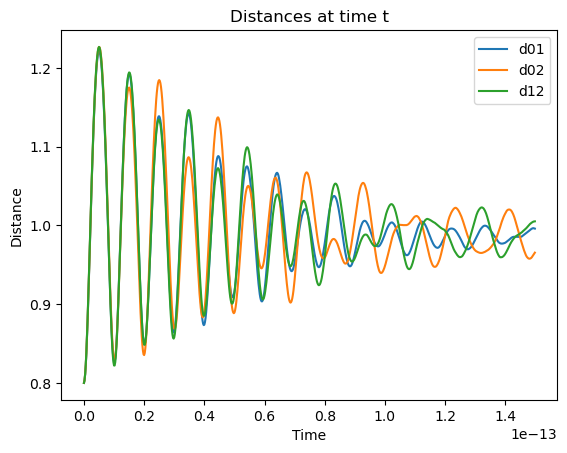

In [ ]:
from matplotlib import pyplot as plt
(distance01,distance02,distance12,times) = main()

np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')

plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()